In [1]:
import sys
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import shap
import random
import itertools
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

assays = ['DNase', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'Methylation_pos', 'Methylation_neg', 'MNase']
assay_index_choice = 6 # 1-based

RESOLUTION = 25
window_size = 401
operative_half_window_size = 80 # will lead to a total of the central 2*operative_half_window_size + 1 features being chosen
pairwise_flag = True # If true then H3K27ac features will be concatentated with assays[assay_index_choice-1]
if(pairwise_flag):
    pairwise_multiplier = 0
else:
    pairwise_multiplier = 1


In [2]:
colnames = ["pos_" + str(x) for x in list(range(-(window_size//2), (window_size//2) + 1))]
colnames = colnames + ["log10p1(TPM)", "cell_type", "chrom", "position", "strand", "assay_index"] 
df = pd.read_csv('../Data/MNase.Training_Data.csv', sep=",", names=colnames, low_memory=False)
df_sorted = df.sort_values(['chrom', 'position', 'cell_type', 'assay_index'], ascending=[1, 1, 1, 1])
df_sorted_unique = df_sorted.drop_duplicates()
df_H3K27ac = df_sorted_unique.iloc[range(4-1, len(df_sorted_unique), len(assays)), :]
df_other_assay = df_sorted_unique.iloc[range(assay_index_choice-1, len(df_sorted_unique), len(assays)), :]
df_merged = pd.merge(df_H3K27ac, df_other_assay, how='inner', on=['cell_type', 'chrom', 'position', 'strand'], suffixes=['_H3K27ac', '_'+assays[assay_index_choice-1]])


(9479, 323) (4879, 323) (9479,) (4879,)
Train: MSE =  0.177 Pearson = 0.676 Spearman = 0.718
Test: MSE =  0.187 Pearson = 0.65 Spearman = 0.695


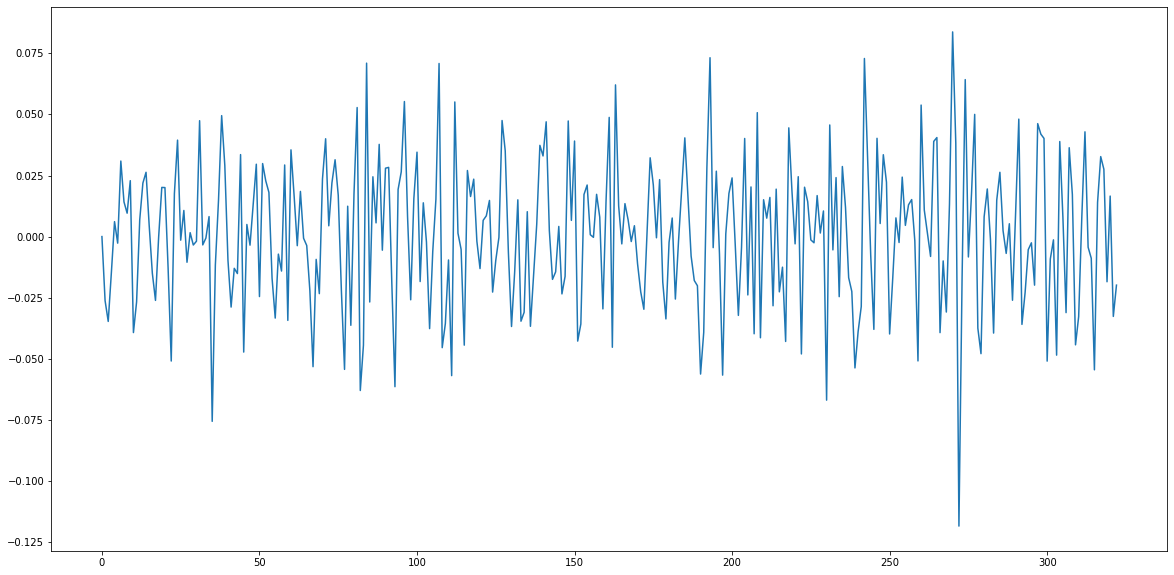

In [15]:
middle_position_first_feature = window_size // 2
middle_position_second_feature = -1 + ( (window_size + 6) + (window_size + 6 + window_size + 1) )//2

df_two_assays = df_merged.iloc[:, 
                               np.r_[middle_position_first_feature-(operative_half_window_size):
                                     middle_position_first_feature+(operative_half_window_size)+1, 
                                     middle_position_second_feature-(operative_half_window_size):
                                     middle_position_second_feature+(operative_half_window_size)+1,
                                     window_size,
                                     window_size + 1,
                                     window_size + 2,
                                     window_size + 3]]

df_subsampled = df_two_assays

# Train on all but CXCR4 and TGFBR1 chromosomes
odd_chroms = ["chr" + str(c) for c in range(1, 23, 1)]
odd_chroms.remove("chr2") # exclude chr2 where CXCR4 lies
odd_chroms.remove("chr9") # exclude chr2 where TGFBR1 lies

df_odd_chroms = df_subsampled.loc[df_subsampled['chrom'].isin(odd_chroms)]
xTrain = df_odd_chroms.iloc[:, pairwise_multiplier*(2 * operative_half_window_size + 1):2 * (2 * operative_half_window_size + 1)] 
yTrain = df_odd_chroms.iloc[:, 2 * (2 * operative_half_window_size + 1)]

even_chroms = ["chr" + str(c) for c in range(2, 23, 2)]
df_even_chroms = df_subsampled.loc[df_subsampled['chrom'].isin(even_chroms)]
xTest = df_even_chroms.iloc[:, pairwise_multiplier*(2 * operative_half_window_size + 1):2 * (2 * operative_half_window_size + 1)] 
yTest = df_even_chroms.iloc[:, 2 * (2 * operative_half_window_size + 1)]

if(len(xTrain) < 10):
    print("len(xTrain) = "+str(len(xTrain)))

quadratic_transform = PolynomialFeatures(degree=1, interaction_only=True).fit(xTrain)
xTrain = quadratic_transform.transform(xTrain)
xTest = quadratic_transform.transform(xTest)

print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

# Fit a ridge regression model
l1_alpha = 0.005
model = linear_model.ElasticNet(alpha=l1_alpha, l1_ratio=0.0, max_iter=1000)

xTrain = np.asarray(xTrain)
yTrain = np.asarray(yTrain)
xTest = np.asarray(xTest)
yTest = np.asarray(yTest)

model.fit(xTrain, yTrain)

# Compute statistics
yTrain_Pred = model.predict(xTrain)
yTest_Pred = model.predict(xTest)
mse_Train = mean_squared_error(yTrain, yTrain_Pred)
pc_Train, _ = pearsonr(yTrain, yTrain_Pred)
sc_Train, _ = spearmanr(yTrain, yTrain_Pred)
mse_Test = mean_squared_error(yTest, yTest_Pred)
pc_Test, _ = pearsonr(yTest, yTest_Pred)
sc_Test, _ = spearmanr(yTest, yTest_Pred)

print("Train: MSE = ", round(mse_Train, 3), "Pearson =", round(pc_Train, 3), "Spearman =", round(sc_Train, 3))
print("Test: MSE = ", round(mse_Test, 3), "Pearson =", round(pc_Test, 3), "Spearman =", round(sc_Test, 3))

plt.plot(model.coef_)

In [23]:
# The goal is to perform in-silico perturbation using a model trained to predict bulk gene expression from 
# epigenetic features, on CRISPRa data

cell_type_choice = 13 # corresponds to HEK293T
assay_index = assay_index_choice

inserted_pvalue_choice = 1.5 # corresponds to 0.0003
for peak_width_choice in range(6, 7, 2):
    
    for MNase_offset in range(-15, 15):
#         print("peak_width = ", peak_width_choice)
        TPM = {}

        # Perform inference for epigenome editing data
        def ise(cell_type_choice_input, 
                gene,
                gene_strand,
                gRNA_strand_dict,
                trained_model,
                assay_index_value,
                inserted_lnp1_minuslog10p_value = 3,
                peak_width = 2,
                pairwise_features=False):

            # Load epigenetic features for all assays
            X = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice_input + ".npy")

            # obtain the middle portion of this
            X = X[:, (window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

            # Perform inference by introducing p-value changes with a peak width
            yPred = []
            center = operative_half_window_size
            positions = range(center - center, center + center + 1)
            for pos in positions:
                X_modified = np.copy(X)

                # some positions won't be used in the plot and hence we don't perturb them
                if(pos not in gRNA_strand_dict):
                    gRNA_strand = "plus" # Change 1
                else:
                    gRNA_strand = gRNA_strand_dict[pos]

                ise_start_position = pos - (peak_width // 2)
                ise_end_position = pos + (peak_width // 2 + 1) 

                for p in range(ise_start_position, ise_end_position):
                    if( (p>=0) and (p < max(positions)) ):
                        if(X_modified[:, p, 2] > 10): # Remember this is ln( -log10(p-value) + 1)
                            # If H3K27me3 peak exists, then p300 doesn't work
                            print("H3K27me3 exists!")
                            pass
                        else:
                            if (pairwise_features):
                                # Modify the H3K27ac peak with the shape being derived from MNase (-1) 
                                if(gRNA_strand == "plus"):
                                    X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                                     print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
                                else: #(gRNA_strand == "minus"):
                                    X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                                     print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
#                                 else:
#                                     pass # Change 2
                            else:
                                # Modify the assay itself
                                X_modified[:, p, assay_index_value] += inserted_lnp1_minuslog10p_value

                # Prepare input
                if (pairwise_features):
                    X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index_value]], axis=1)
                else:                 
                    X_modified = X_modified[:, :, assay_index_value]

                yPred_value = trained_model.predict(quadratic_transform.transform(X_modified))
                yy = yPred_value[0]
                yPred.append(yy)

            # Prepare input for predicting native expression
            X_modified_2 = np.copy(X)
            if(pairwise_features):
                X_modified_2 = np.concatenate([X[:, :, 3], X[:, :, assay_index_value]], axis=1) 
            else:
                X_modified_2 = X[:, :, assay_index_value]

            # Instead of scaling, divide by yPred
            yPred_value = trained_model.predict(quadratic_transform.transform(X_modified_2))[0] + 0.00000001 # to avoid divby0

        #             print("Predicted TPM for ", gene, " = ", yPred_TPM)
        #             print((np.power(10, yPred) -1), (np.power(10, yPred_value) -1))

            yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)
            yPred_TPM = (np.power(10, yPred_value) -1)
            return yPred, yPred_TPM


        def p_value_mapping(inserted_lnp1_minuslog10p_value):
            minuslog10p_value = np.expm1(inserted_lnp1_minuslog10p_value)
            p_value = np.power(10, -1 * minuslog10p_value)
            return round(minuslog10p_value, 4)


        def convert_to_2D(idx, nrows, ncols):
            return idx//ncols, idx%ncols


        # Now that we have the helper functions declared, we perform the in silico perturbation

        # Load p300 epigenome editing data
        df_p300_epigenome_editing = pd.read_csv("../Data/p300_epigenome_editing_dataset.tsv", sep="\t")

        # we want to compute 
        TSS = {}
        STRANDS = {}
        CHROMS = {}
        GENES = {}
        gRNA_STRANDS = {}
        for index in range(len(df_p300_epigenome_editing)):
            tss = df_p300_epigenome_editing.iloc[index, 13]
            gene_strand = df_p300_epigenome_editing.iloc[index, 3]
            chrom = df_p300_epigenome_editing.iloc[index, 2]
            gene = df_p300_epigenome_editing.iloc[index, 0]

            TSS[gene] = int(tss)

            if(gene_strand == "plus"):
                STRANDS[gene] = "+"
            elif(gene_strand == "minus"):
                STRANDS[gene] = "-"
            else:
                print("something wrong with strand!")

            CHROMS[gene] = chrom
            GENES[gene] = 1                                                    

        GENES_LIST = set(list(GENES.keys()))    

        df_GENES_values = {}
        df_GENES_means = {}
        gene_strand_dict = {}
        for gene in GENES_LIST:
            df_GENES_values[gene] = df_p300_epigenome_editing[df_p300_epigenome_editing["p300 target gene"] == gene]

            df_GENES_values[gene]["Position_wrt_TSS"] = ( (pd.to_numeric(df_GENES_values[gene]["gRNA position  wrt TSS (hg38)"])) / RESOLUTION ) # Change 3

            df_GENES_values[gene]["gRNA_strand"] = df_GENES_values[gene]["gRNA target strand"].apply(lambda s: "red" if(s=="minus") else "blue")
            df_GENES_values[gene]["gRNA_strand_bool"] = df_GENES_values[gene]["gRNA target strand"].apply(lambda s: -1 if(s=="minus") else +1)

            gene_strand_dict[gene] = STRANDS[gene]
        #     print(gene_strand_dict)

            df_GENES_means[gene] = df_GENES_values[gene].groupby('gRNA ID').mean()
            df_GENES_means[gene].index.name = 'gRNA ID'
            df_GENES_means[gene].reset_index(inplace=True)
#             print(gene, df_GENES_means[gene])

        # Perform in-silico epigenesis
        assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
        xticklabels = range(-operative_half_window_size, operative_half_window_size + 1)

        GENES_LIST = ["CXCR4", "TGFBR1"]

        fig, axes = plt.subplots(nrows=len(GENES_LIST), ncols=2, figsize=(40, 30), sharey=False)
        fig.tight_layout(pad=1, w_pad=20, h_pad=25)

        for idx, gene in enumerate(sorted(GENES_LIST)):
            TPM[gene] = {}

            idx_x, idx_y = convert_to_2D(idx, nrows=len(GENES_LIST), ncols=1)
            ax_1 = axes[idx_x, 0]
            ax_2 = axes[idx_x, 1]

            gene_features = np.squeeze(np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".npy"), axis=0)
            gene_features = gene_features[(window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

            df_values = df_GENES_values[gene]
            df_means = df_GENES_means[gene]
            # print(gene, df_values) 
            # print(gene, df_means)

            inserted_lnp1_minuslog10p_value = inserted_pvalue_choice
            peak_width = peak_width_choice

            # Compute gRNA strands for all positions
            gRNA_strand_dict = {}
            for p_idx in range(len(df_means)):
                position_m = int( (df_means.iloc[p_idx, 9] + operative_half_window_size) )
                gRNA_strand = df_means.iloc[p_idx, 10]
                if(gRNA_strand == +1):
                    gRNA_strand_dict[position_m] = "plus"
                elif(gRNA_strand == -1):
                    gRNA_strand_dict[position_m] = "minus"
                else:
                    print("Something wrong with parsing gRNA strand", file=sys.stderr)

            # Pass assay_index as -1 to make sure we select MNase
            gene_ise, yPred_TPM = ise(cell_type_choice, gene, gene_strand_dict[gene], gRNA_strand_dict, model, 1*assay_index - 1, inserted_lnp1_minuslog10p_value, peak_width, pairwise_flag)

            # Create a scatter plot of the means with the predictions of those positions
            gene_ise_at_means = []
            alan_means = []
            gRNA_strands = []

            for p_idx in range(len(df_means)):
                position_m = df_means.iloc[p_idx, 9]
                alan_mean = df_means.iloc[p_idx, 1]
                gRNA_strand = df_means.iloc[p_idx, 10]
                if(position_m + operative_half_window_size < 0):
                    continue
                elif( (int(position_m) + operative_half_window_size) >= len(gene_ise) ):
                    continue
                else:
        #             print(len(gene_ise), position_m, operative_half_window_size)
                    gene_ise_at_means.append(gene_ise[int(position_m) + operative_half_window_size])
                    alan_means.append(alan_mean)
                    gRNA_strands.append(gRNA_strand)

            pc, pp = pearsonr(list(alan_means), gene_ise_at_means)
            sc, sp = spearmanr(list(alan_means), gene_ise_at_means)

            print(gene, sc, sp, MNase_offset, file=sys.stderr)

            gRNA_strands_colors = []
            for iii in gRNA_strands:
                if(iii == -1):
                    gRNA_strands_colors.append("red")
                else:
                    gRNA_strands_colors.append("blue")

            ax_1.scatter(list(alan_means), gene_ise_at_means, color="#FF1493", s=1000) # ="#FF1493")
            ax_1.set_xlim(0, 1.1 * max(alan_means))
            ax_1.set_ylim(0, 1.1 * max(gene_ise_at_means))
            ax_1.tick_params(axis='both', which='major', labelsize=40)
            ax_1.tick_params(axis='both', which='minor', labelsize=40)
            ax_1.set_xlabel("Mean experimental fold change", size=60)
            ax_1.set_ylabel("Model prediction's fold change", size=45)
        #     if(pp > 0.05):
        #         p_asterisk = "NS"
        #     if(sp > 0.05):
        #         s_asterisk = "NS"
            ax_1.set_title("Correlation between experimental and model predictions fold change\nPearson = "+
                           str(round(pc, 2))+
                           " ("+str(round(pp, 3))+
                           ") Spearman = "+
                           str(round(sc, 2))+
                           " ("+str(round(sp, 3))+
                           ")", size=40)

            # Determine whether we are doing H3K27ac ISE in the background of another assay's features
            # or we have marginal features and are doing that track's ISE
            if(pairwise_flag):
                epigenetic_features = gene_features[:, -1] # MNase
                epigenetic_features_2 = gene_features[:, 3] # H3K27ac
                color_for_assay = assay_color[3]
                label_for_assay = assays[3]
            else:
                epigenetic_features = gene_features[:, assay_index-1]
                color_for_assay = assay_color[assay_index-1]
                label_for_assay = assays[assay_index-1]

            # Scale the model predictions     
            scaling_ratio = np.median(df_means['Measured fold change'])/np.median(gene_ise - 0.0)
            scaled_model_predictions = 0.5 * (scaling_ratio * (gene_ise - 0.0)) + 1.0

            # Scale the epigenetic features
            epigenetic_features_scaling_ratio = max(df_means['Measured fold change'])/max(epigenetic_features - 0.0)
            scaled_epigenetic_features = (epigenetic_features_scaling_ratio * (epigenetic_features - 0.0)) + 0.5

            epigenetic_features_scaling_ratio_2 = max(df_means['Measured fold change'])/max(epigenetic_features_2 - 0.0)
            scaled_epigenetic_features_2 = (epigenetic_features_scaling_ratio_2 * (epigenetic_features_2 - 0.0)) + 0.0 

            ax_2.plot(xticklabels, scaled_model_predictions, 'o-', color="#4daf4a", linewidth=5, markersize=2, label="(Scaled) Model Predictions " + label_for_assay)
            ax_2.plot(xticklabels, scaled_epigenetic_features, 'o-', color="#8470FF", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features MNase") # + label_for_assay)
            ax_2.plot(xticklabels, scaled_epigenetic_features_2, 'o-', color="darkblue", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features H3K27ac") # + label_for_assay)

            ax_2.bar(df_means['Position_wrt_TSS'], 0.0 + (df_means['Measured fold change']), color="#f781bf", bottom=0, width=2, label="Experimental mean from qPCR")

            gRNA_strand_groups = df_values.groupby("gRNA target strand")

            color_dict = {}
            color_dict["+"] = {"plus":"blue", "minus":"red"}
            color_dict["-"] = {"plus":"red", "minus":"blue"}
            direction = {"blue":"rightward", "red":"leftward"}
            color_index = 0
            for name, group in gRNA_strand_groups:
                ax_2.plot(group['Position_wrt_TSS'], 0.0 + (group['Measured fold change']), 'o', color=color_dict[STRANDS[gene]][name], label="qPCR facing "+direction[color_dict[STRANDS[gene]][name]], markersize=15)
                color_index += 1

            ax_2.set_xlim(-operative_half_window_size-10, operative_half_window_size+10)
            ax_2.set_ylim(-1, 1.0 + max(df_means['Measured fold change'])*1.5)
            x_vals = ax_2.get_xticks()
            ax_2.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
            ax_2.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax_2.tick_params(axis='both', which='major', labelsize=35)
            ax_2.tick_params(axis='both', which='minor', labelsize=35)
            ax_2.set_xlabel("Peak Position (in bp) w.r.t TSS", size=50)
            ax_2.set_ylabel("Gene expression fold change", size=50)
            ax_2.set_title(gene+" with H3K27ac + "+assays[assay_index-1]+"\nincreasing " + str(peak_width * RESOLUTION) + "bp peaks by -log10(p_value)="+str(p_value_mapping(inserted_lnp1_minuslog10p_value)), size=40) #, y=1.1)

            ax_2.legend(loc='upper center', prop={'size': 30}, ncol=2)

            # Now also keep storing the actual TPM vs predicted TPM for each gene, for each cell type
            actual_TPM = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".TPM.npy")
        #             print(gene, cell_type_choice, (np.power(10, actual_TPM[0][0]) -1), yPred_TPM)
            TPM[gene][cell_type_choice] = ((np.power(10, actual_TPM[0][0]) -1), yPred_TPM)

#         plt.show()
        plt.close()




CXCR4 0.5350152746229946 0.007063672430011737 -15
TGFBR1 -0.2688308079526714 0.16657804423915348 -15
CXCR4 0.42801221969839565 0.03693310010993563 -14
TGFBR1 -0.02395178908689387 0.9037071683038775 -14
CXCR4 0.45498046931353847 0.02548950836481645 -13
TGFBR1 -0.09488146163035457 0.6310416877413515 -13
CXCR4 0.36276645450046946 0.08146915758490517 -12
TGFBR1 0.024375124688876686 0.9020132486352603 -12
CXCR4 0.39669425240339107 0.054953126849099206 -11
TGFBR1 -0.02533426225903634 0.898176954363016 -11
CXCR4 0.44802092102575963 0.02812469713789099 -10
TGFBR1 0.09386352159301775 0.6347259536814817 -10
CXCR4 0.3758156075400547 0.07032160856995366 -9
TGFBR1 0.1251149180205985 0.5258445110517024 -9
CXCR4 0.48455854953659827 0.016411553465249716 -8
TGFBR1 0.2603718157601744 0.18084430475828311 -8
CXCR4 0.5680731289899438 0.003781067277082567 -7
TGFBR1 0.3407933404528022 0.07595557372207201 -7
CXCR4 0.50369730732799 0.012093777791260812 -6
TGFBR1 0.256007367238497 0.18852949147919118 -6
CXCR4 0

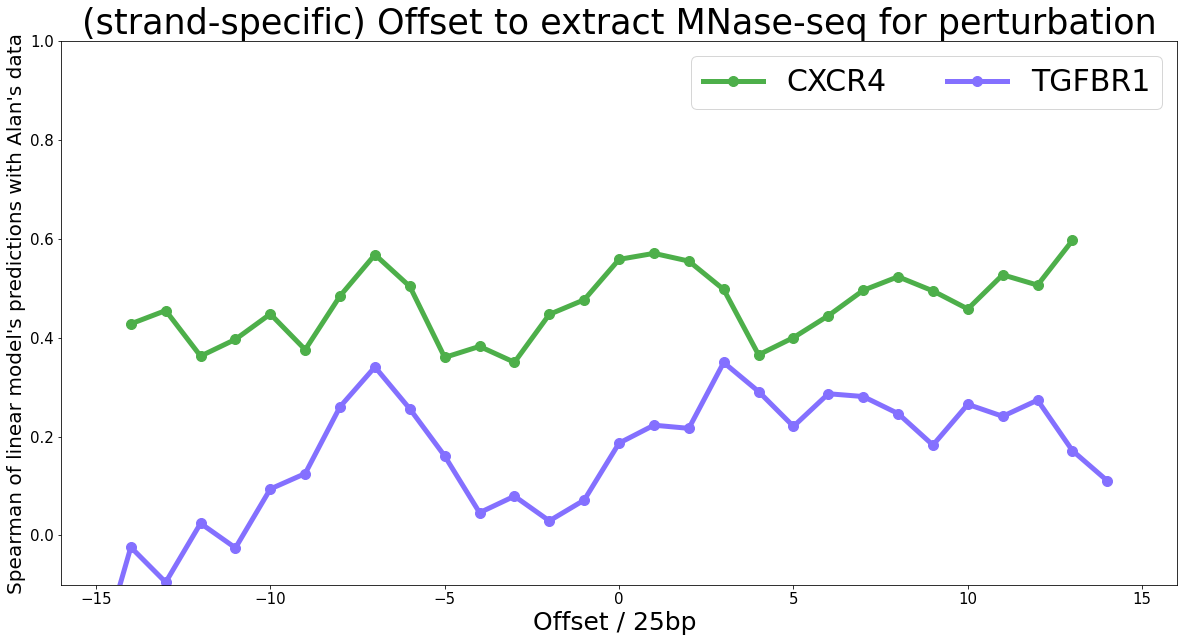

In [24]:
# Plot spearman as a function of MNase offset
plt.rcParams["figure.figsize"] = (20, 10)
colnames = ["gene", "sc", "sp", "offset"] 
df_offset = pd.read_csv('../Data/offset_Spearman.plus_plus', sep=" ", names=colnames, low_memory=False)
df_offset_sorted = df_offset.sort_values(['gene', 'offset'], ascending=[1, 1])
df_offset_sorted
plt.plot(df_offset_sorted.iloc[1:29, 3], df_offset_sorted.iloc[1:29, 1],  'o-', color="#4daf4a", linewidth=5, markersize=10, label="CXCR4")
plt.plot(df_offset_sorted.iloc[30:, 3], df_offset_sorted.iloc[30:, 1],  'o-', color="#8470FF", linewidth=5, markersize=10, label="TGFBR1")
plt.xlabel("Offset / 25bp ", fontsize=25)
plt.ylabel("Spearman of linear model's predictions with Alan's data", fontsize=20)
plt.xlim(-16, 16)
plt.ylim(-0.1, 1)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.title("(strand-specific) Offset to extract MNase-seq for perturbation", fontsize=35)
plt.legend(loc='upper right', prop={'size': 30}, ncol=2)
plt.show()
plt.close()

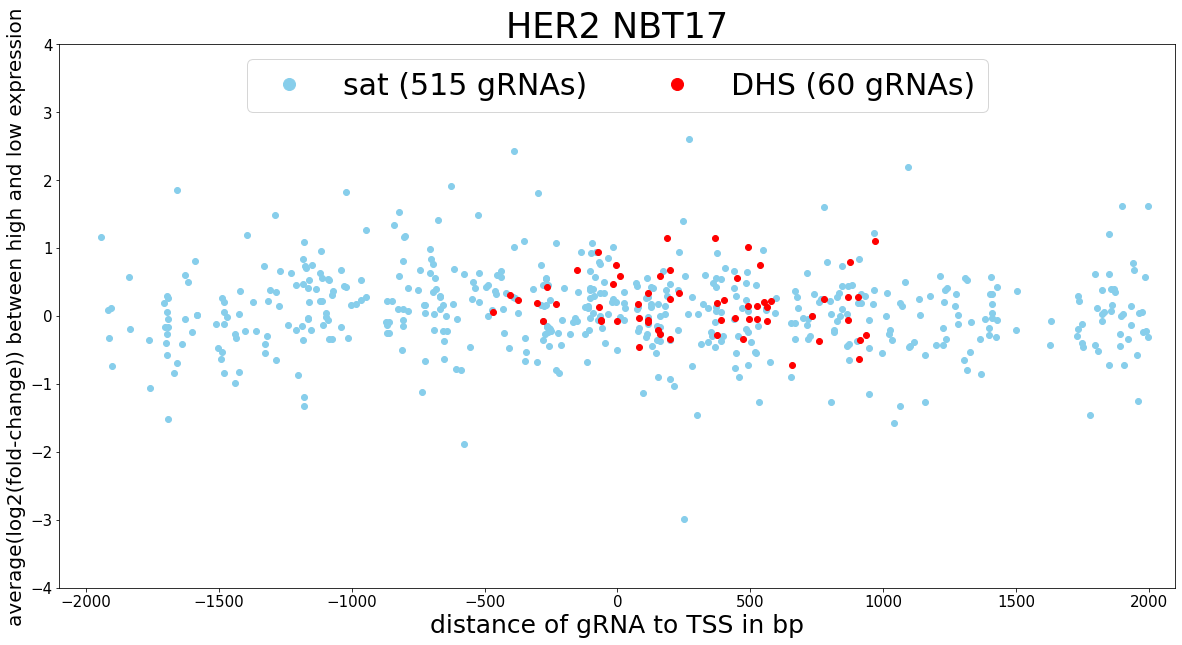

In [42]:
# We analyze the HER2 gene dataset here:
colnames = ["chrom", "gRNA_start", "gRNA_end", "gRNA_ID", "average_log2(fold_change)", "d_TSS"] 
df_HER2_DHS = pd.read_csv('../Data/HER2.DHS.hg38.tsv', sep="\t", names=colnames, low_memory=False)
df_HER2_sat = pd.read_csv('../Data/HER2.sat.hg38.tsv', sep="\t", names=colnames, low_memory=False)
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(df_HER2_sat['d_TSS'], df_HER2_sat['average_log2(fold_change)'], 'o', color="skyblue", label="sat ("+str(len(df_HER2_sat))+" gRNAs)")
plt.plot(df_HER2_DHS['d_TSS'], df_HER2_DHS['average_log2(fold_change)'], 'o', color="red", label="DHS ("+str(len(df_HER2_DHS))+" gRNAs)")
plt.xlabel("distance of gRNA to TSS in bp", fontsize=25)
plt.ylabel("average(log2(fold-change)) between high and low expression", fontsize=20)
plt.xlim(-2100, 2100)
plt.ylim(-4, 4)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.title("HER2 NBT17", fontsize=35)
plt.legend(loc='upper center', prop={'size': 30}, ncol=2, markerscale=2)
plt.show()



HER2 0.04417486484241117 0.2857018161326738 -15


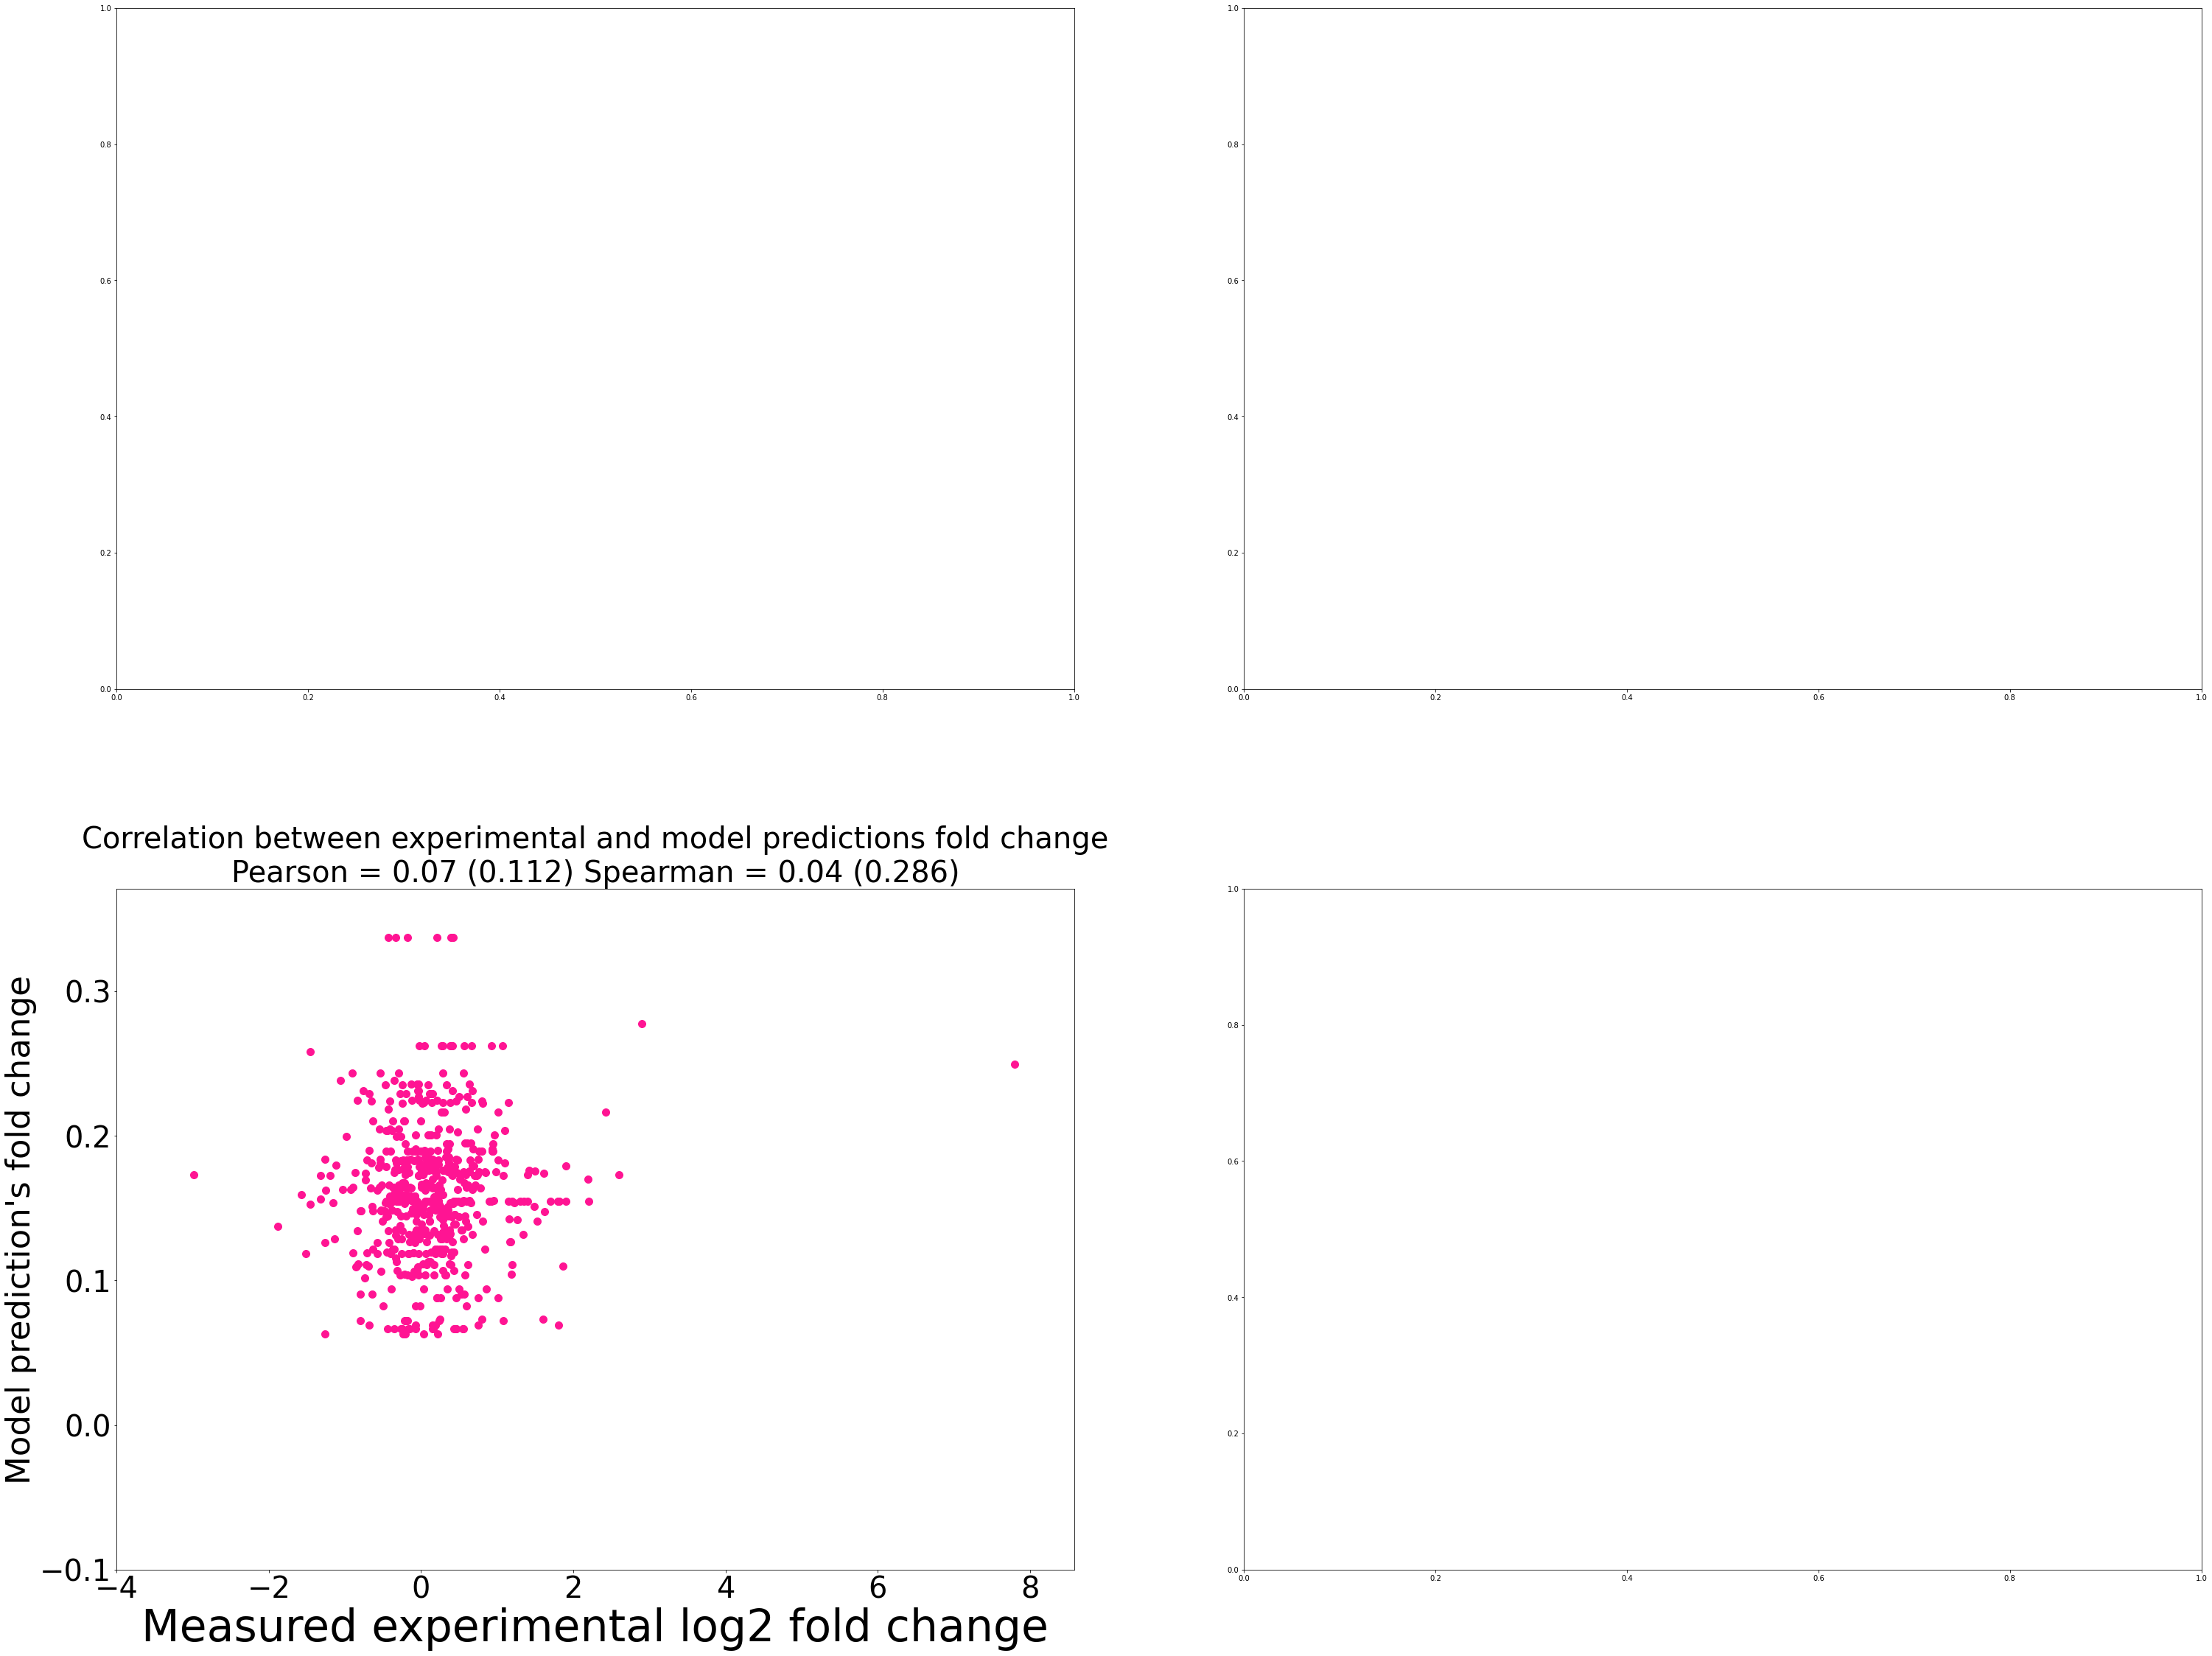

HER2 0.06554161611993642 0.1129864905240825 -14


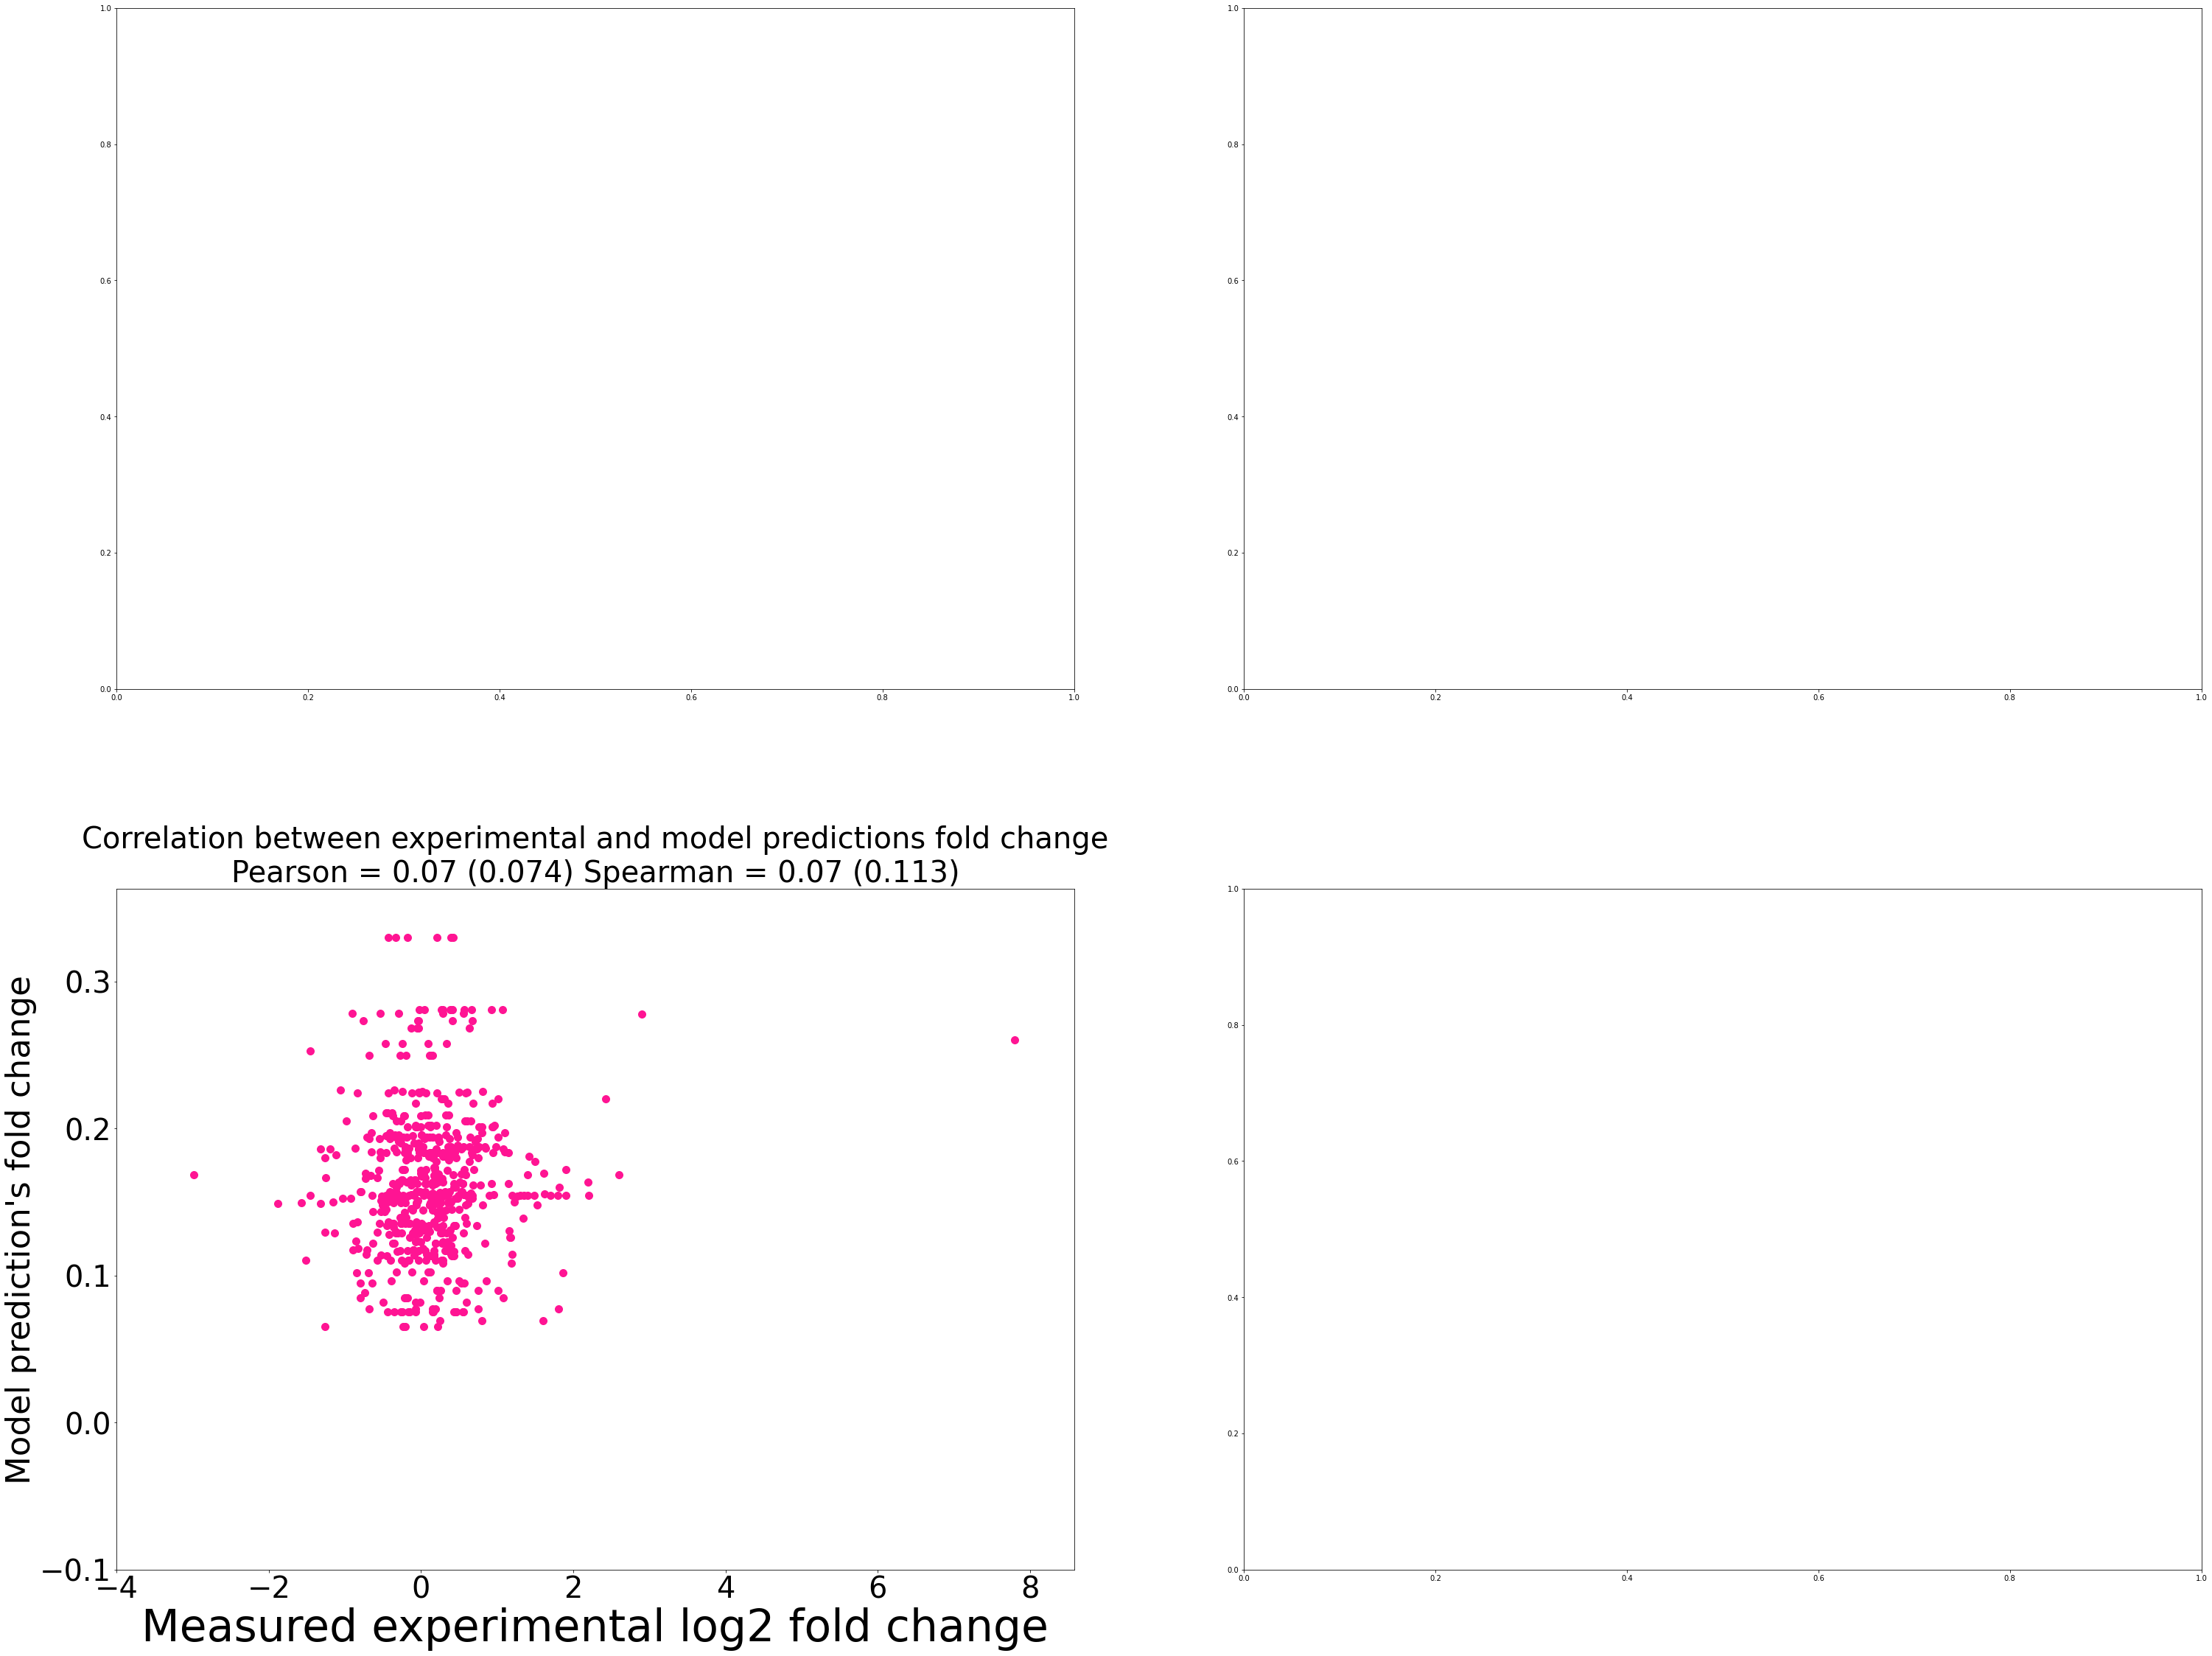

HER2 0.04805241570909137 0.24547395192288726 -13


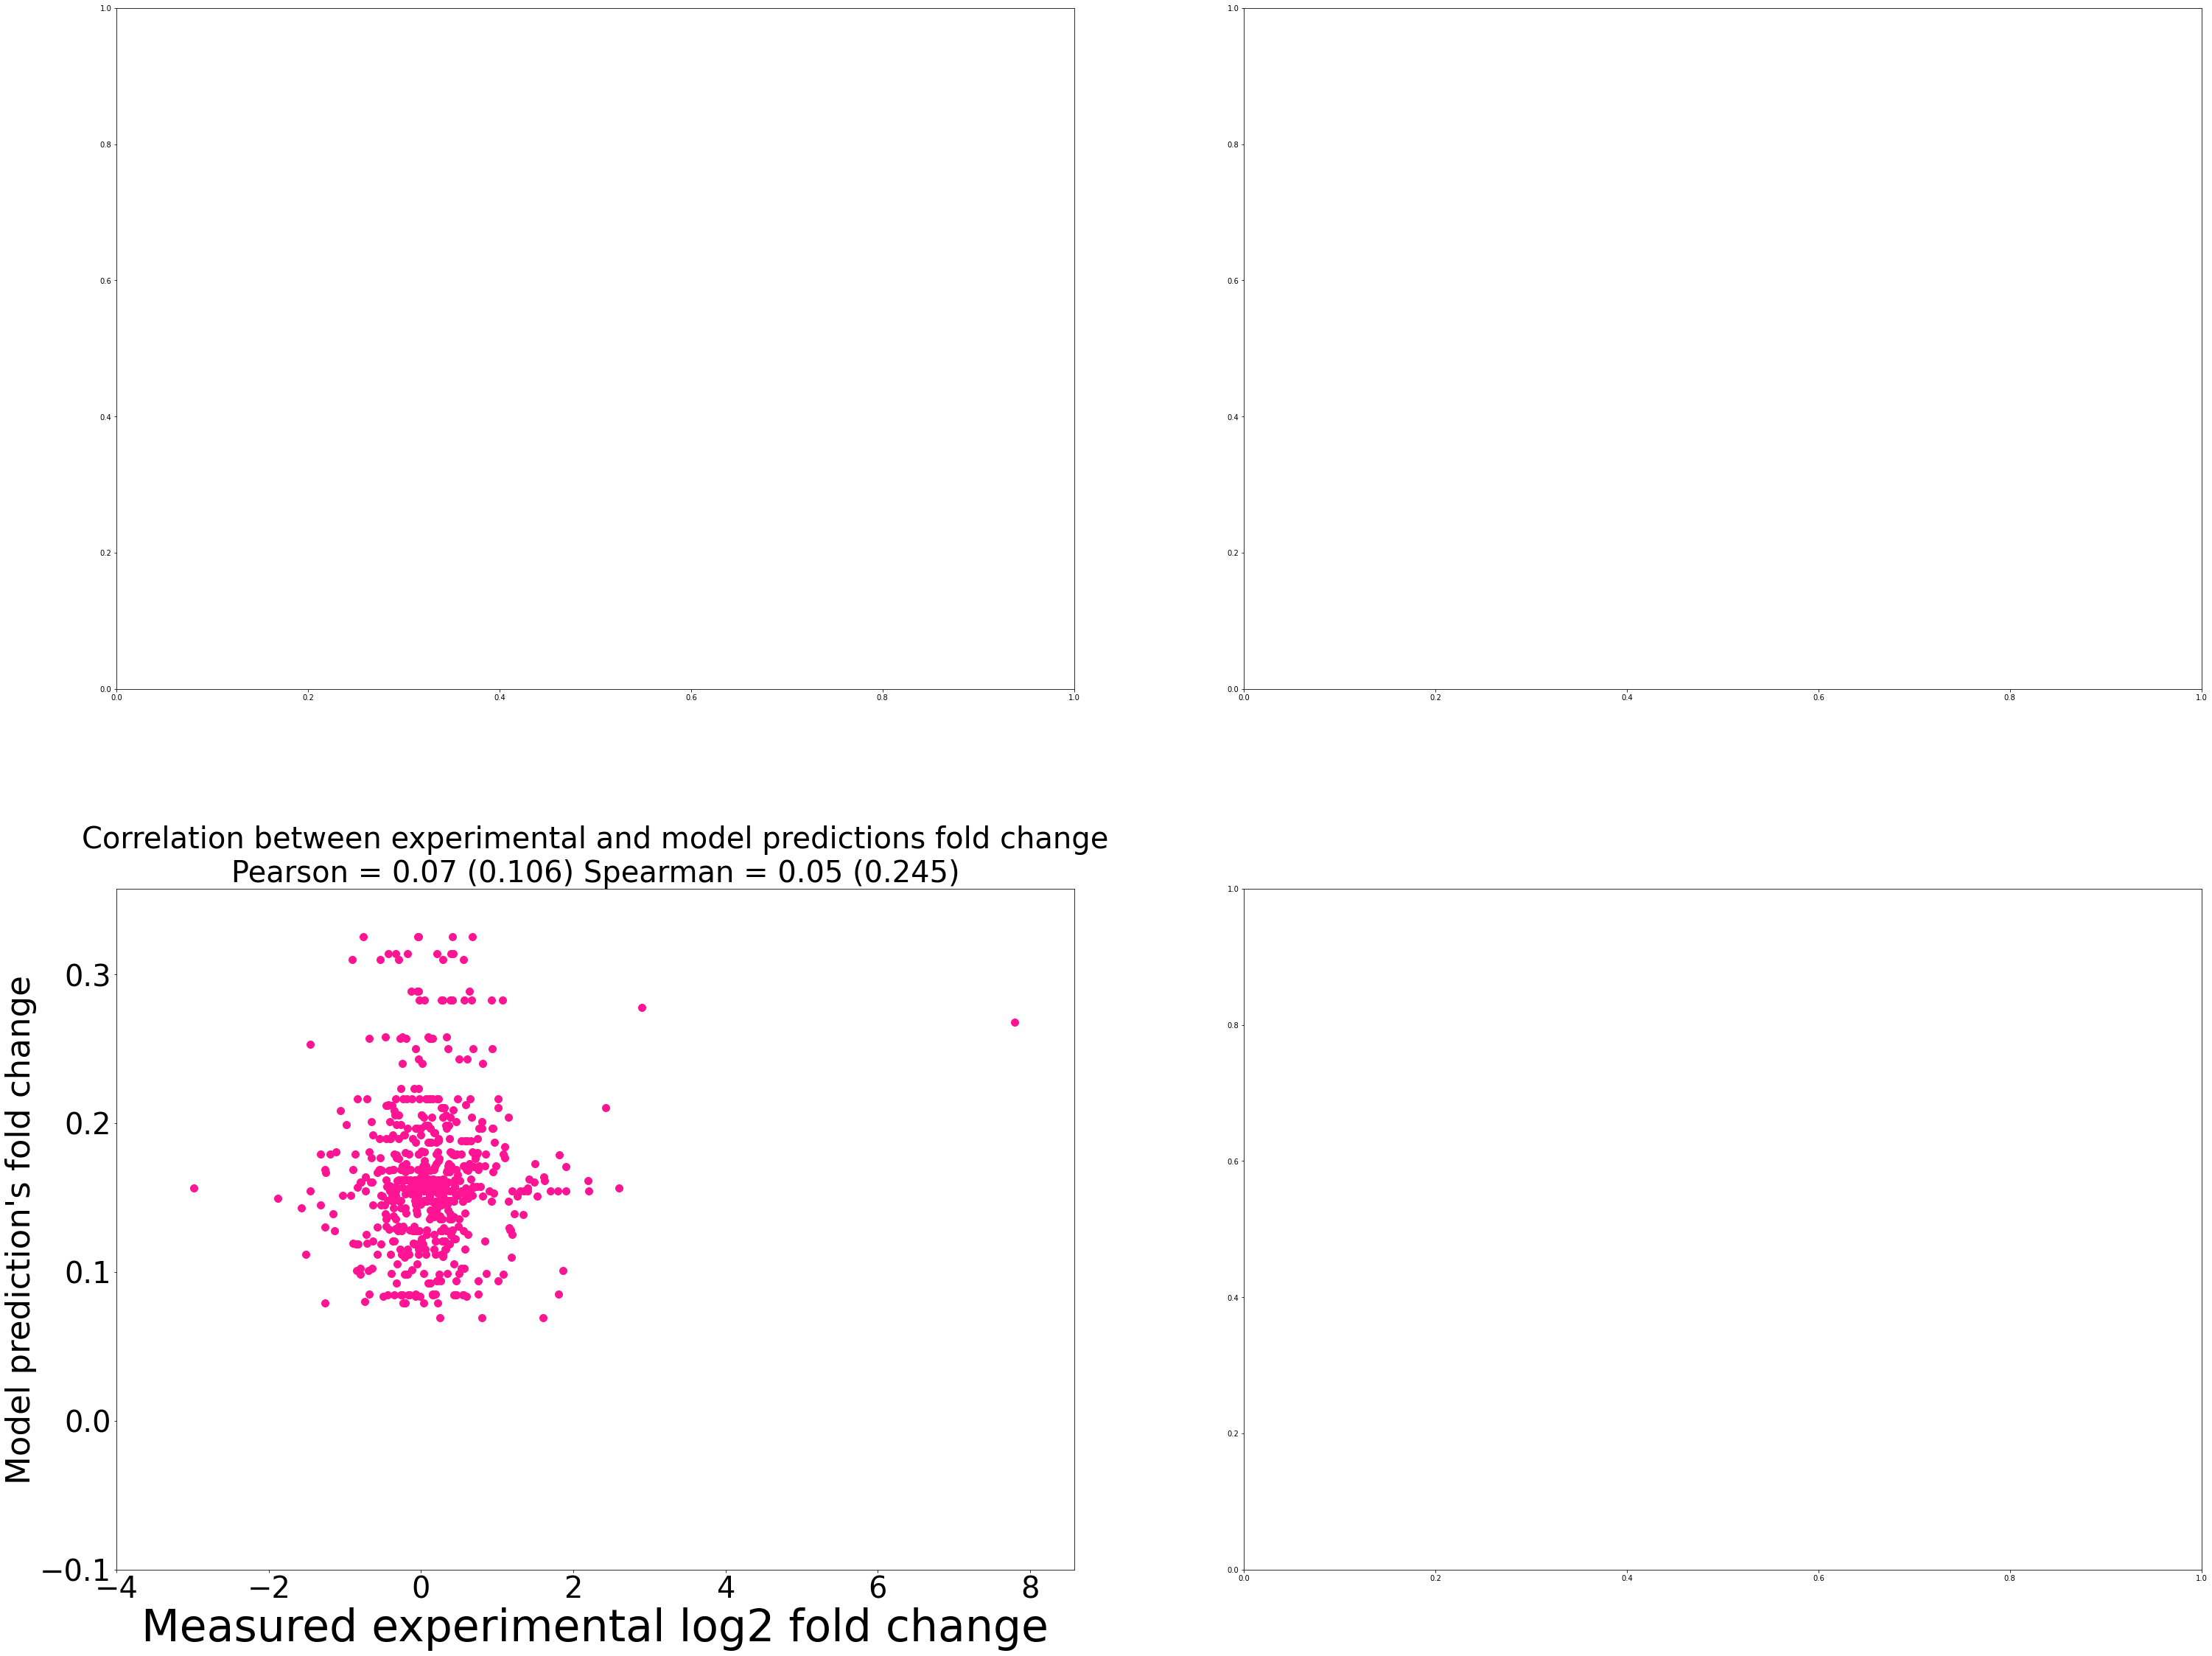

HER2 0.05471054040928164 0.18598015217002906 -12


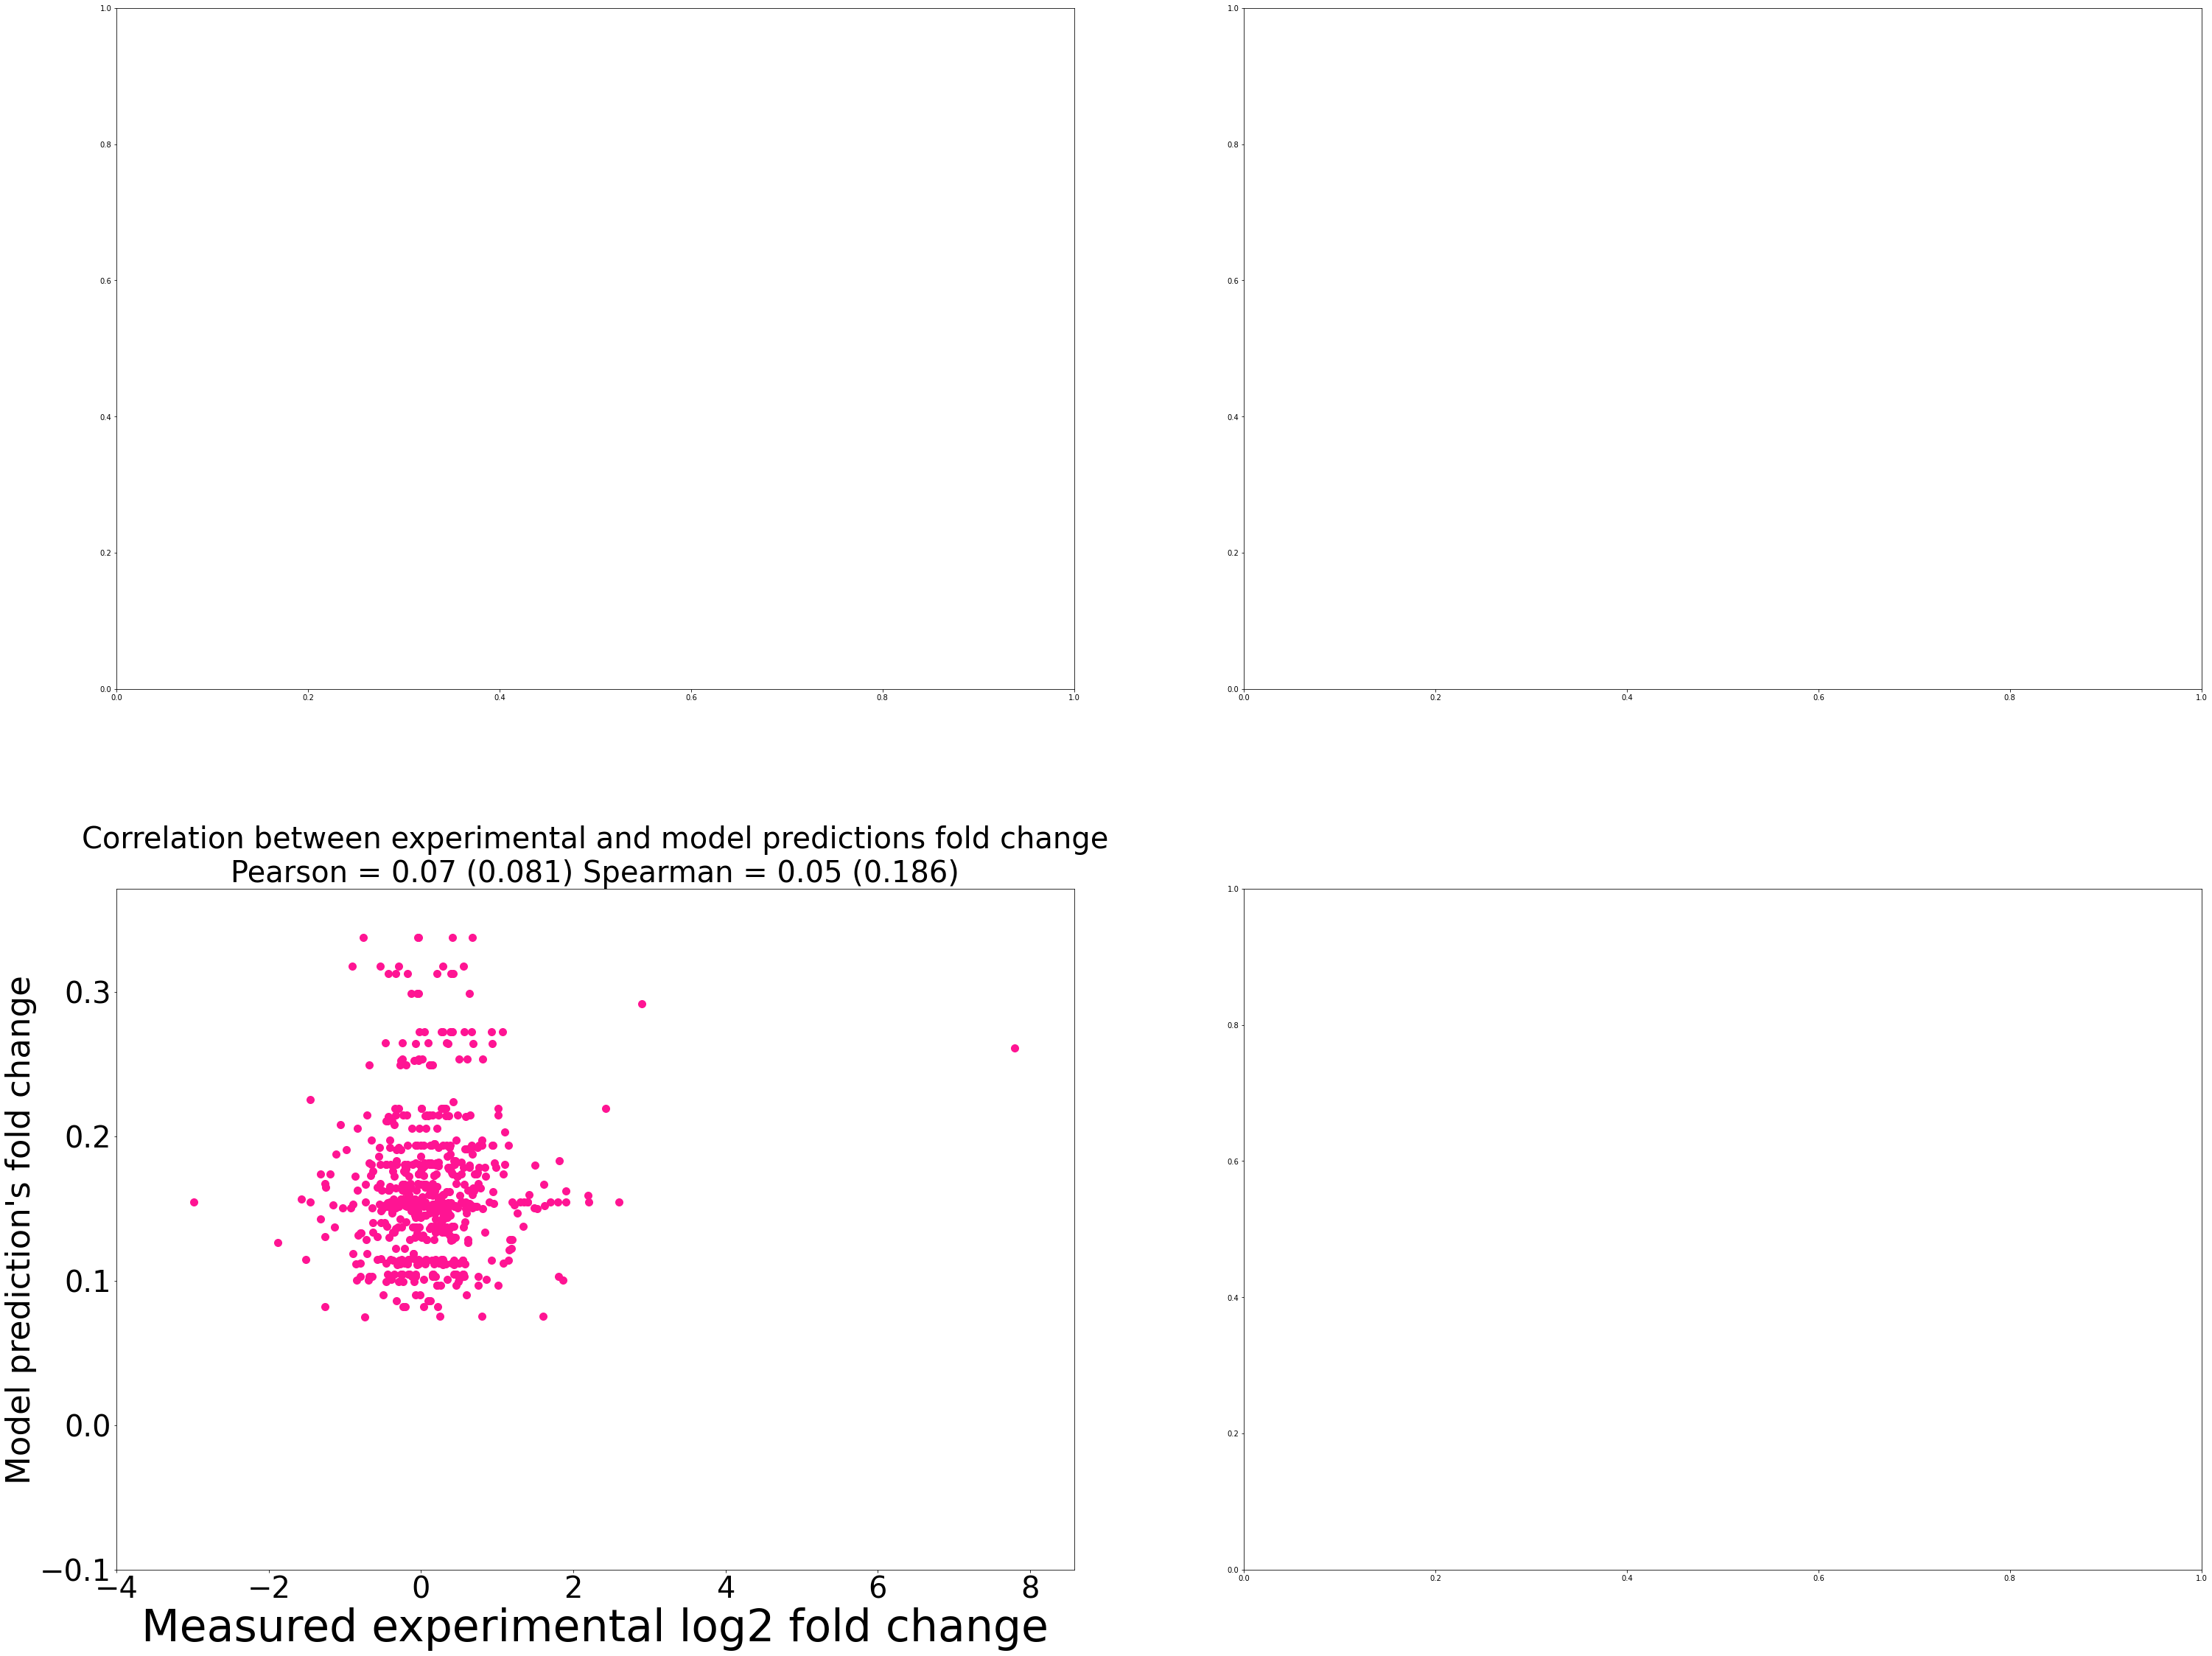

HER2 0.04455717822583766 0.28154867723774857 -11


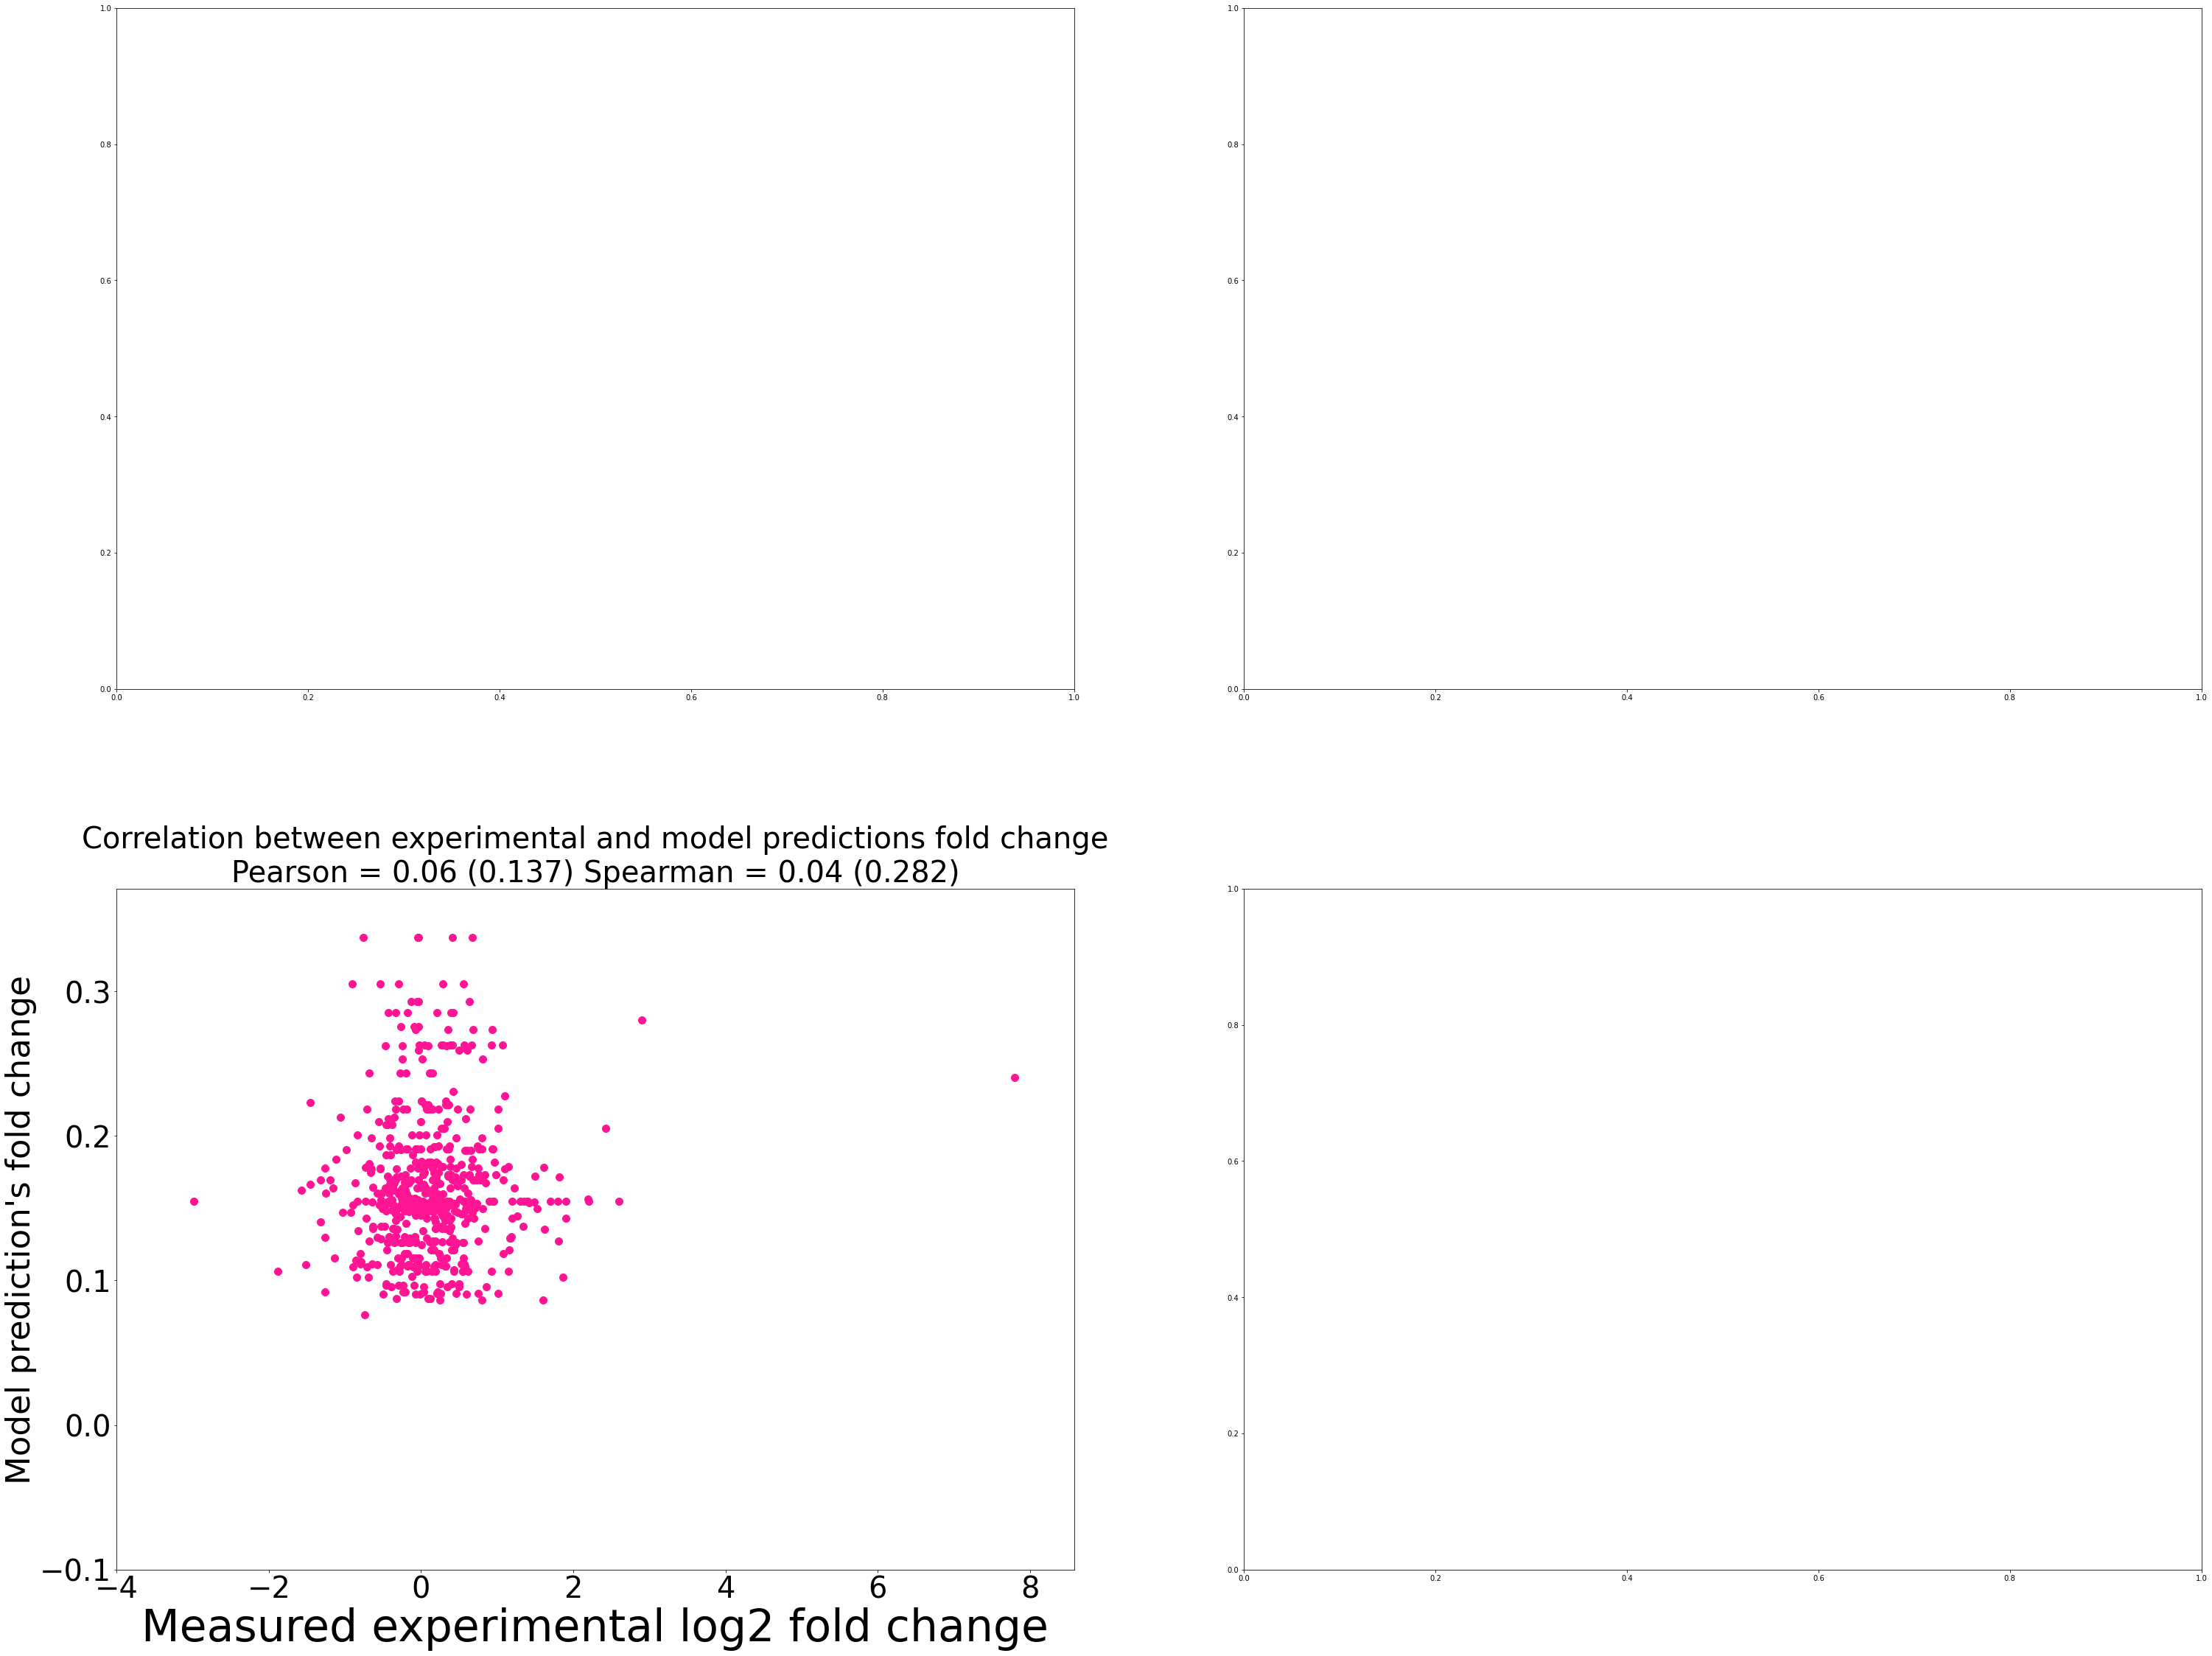

HER2 0.023417639706955966 0.5715649542043704 -10


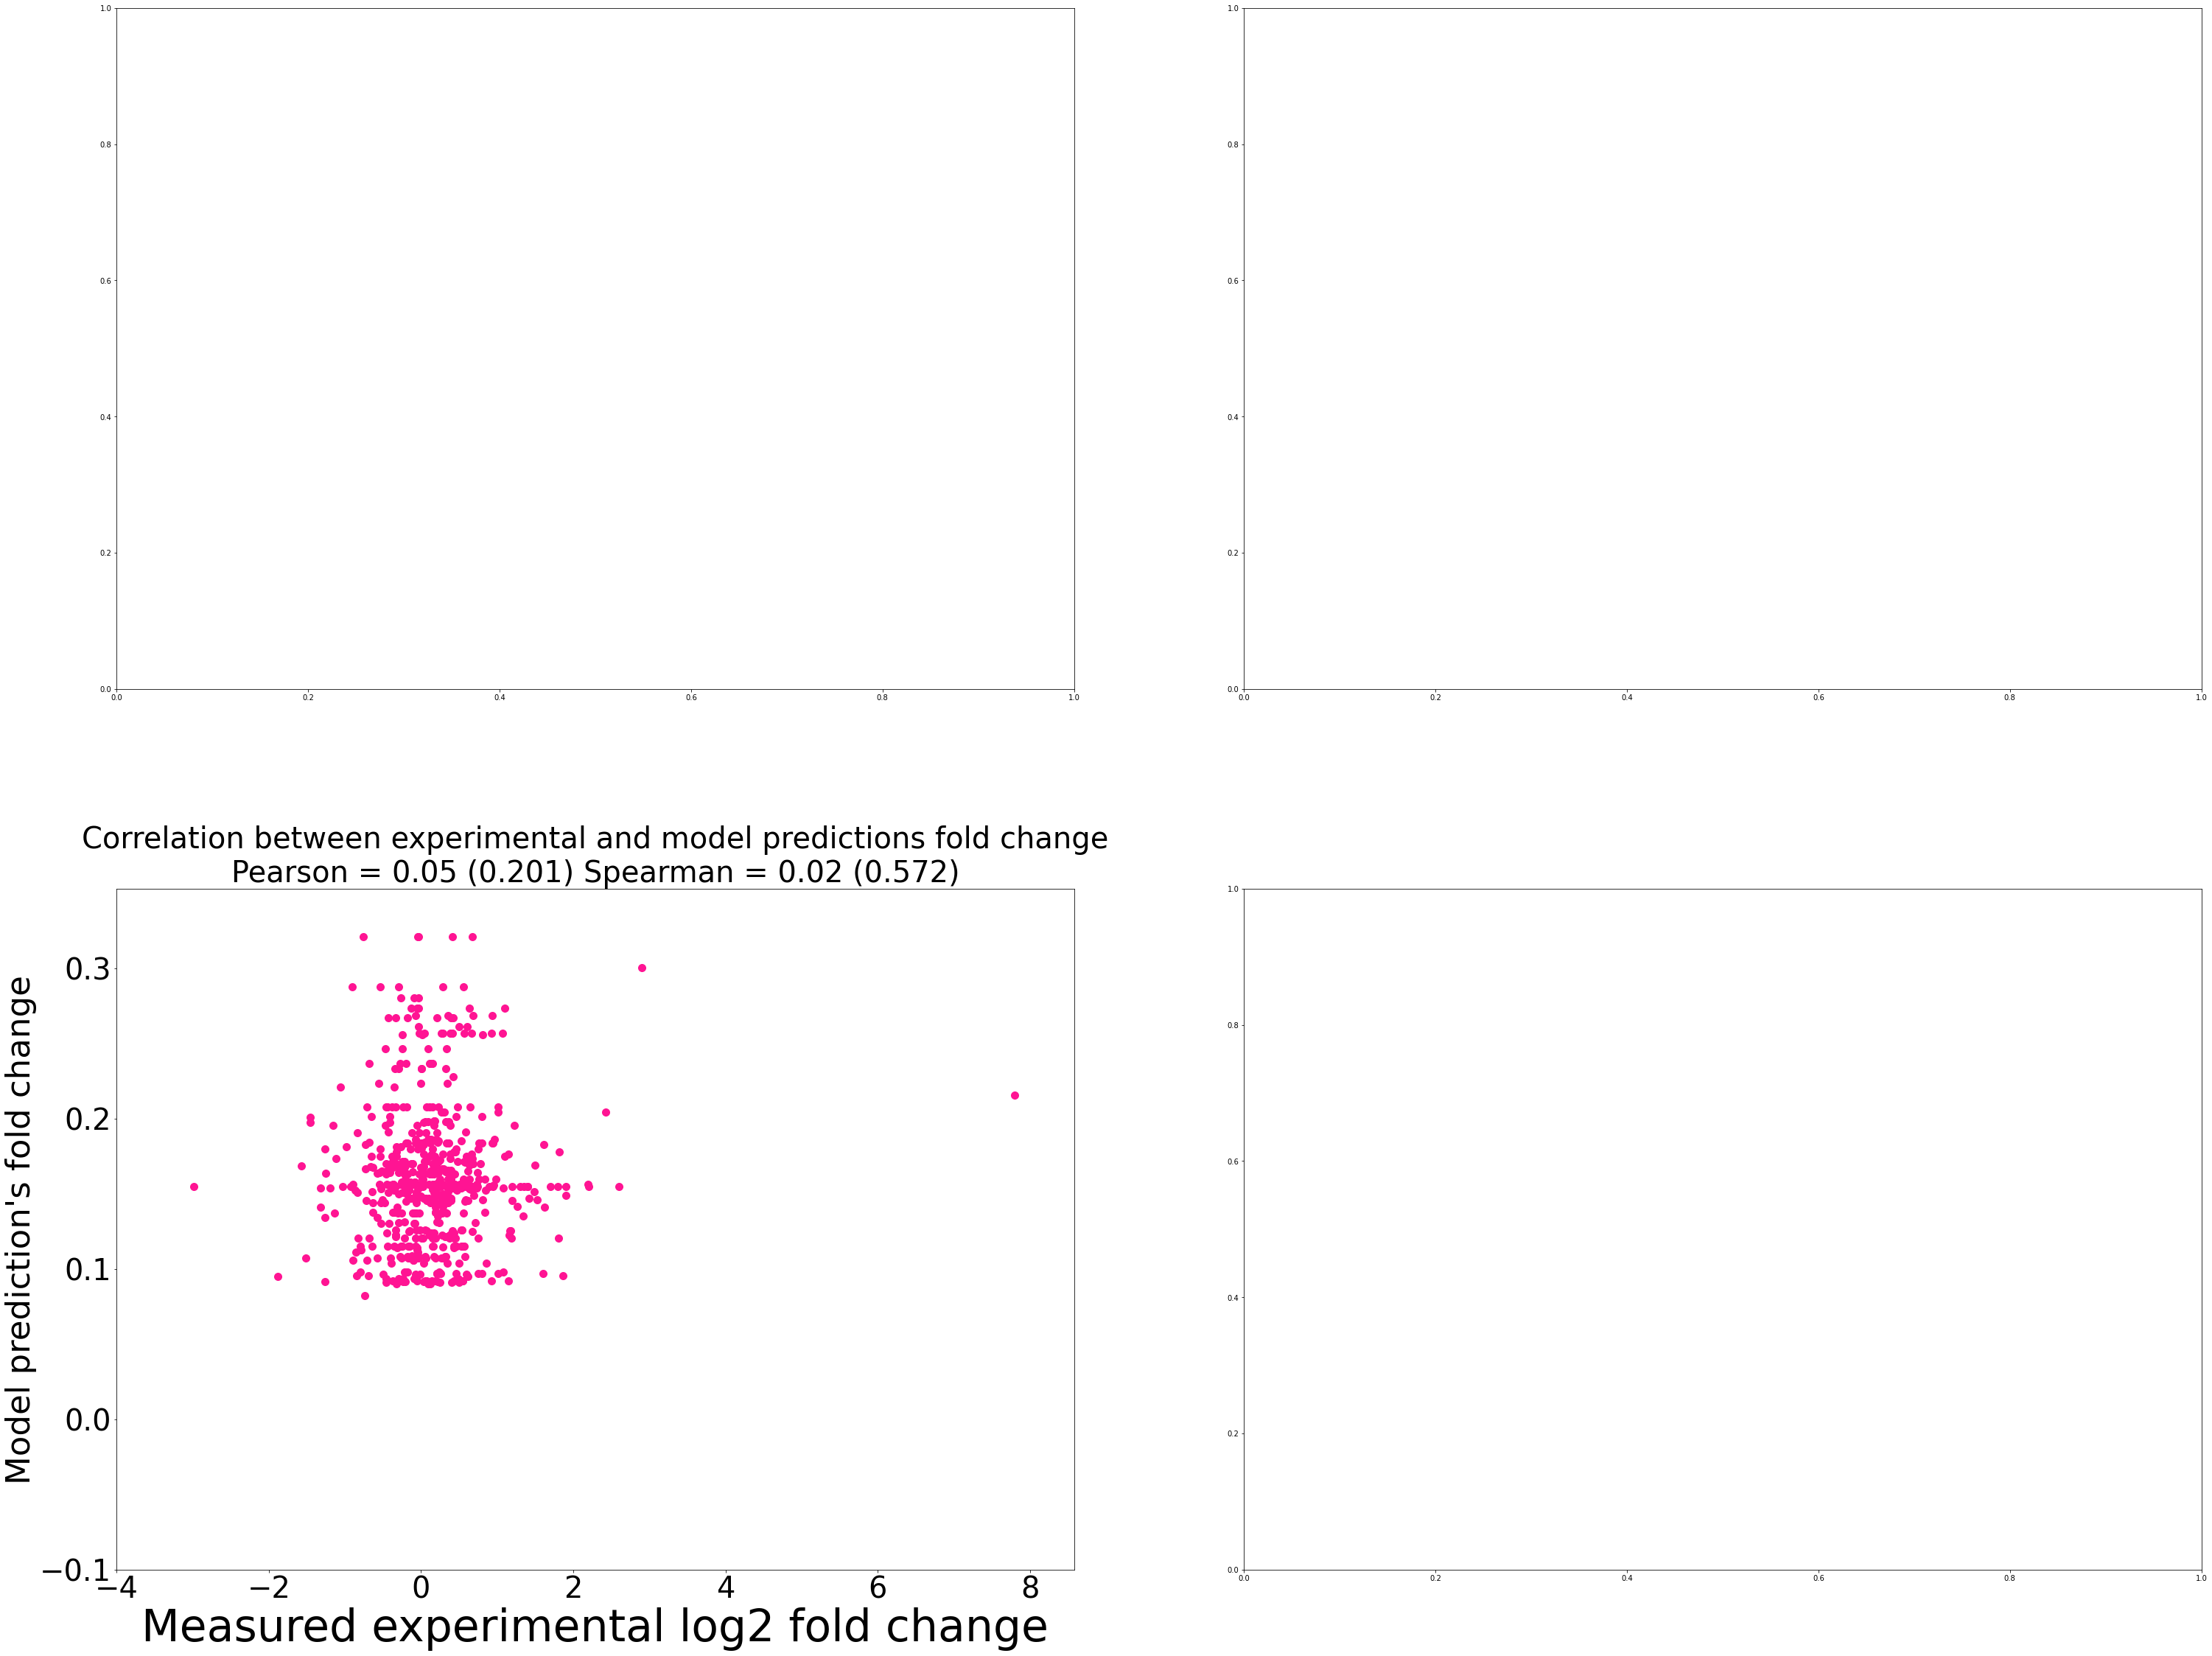

HER2 0.04960797851396339 0.23050608491734095 -9


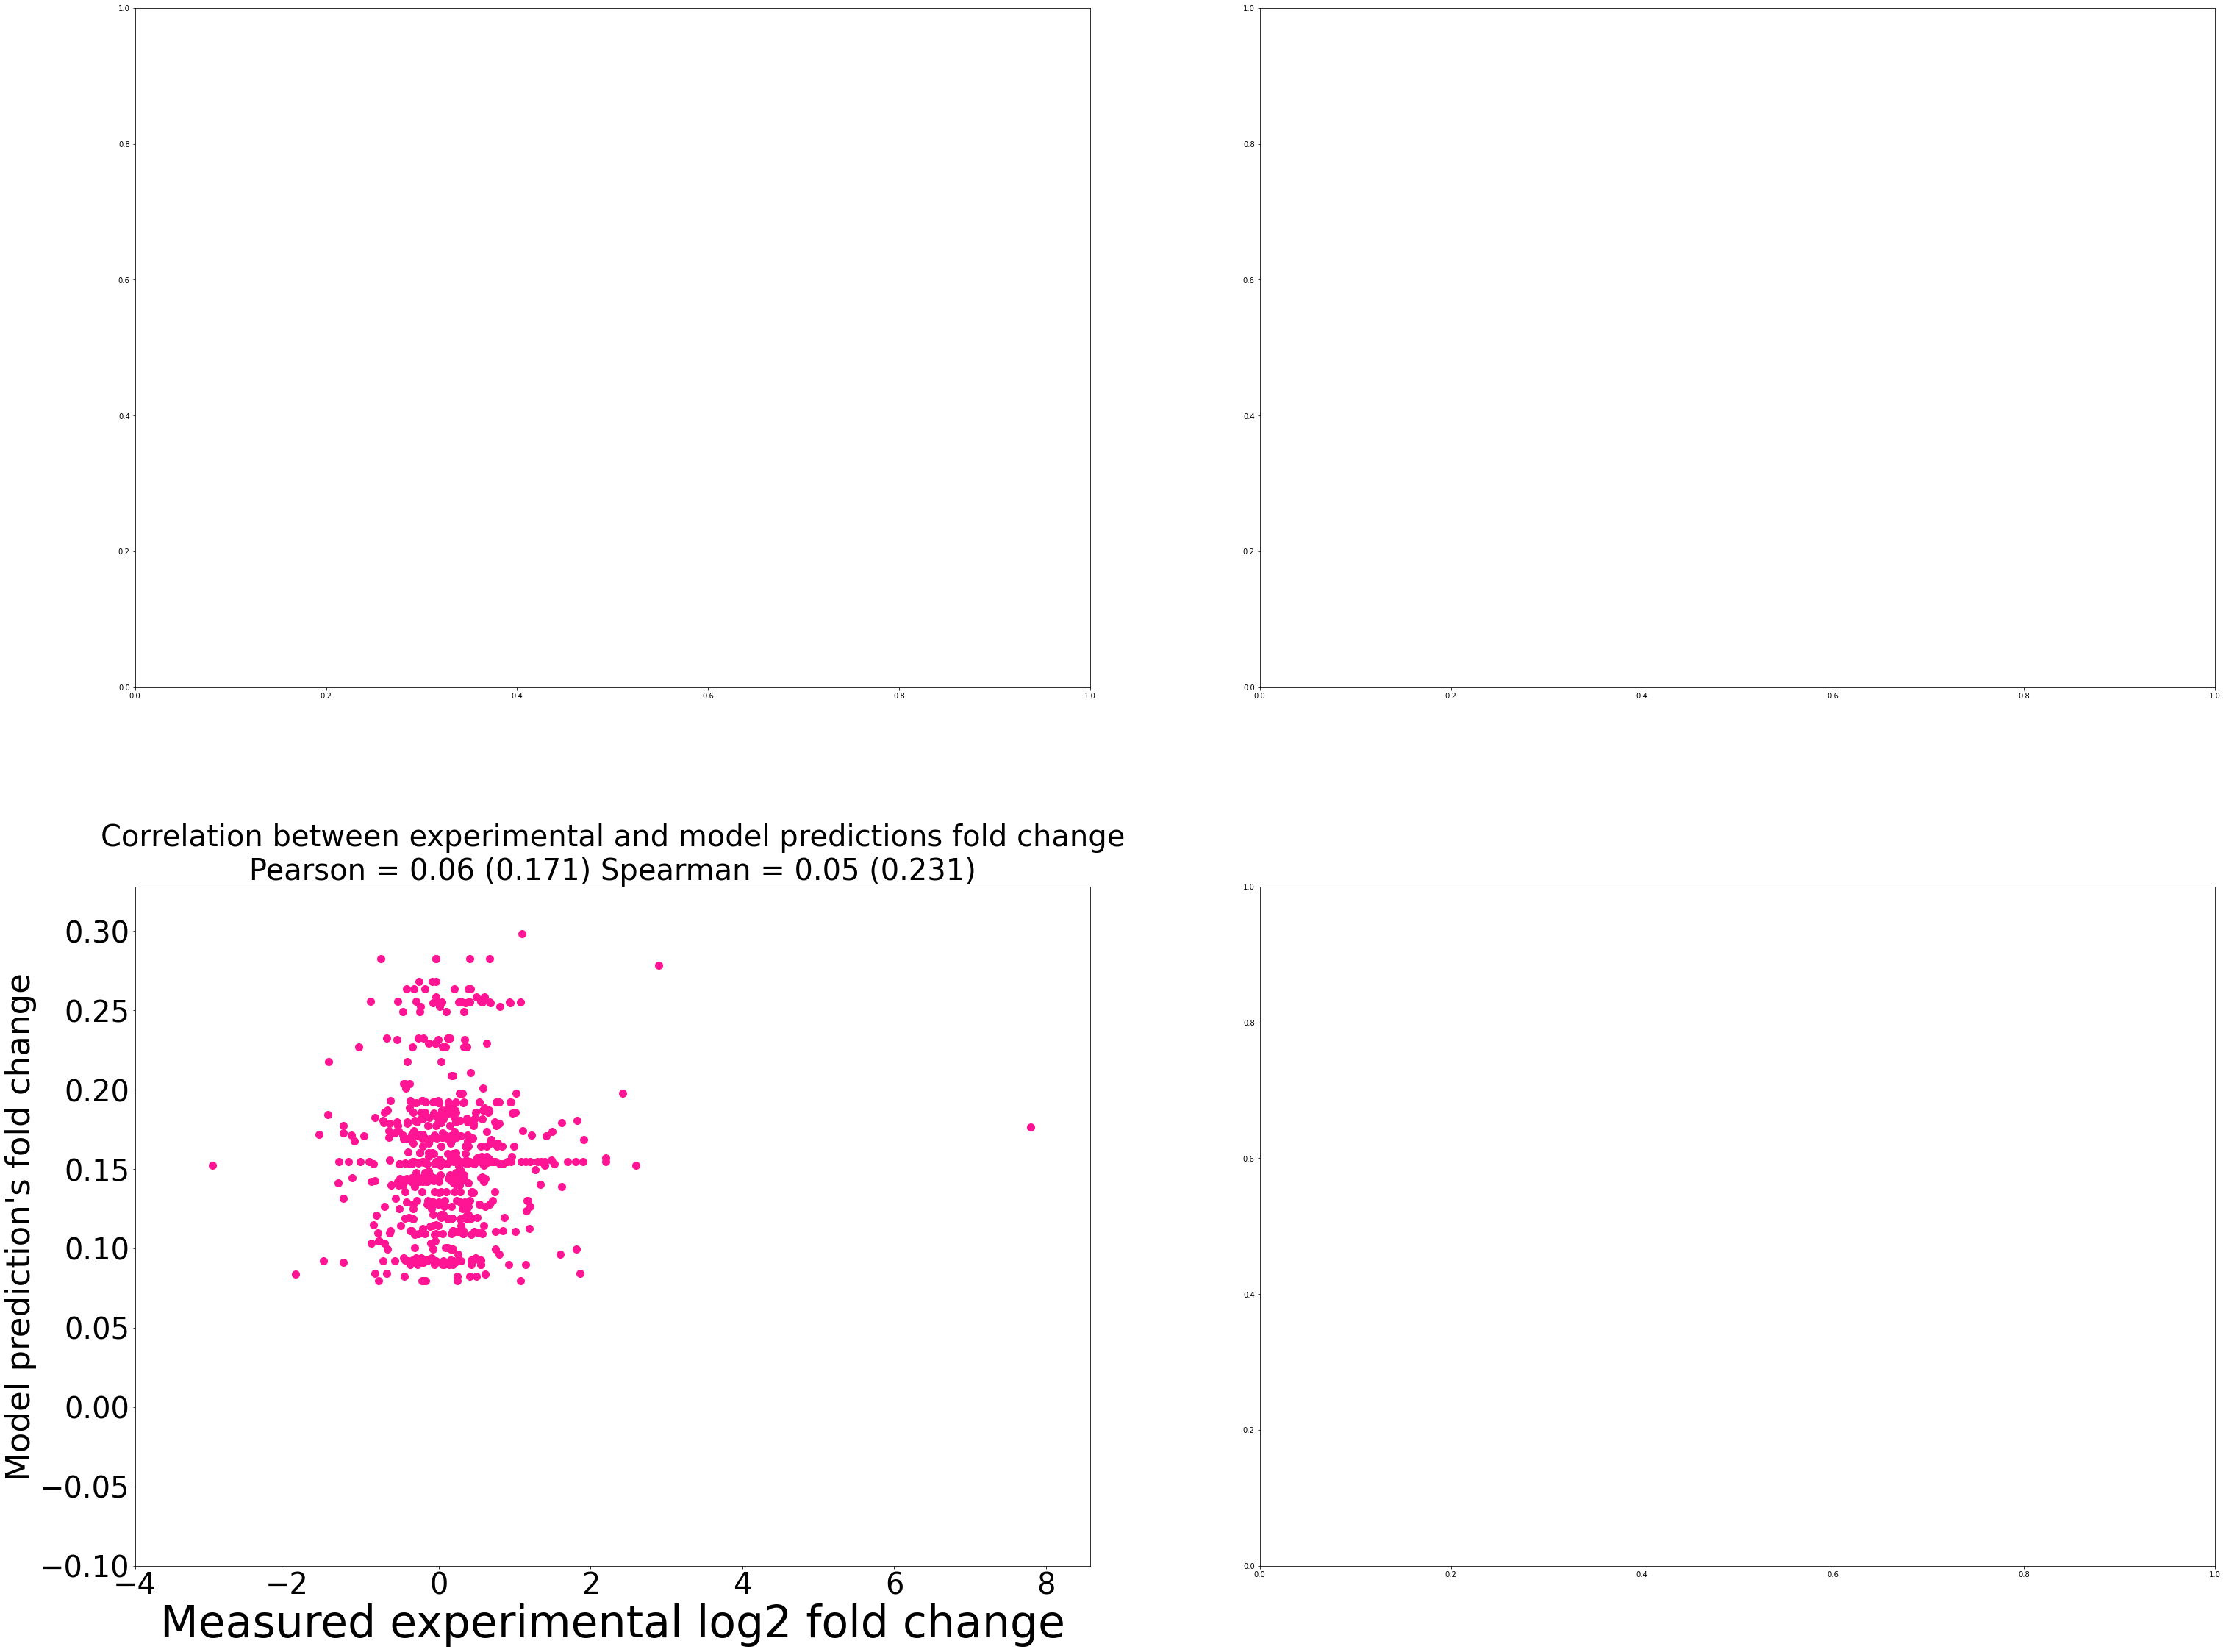

HER2 0.03424978915607884 0.4079128591672163 -8


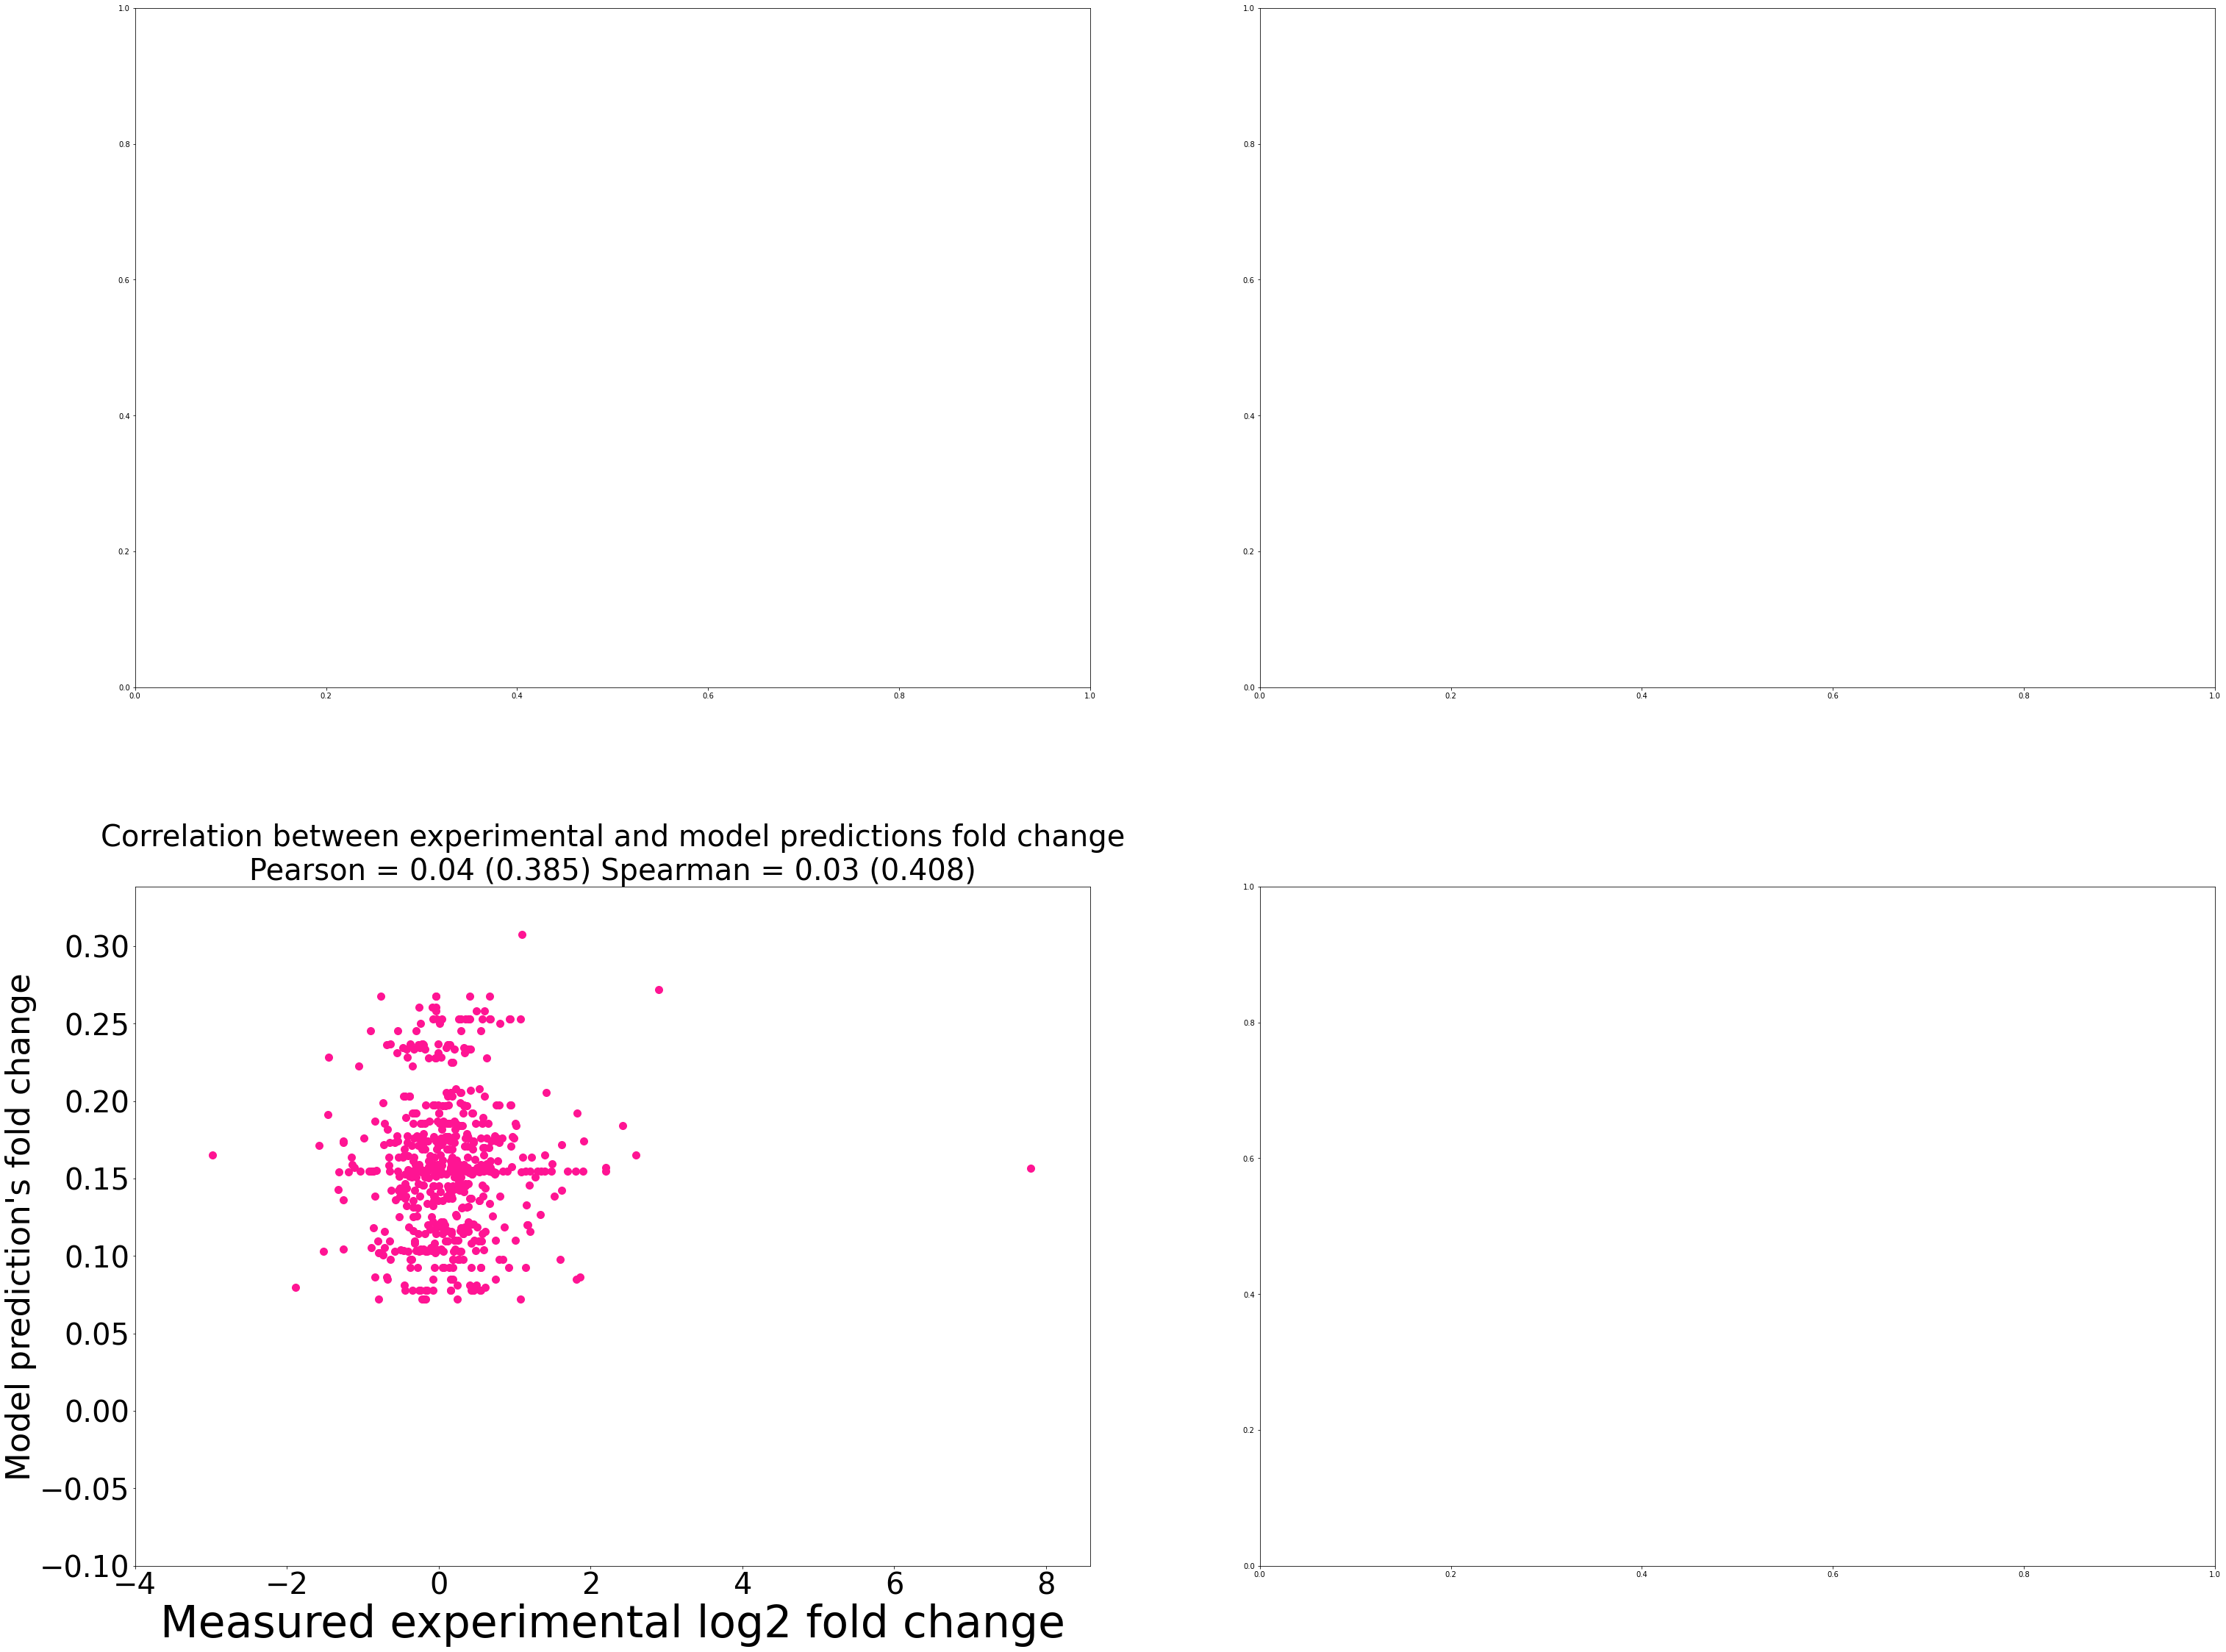

HER2 0.02847812882860373 0.4914212384827885 -7


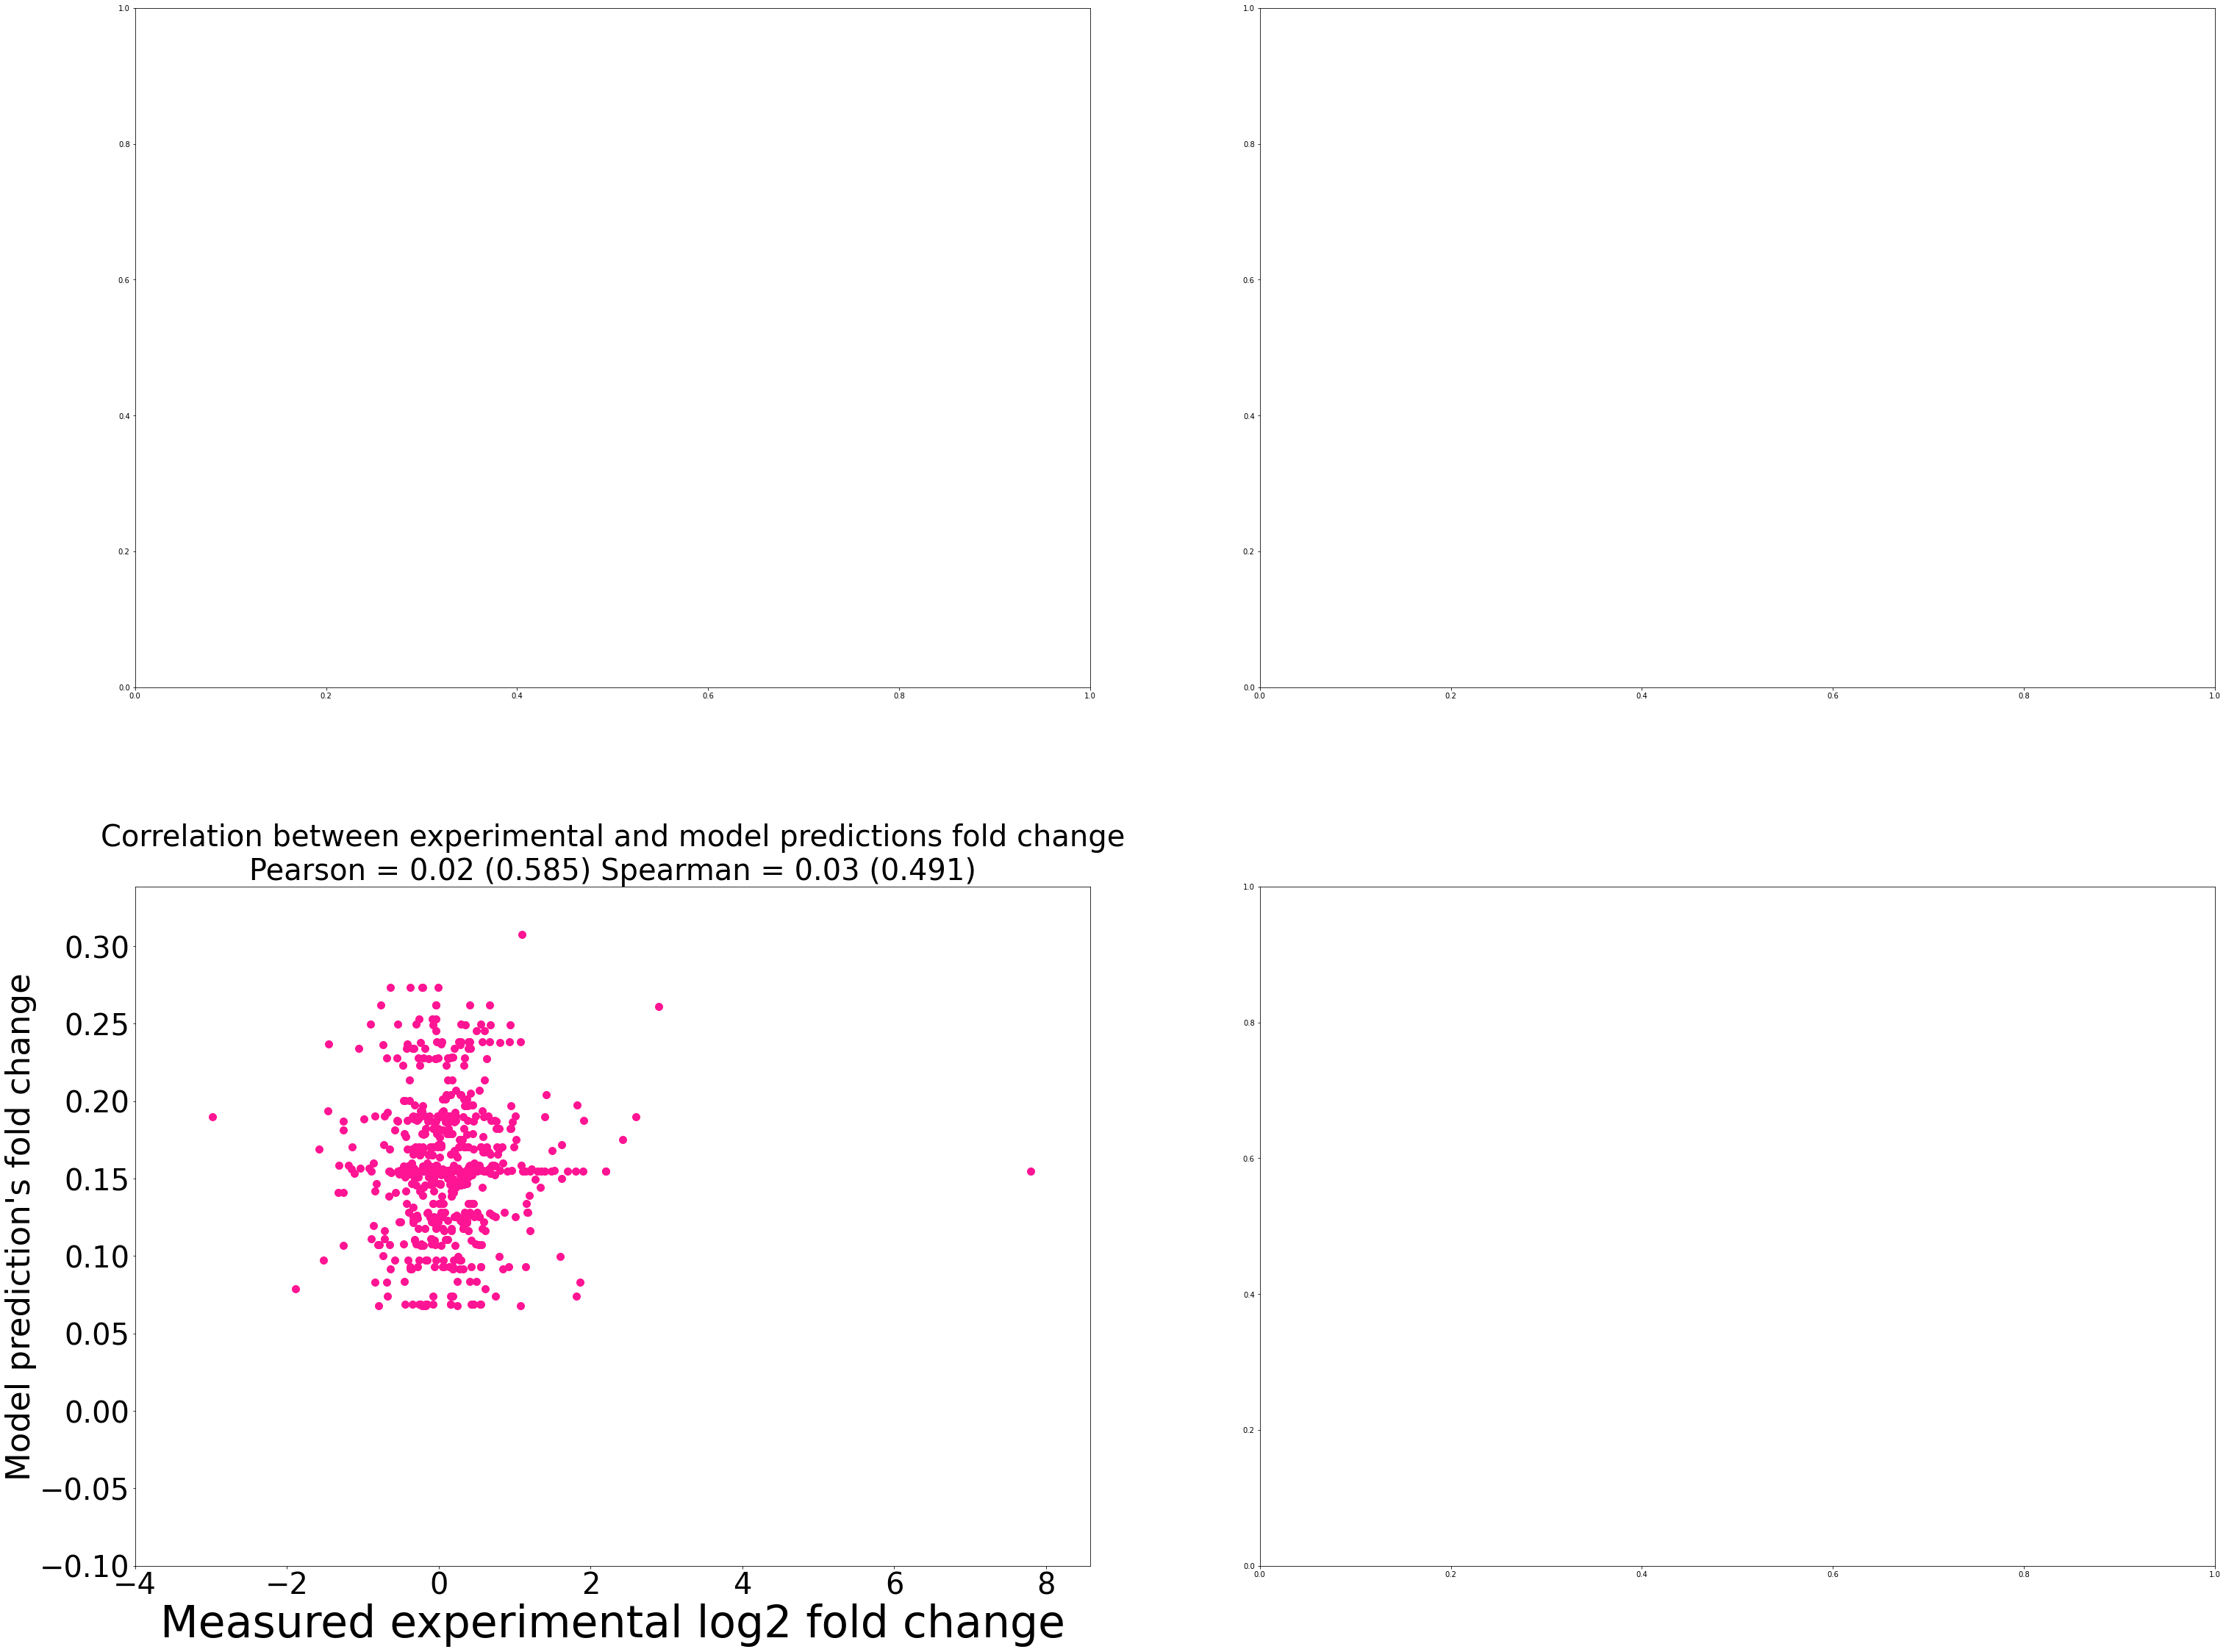

HER2 0.0454041035310454 0.2724944944904847 -6


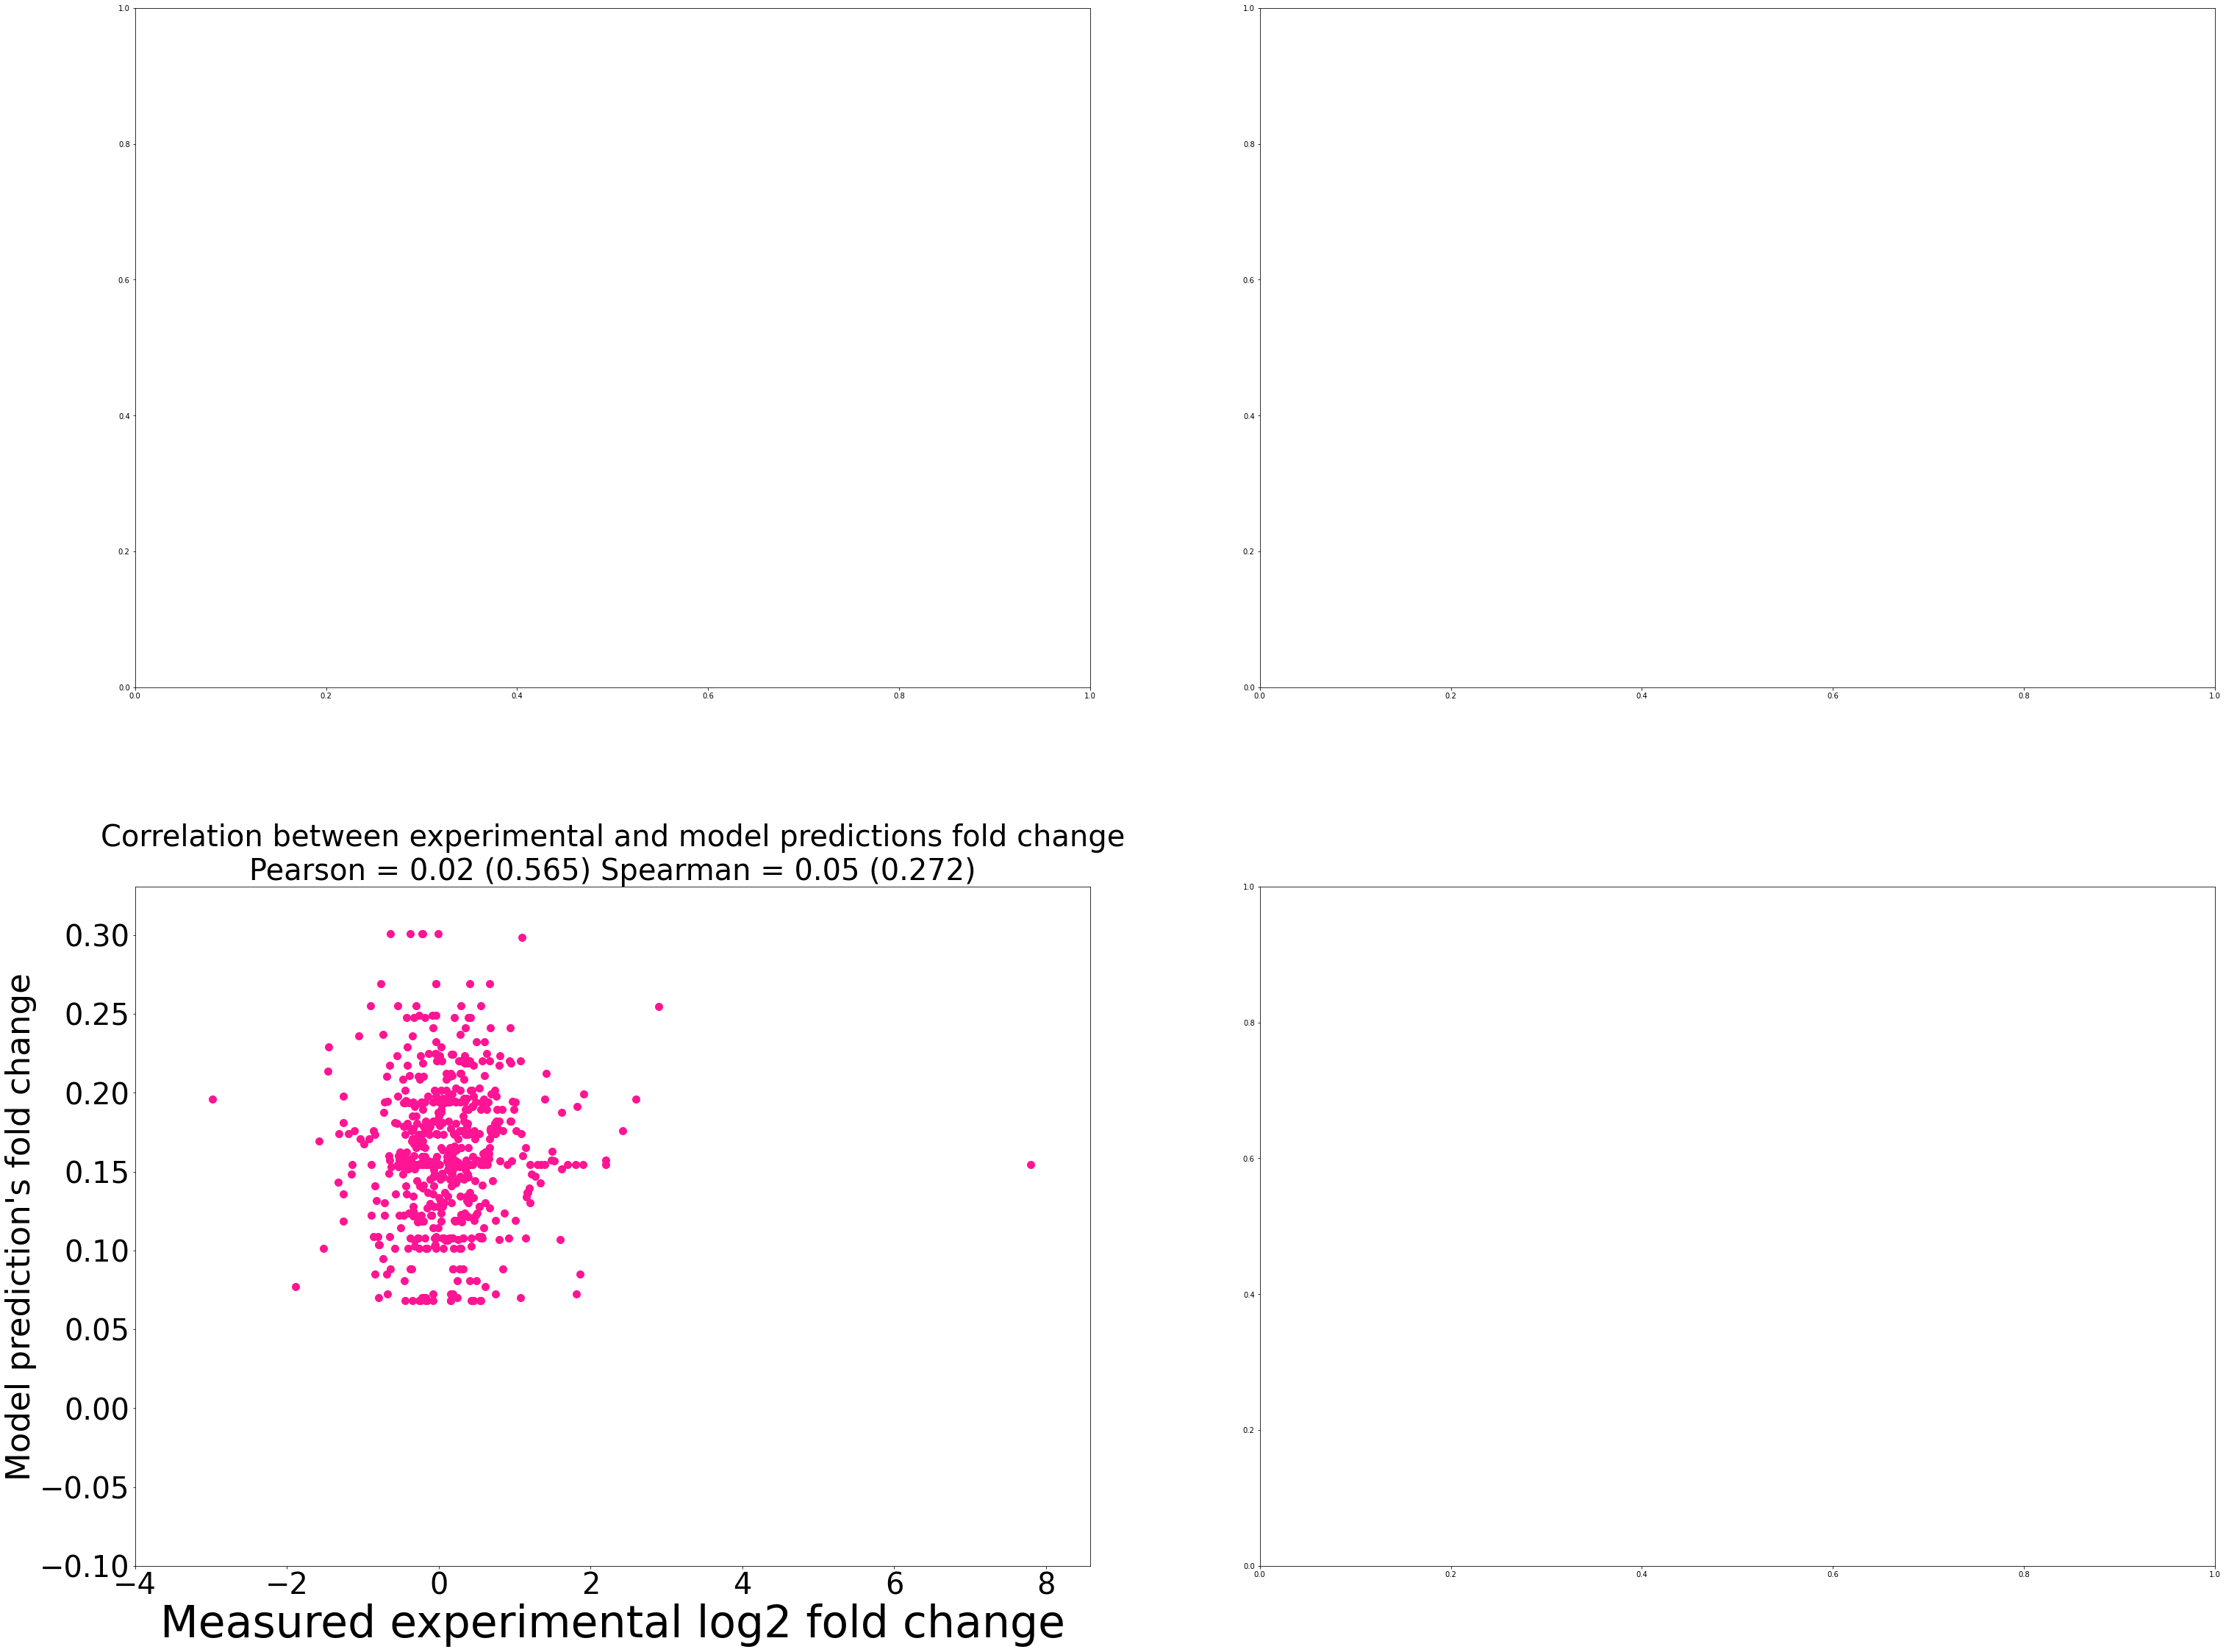

HER2 0.05406293452768106 0.1912512359312686 -5


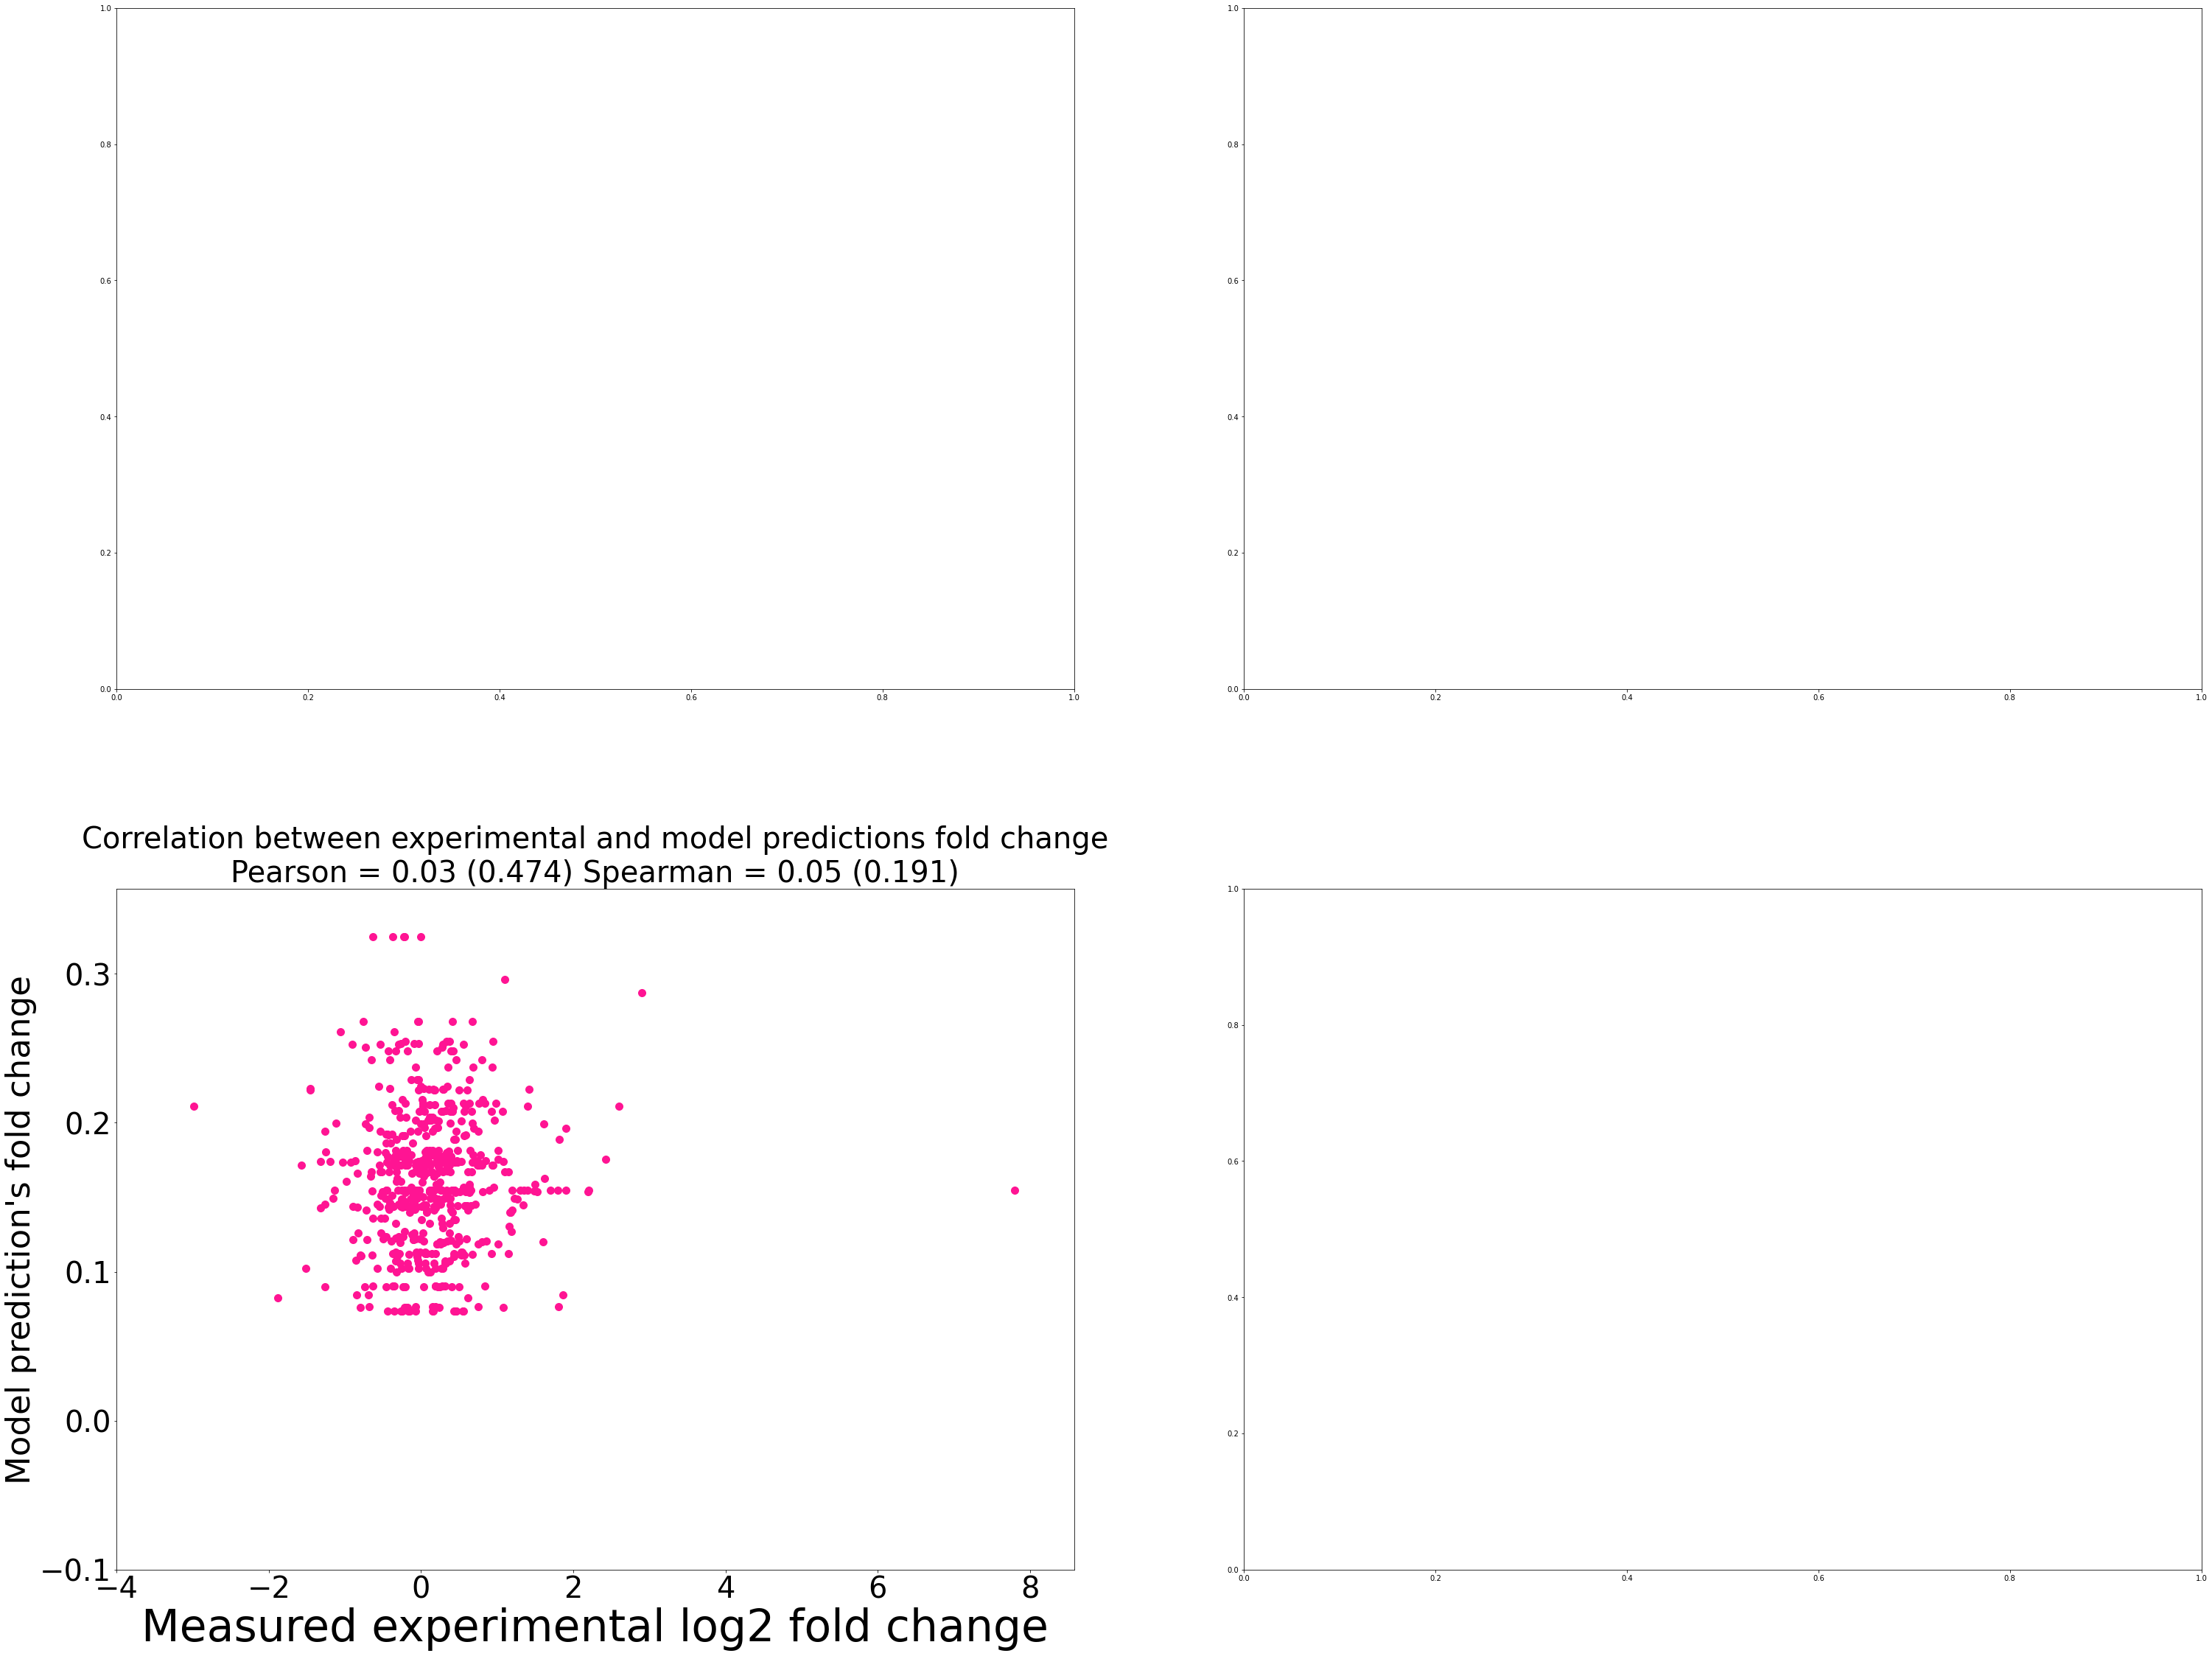

HER2 0.06572225694978197 0.111995169865867 -4


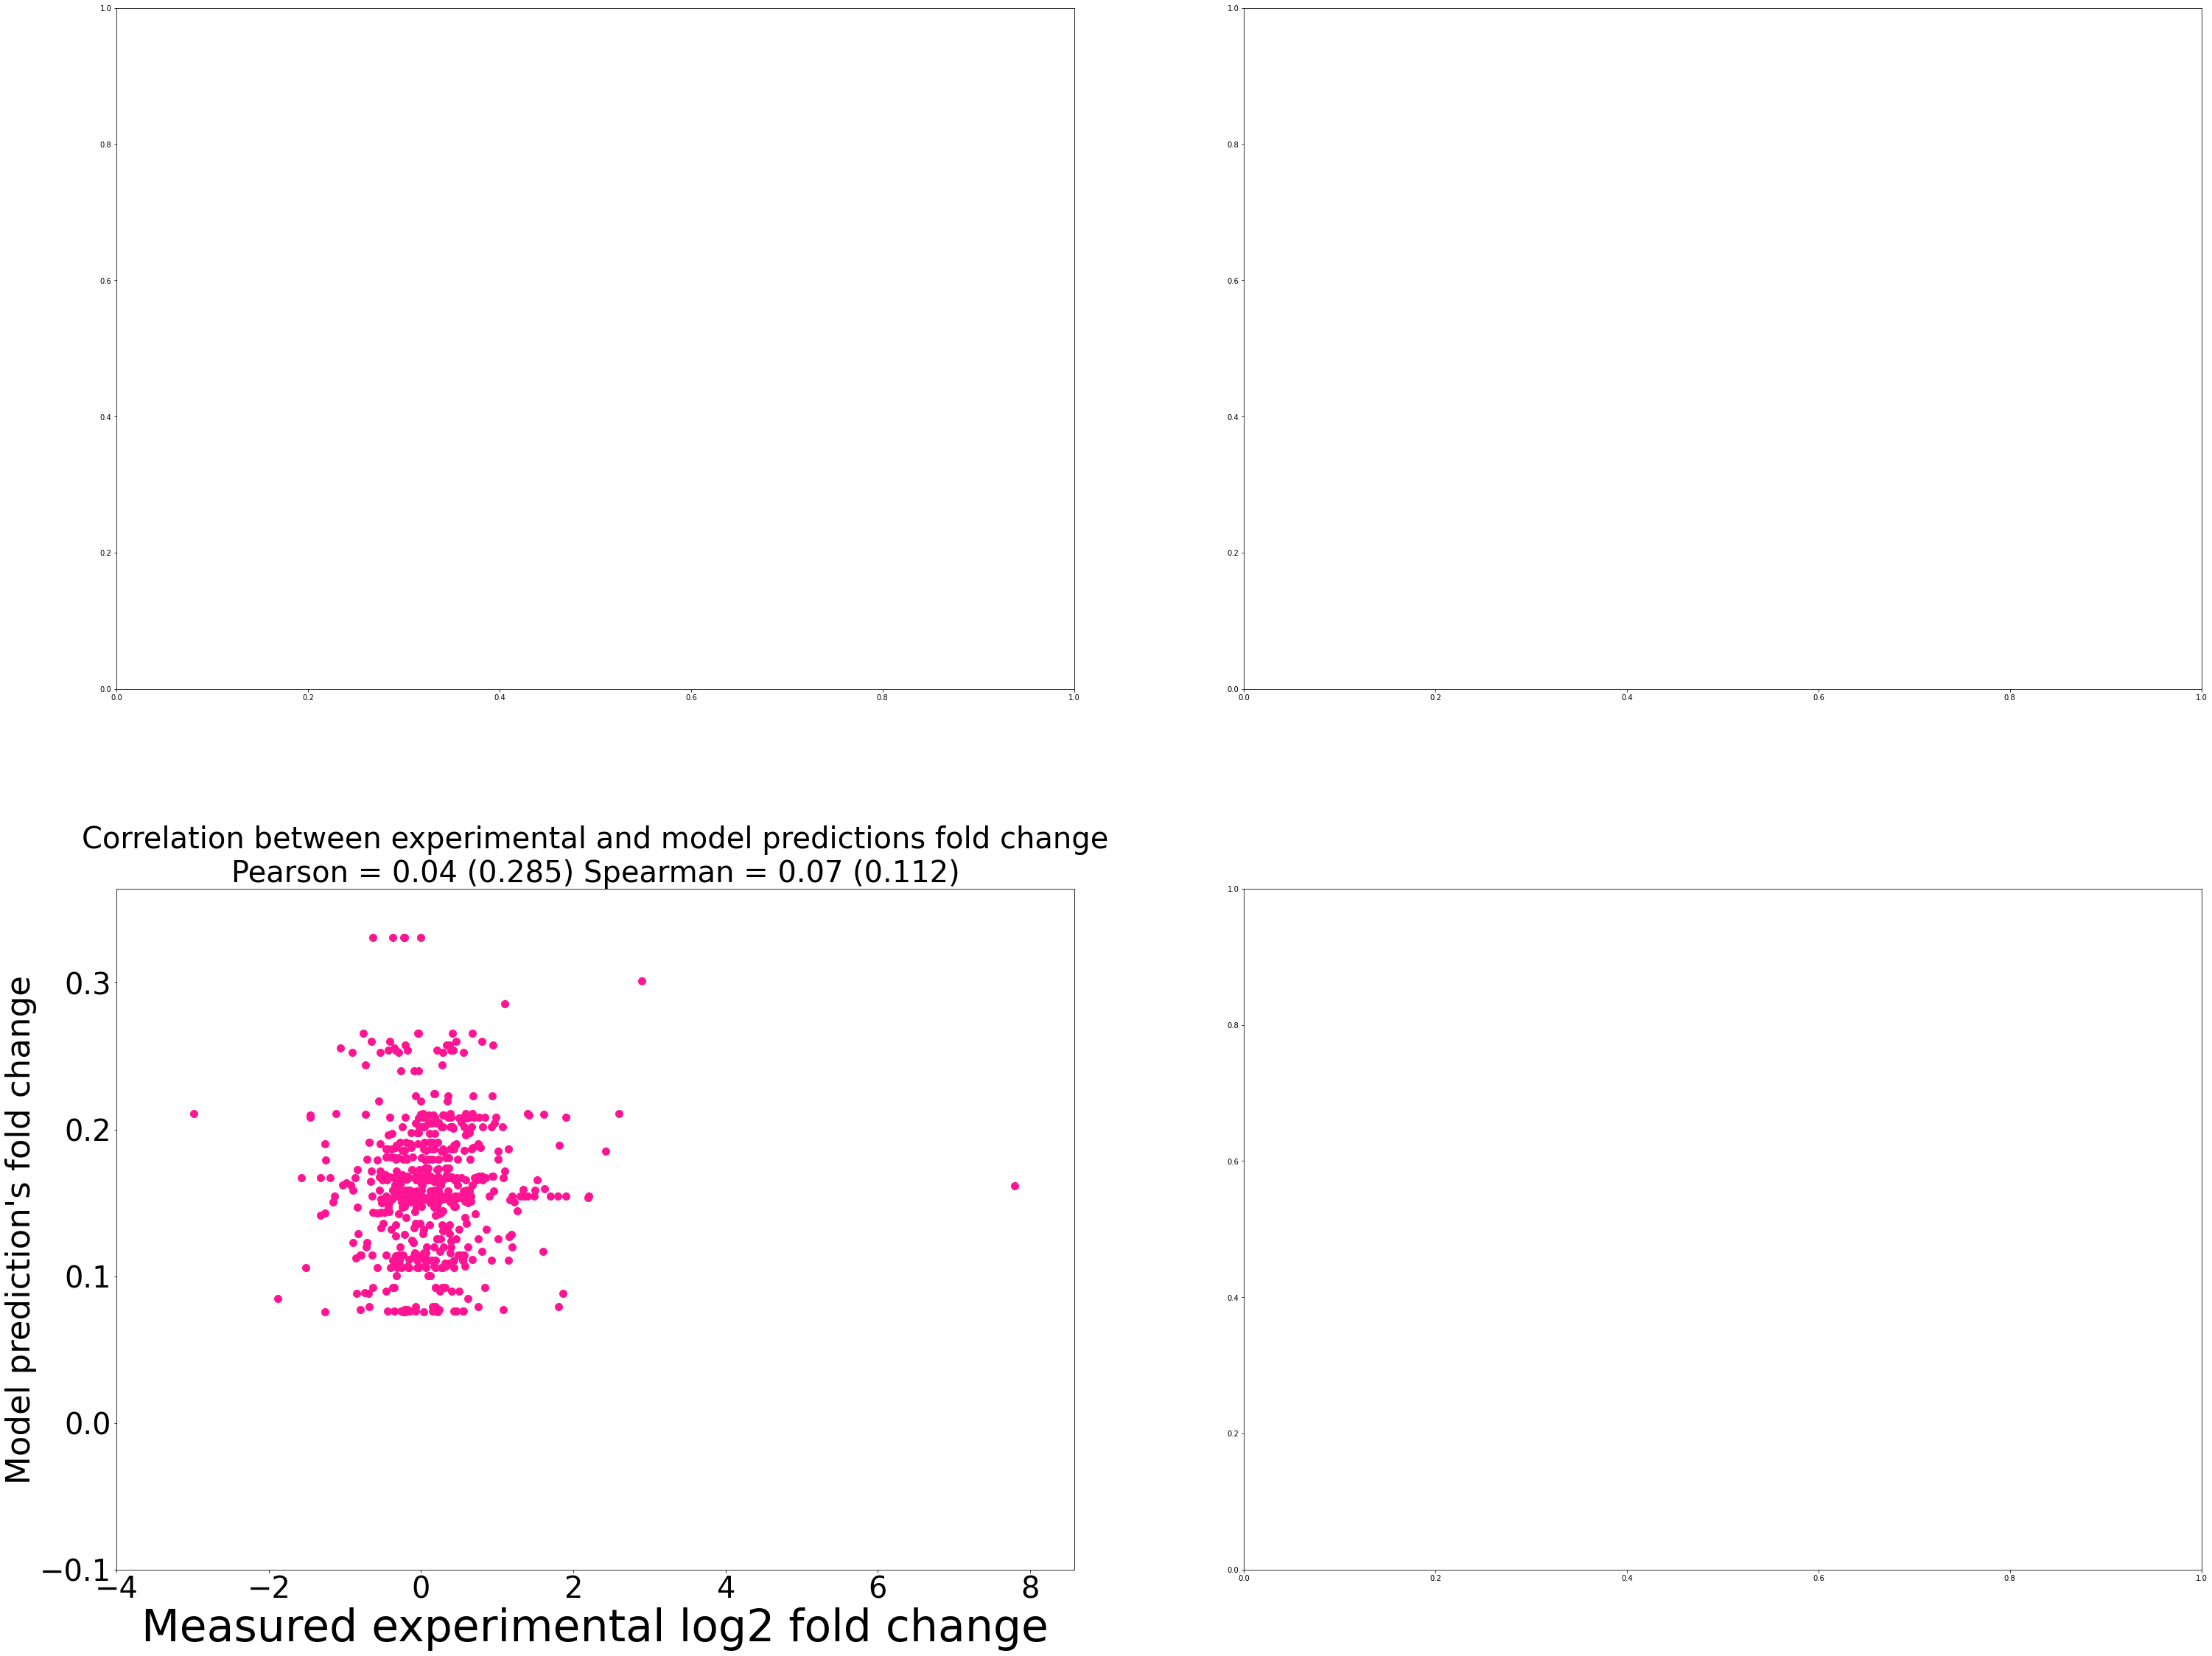

HER2 0.07493237180116079 0.06989408043241051 -3


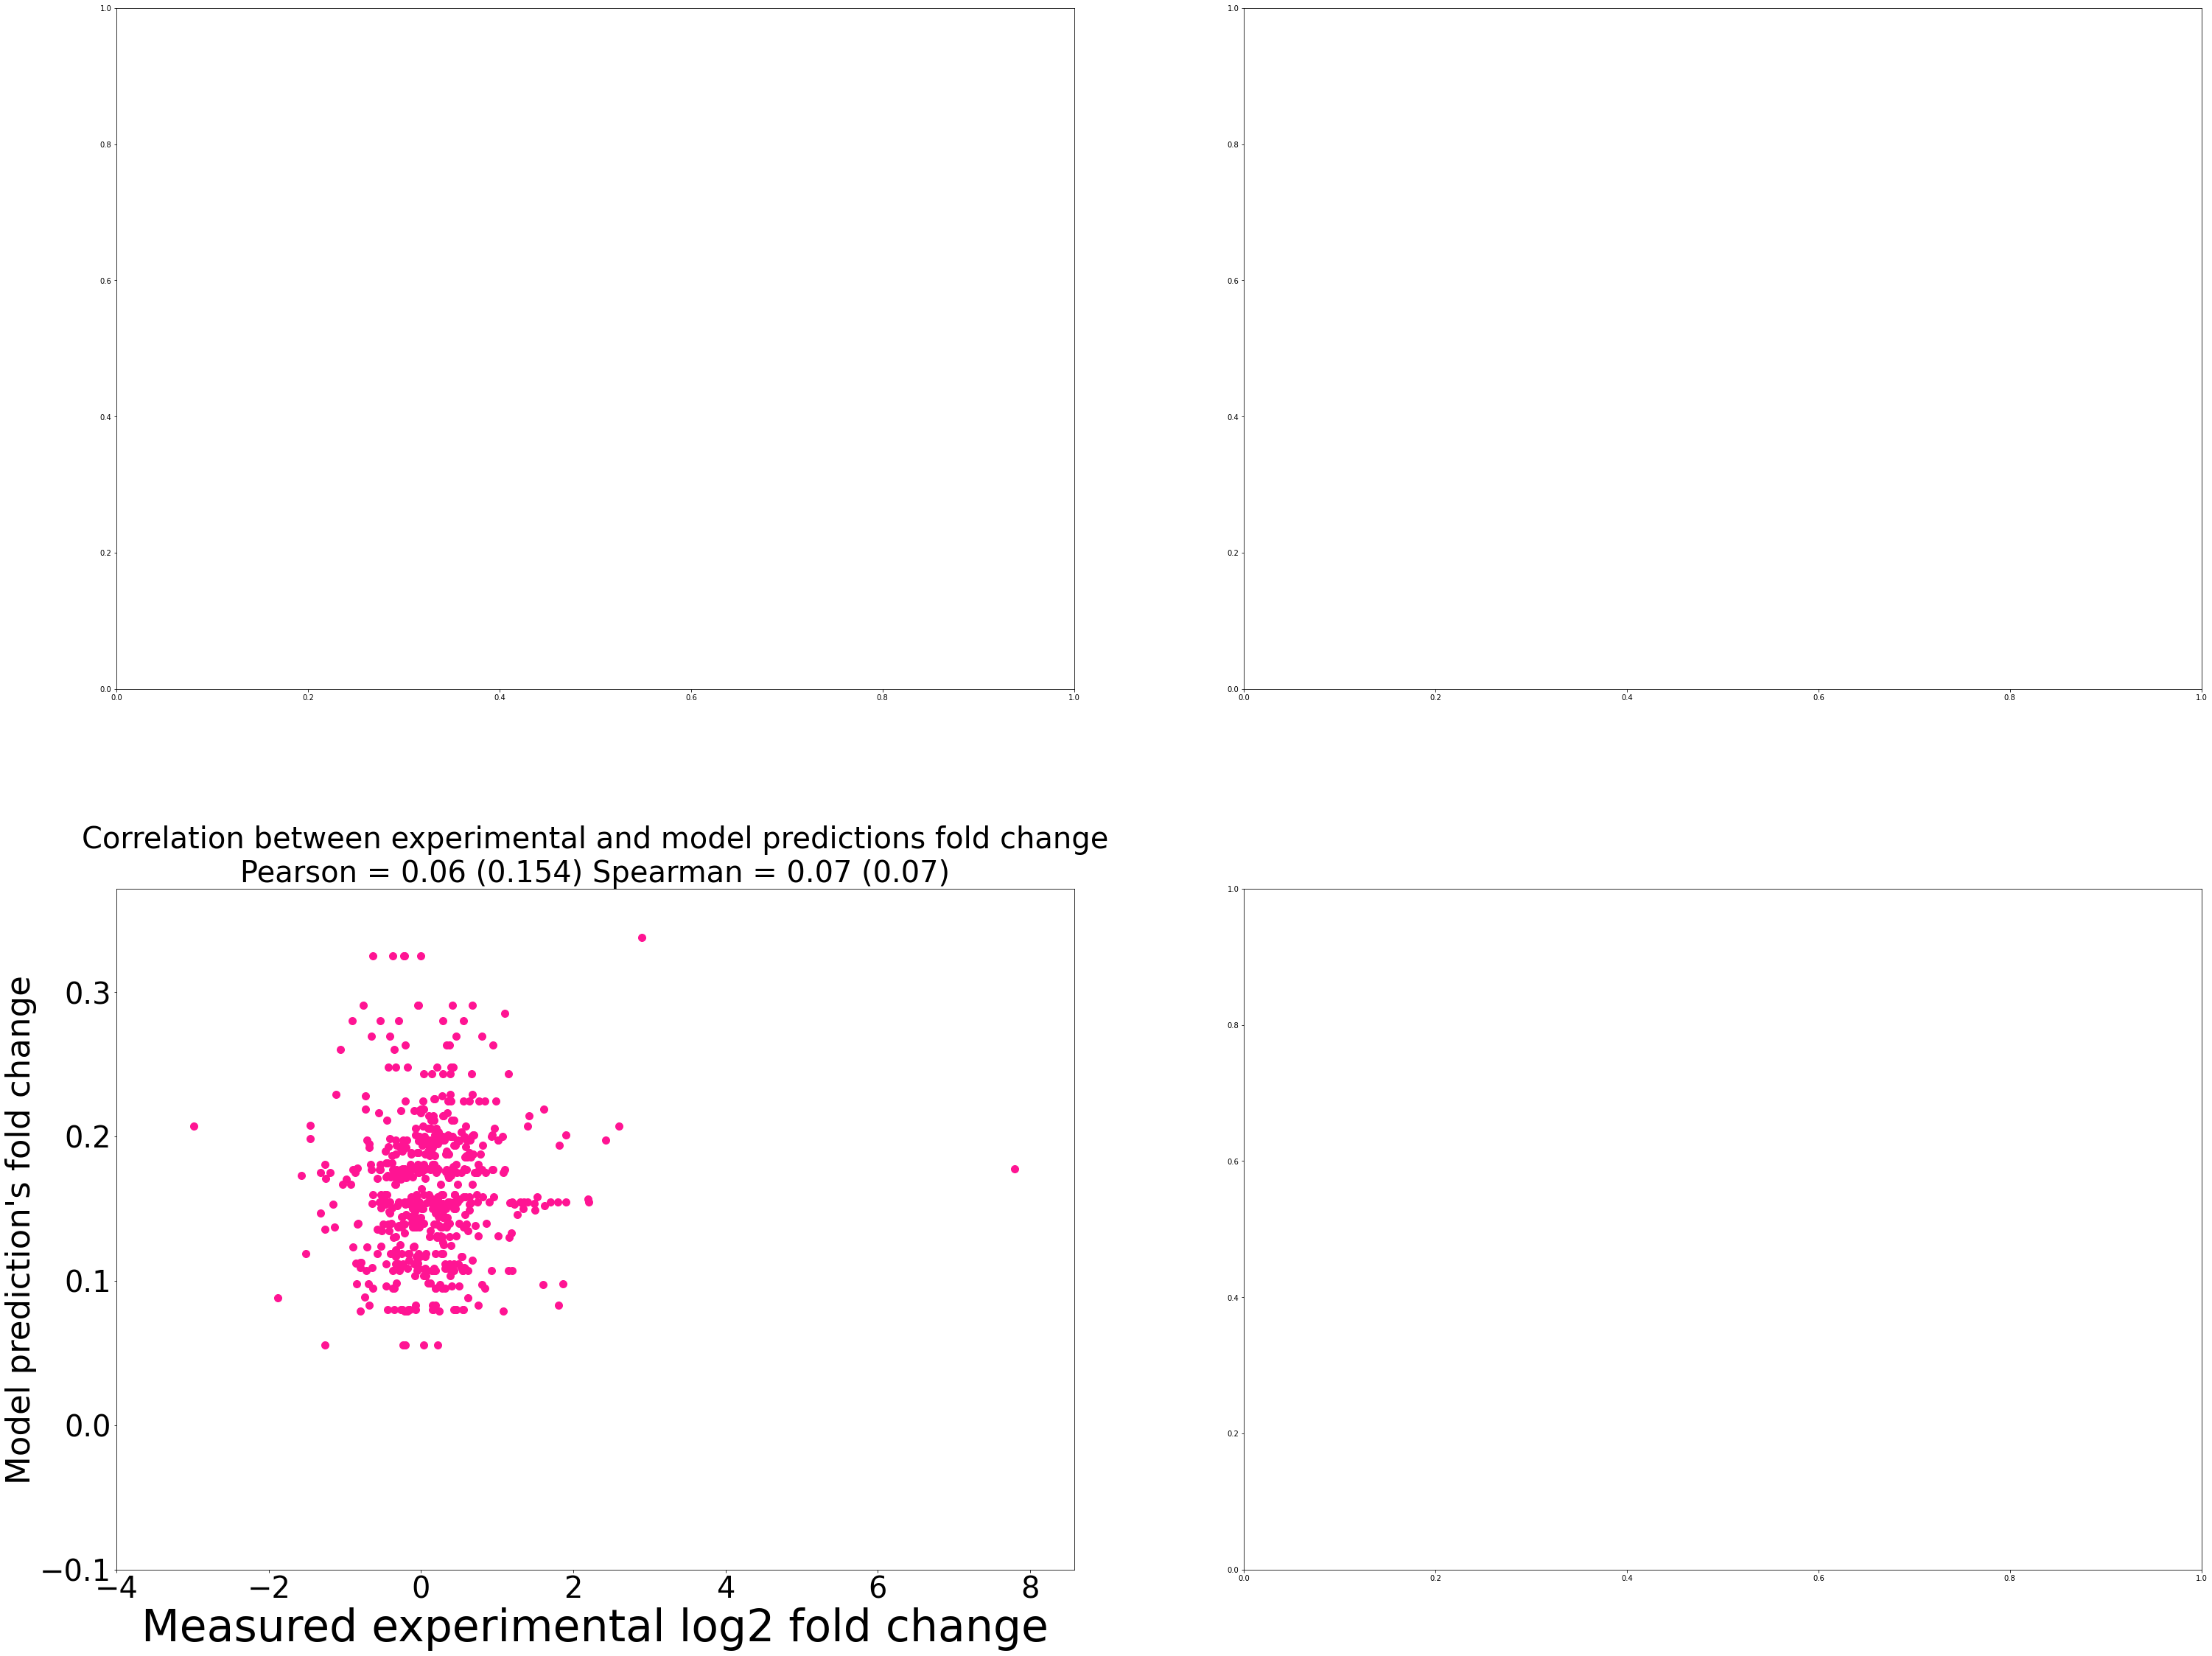

HER2 0.07881598033462511 0.05654310599177577 -2


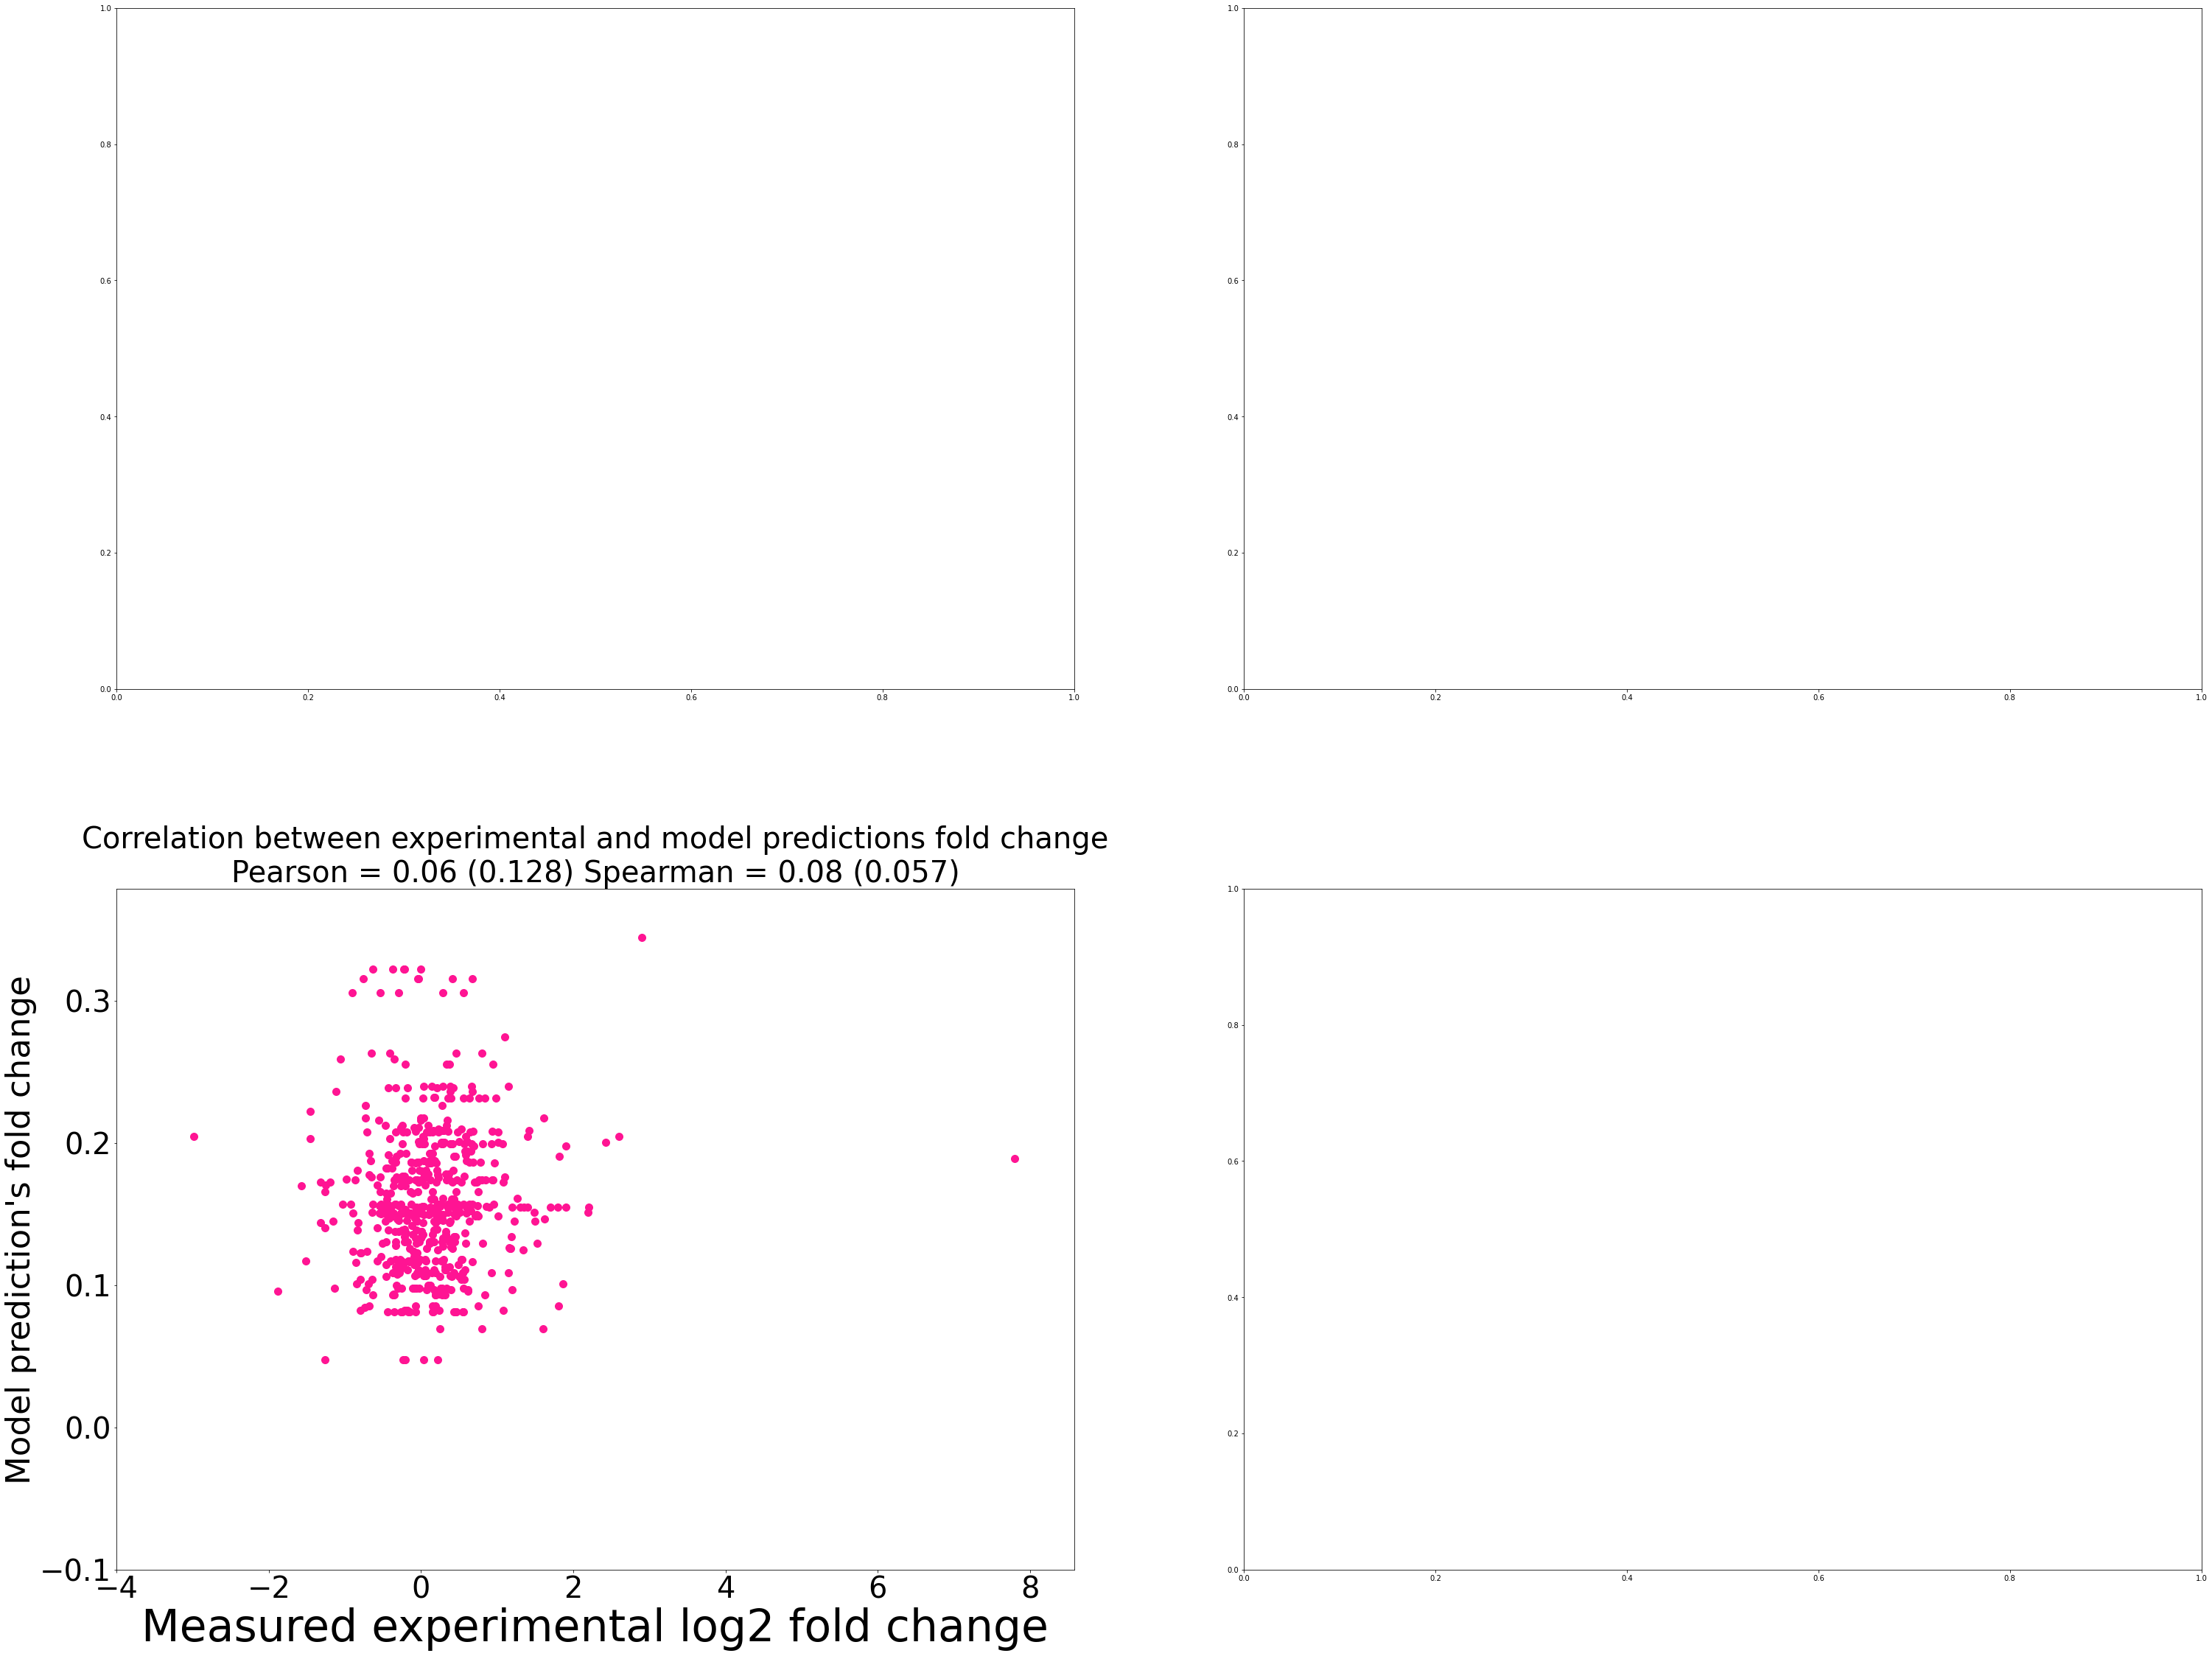

HER2 0.06495542629968692 0.11625094468077662 -1


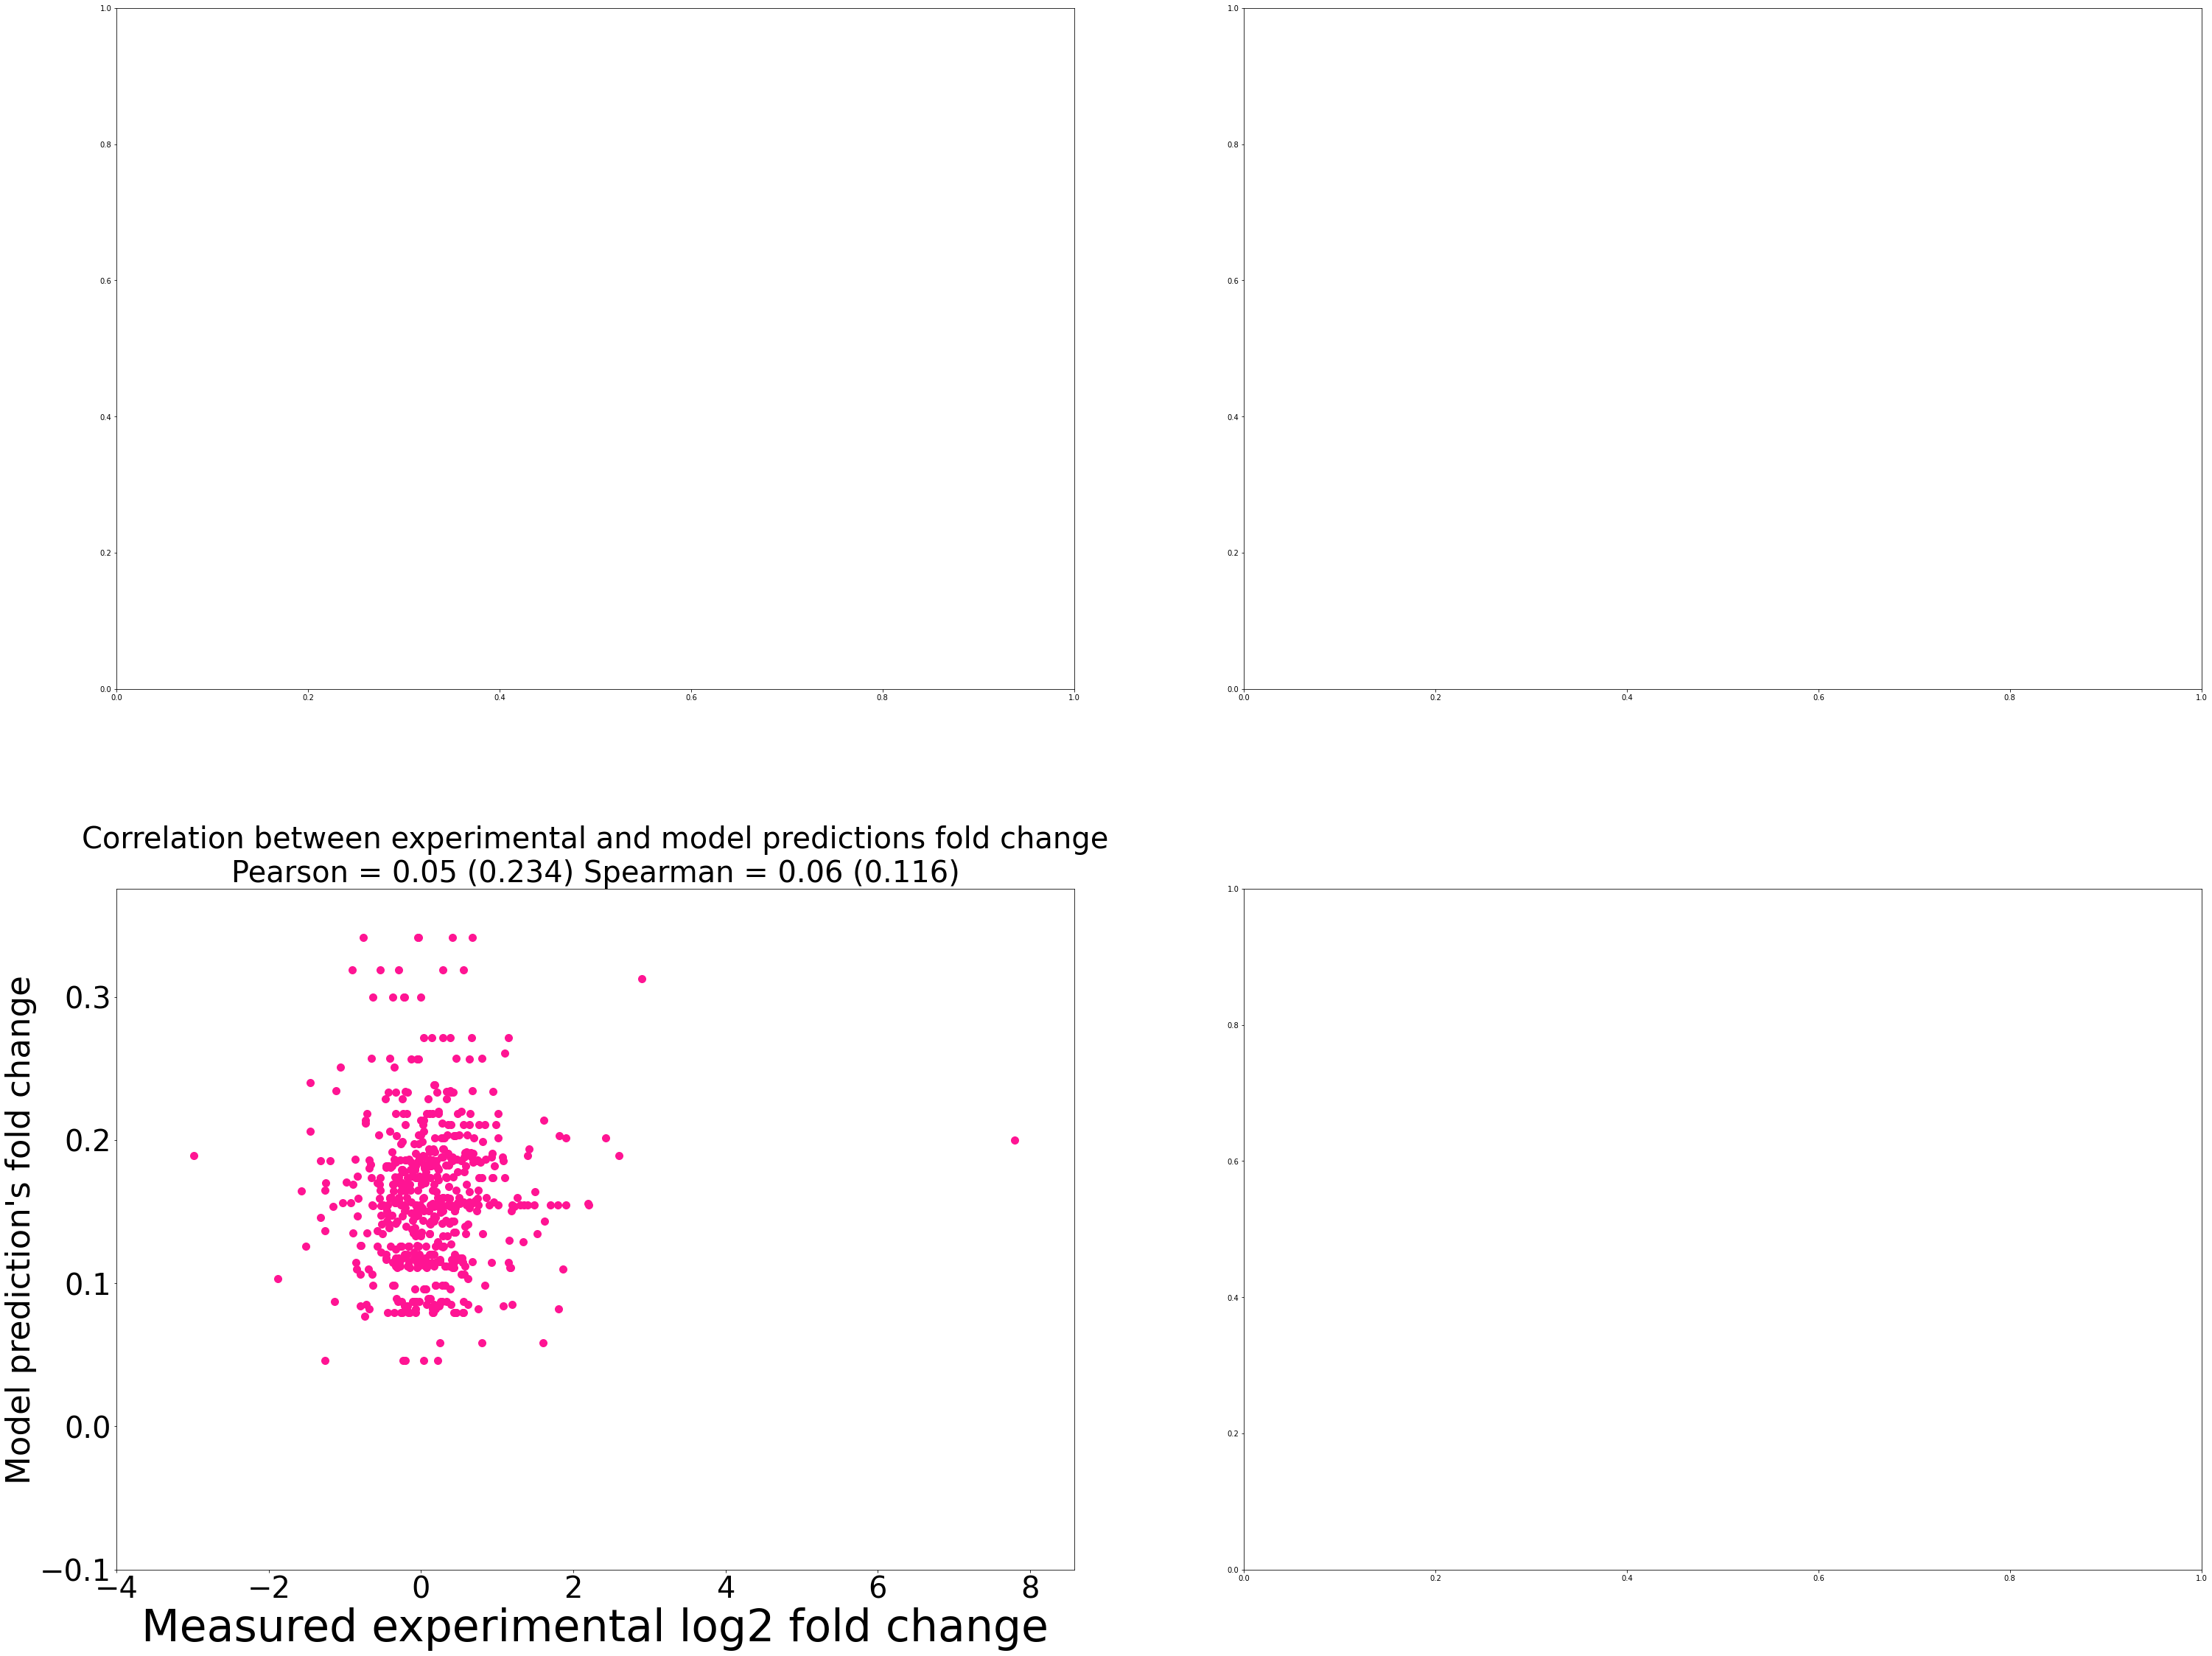

HER2 0.05486020373022249 0.18477737537414773 0


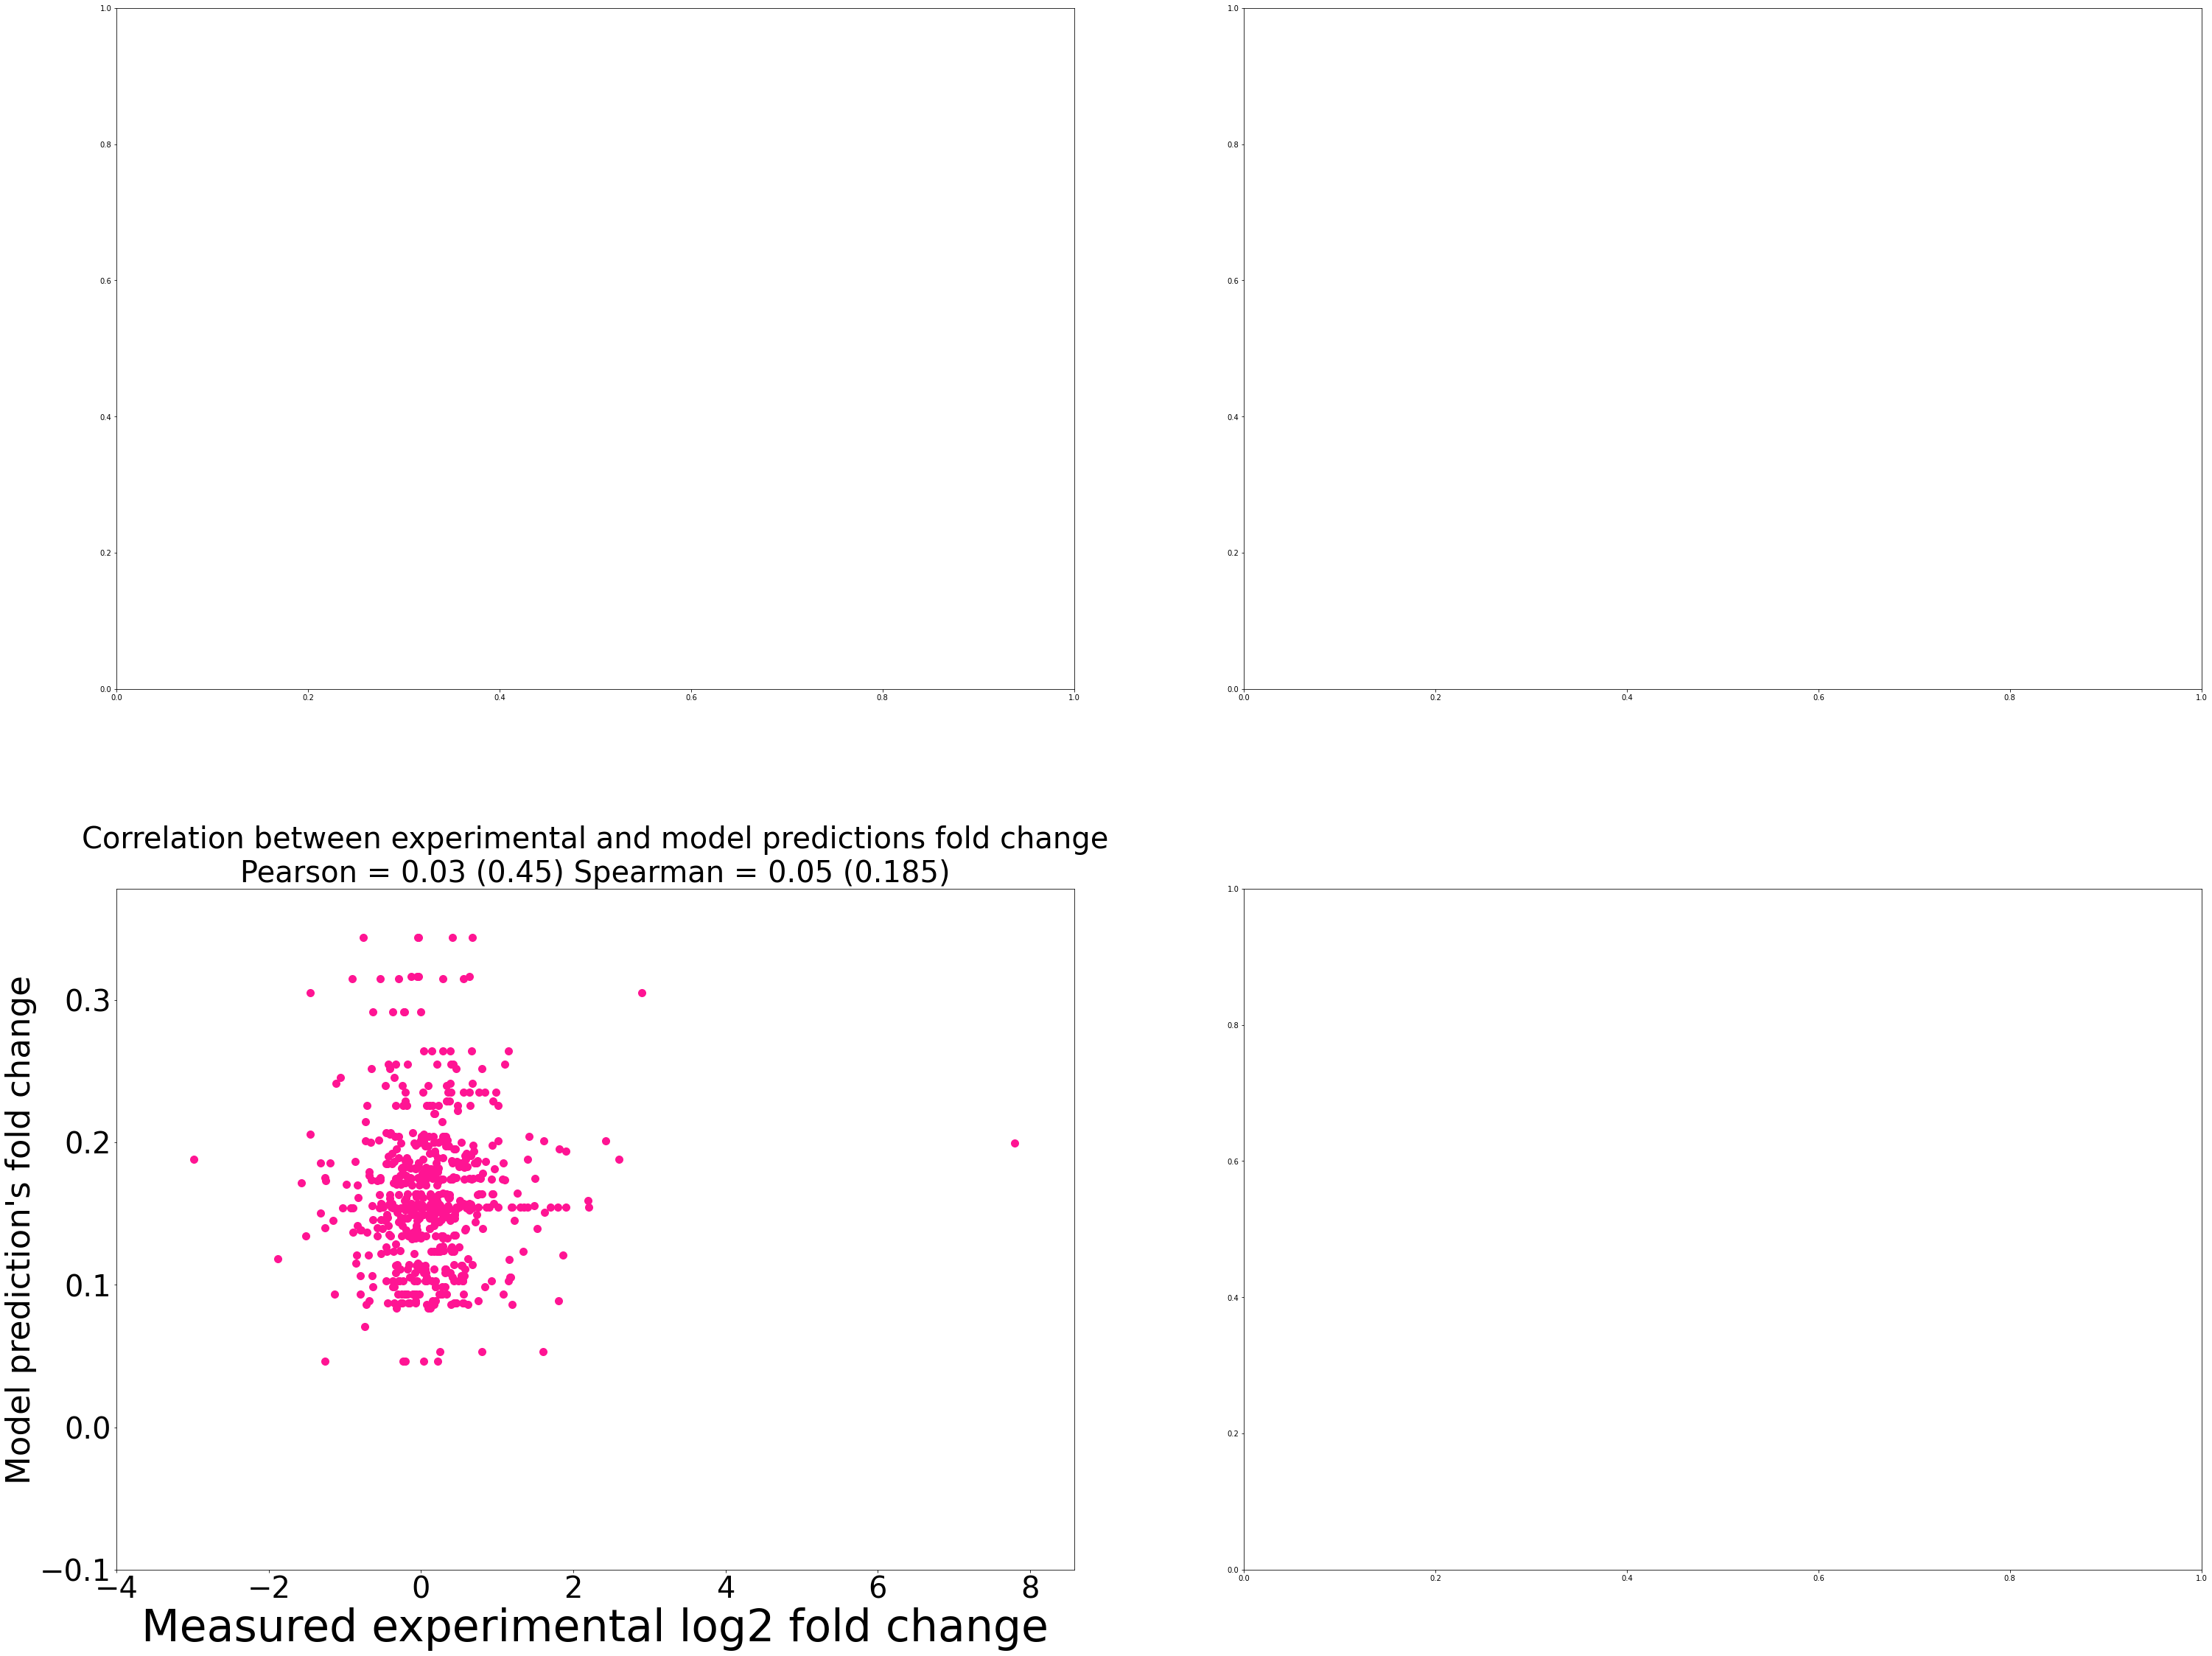

HER2 0.04245450238580014 0.3048996346179989 1


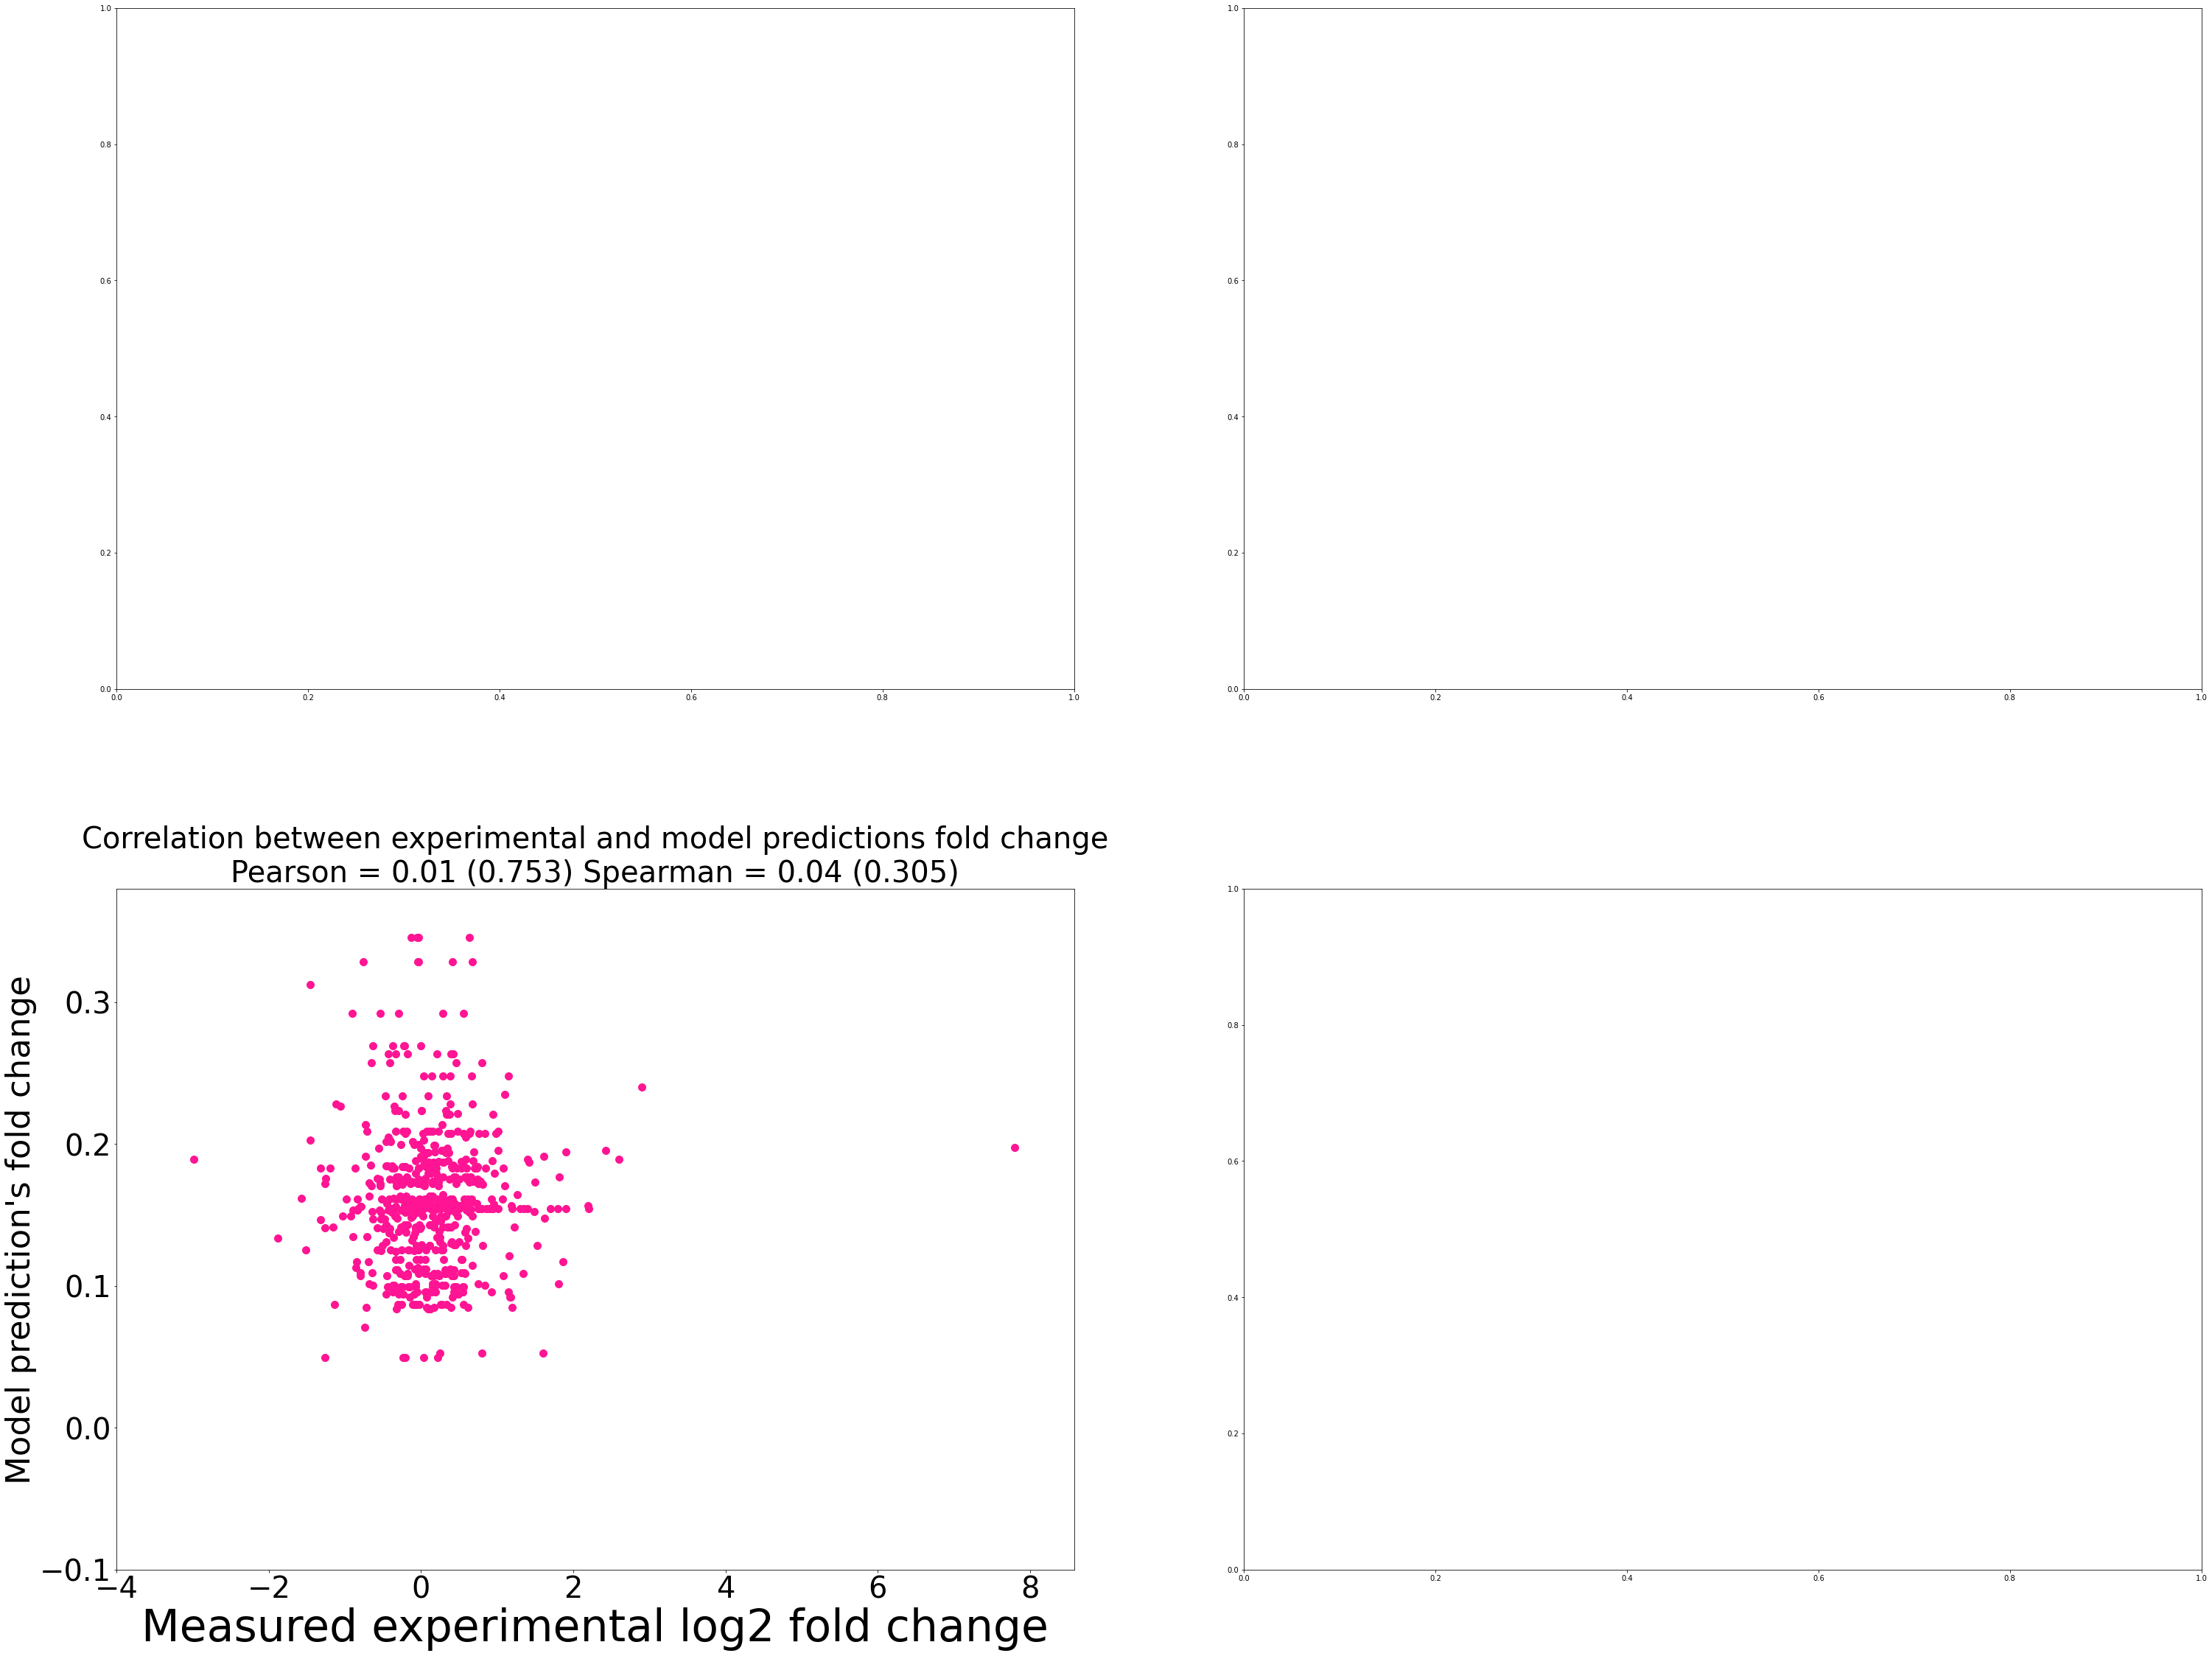

HER2 0.024543941381940663 0.5532034918080189 2


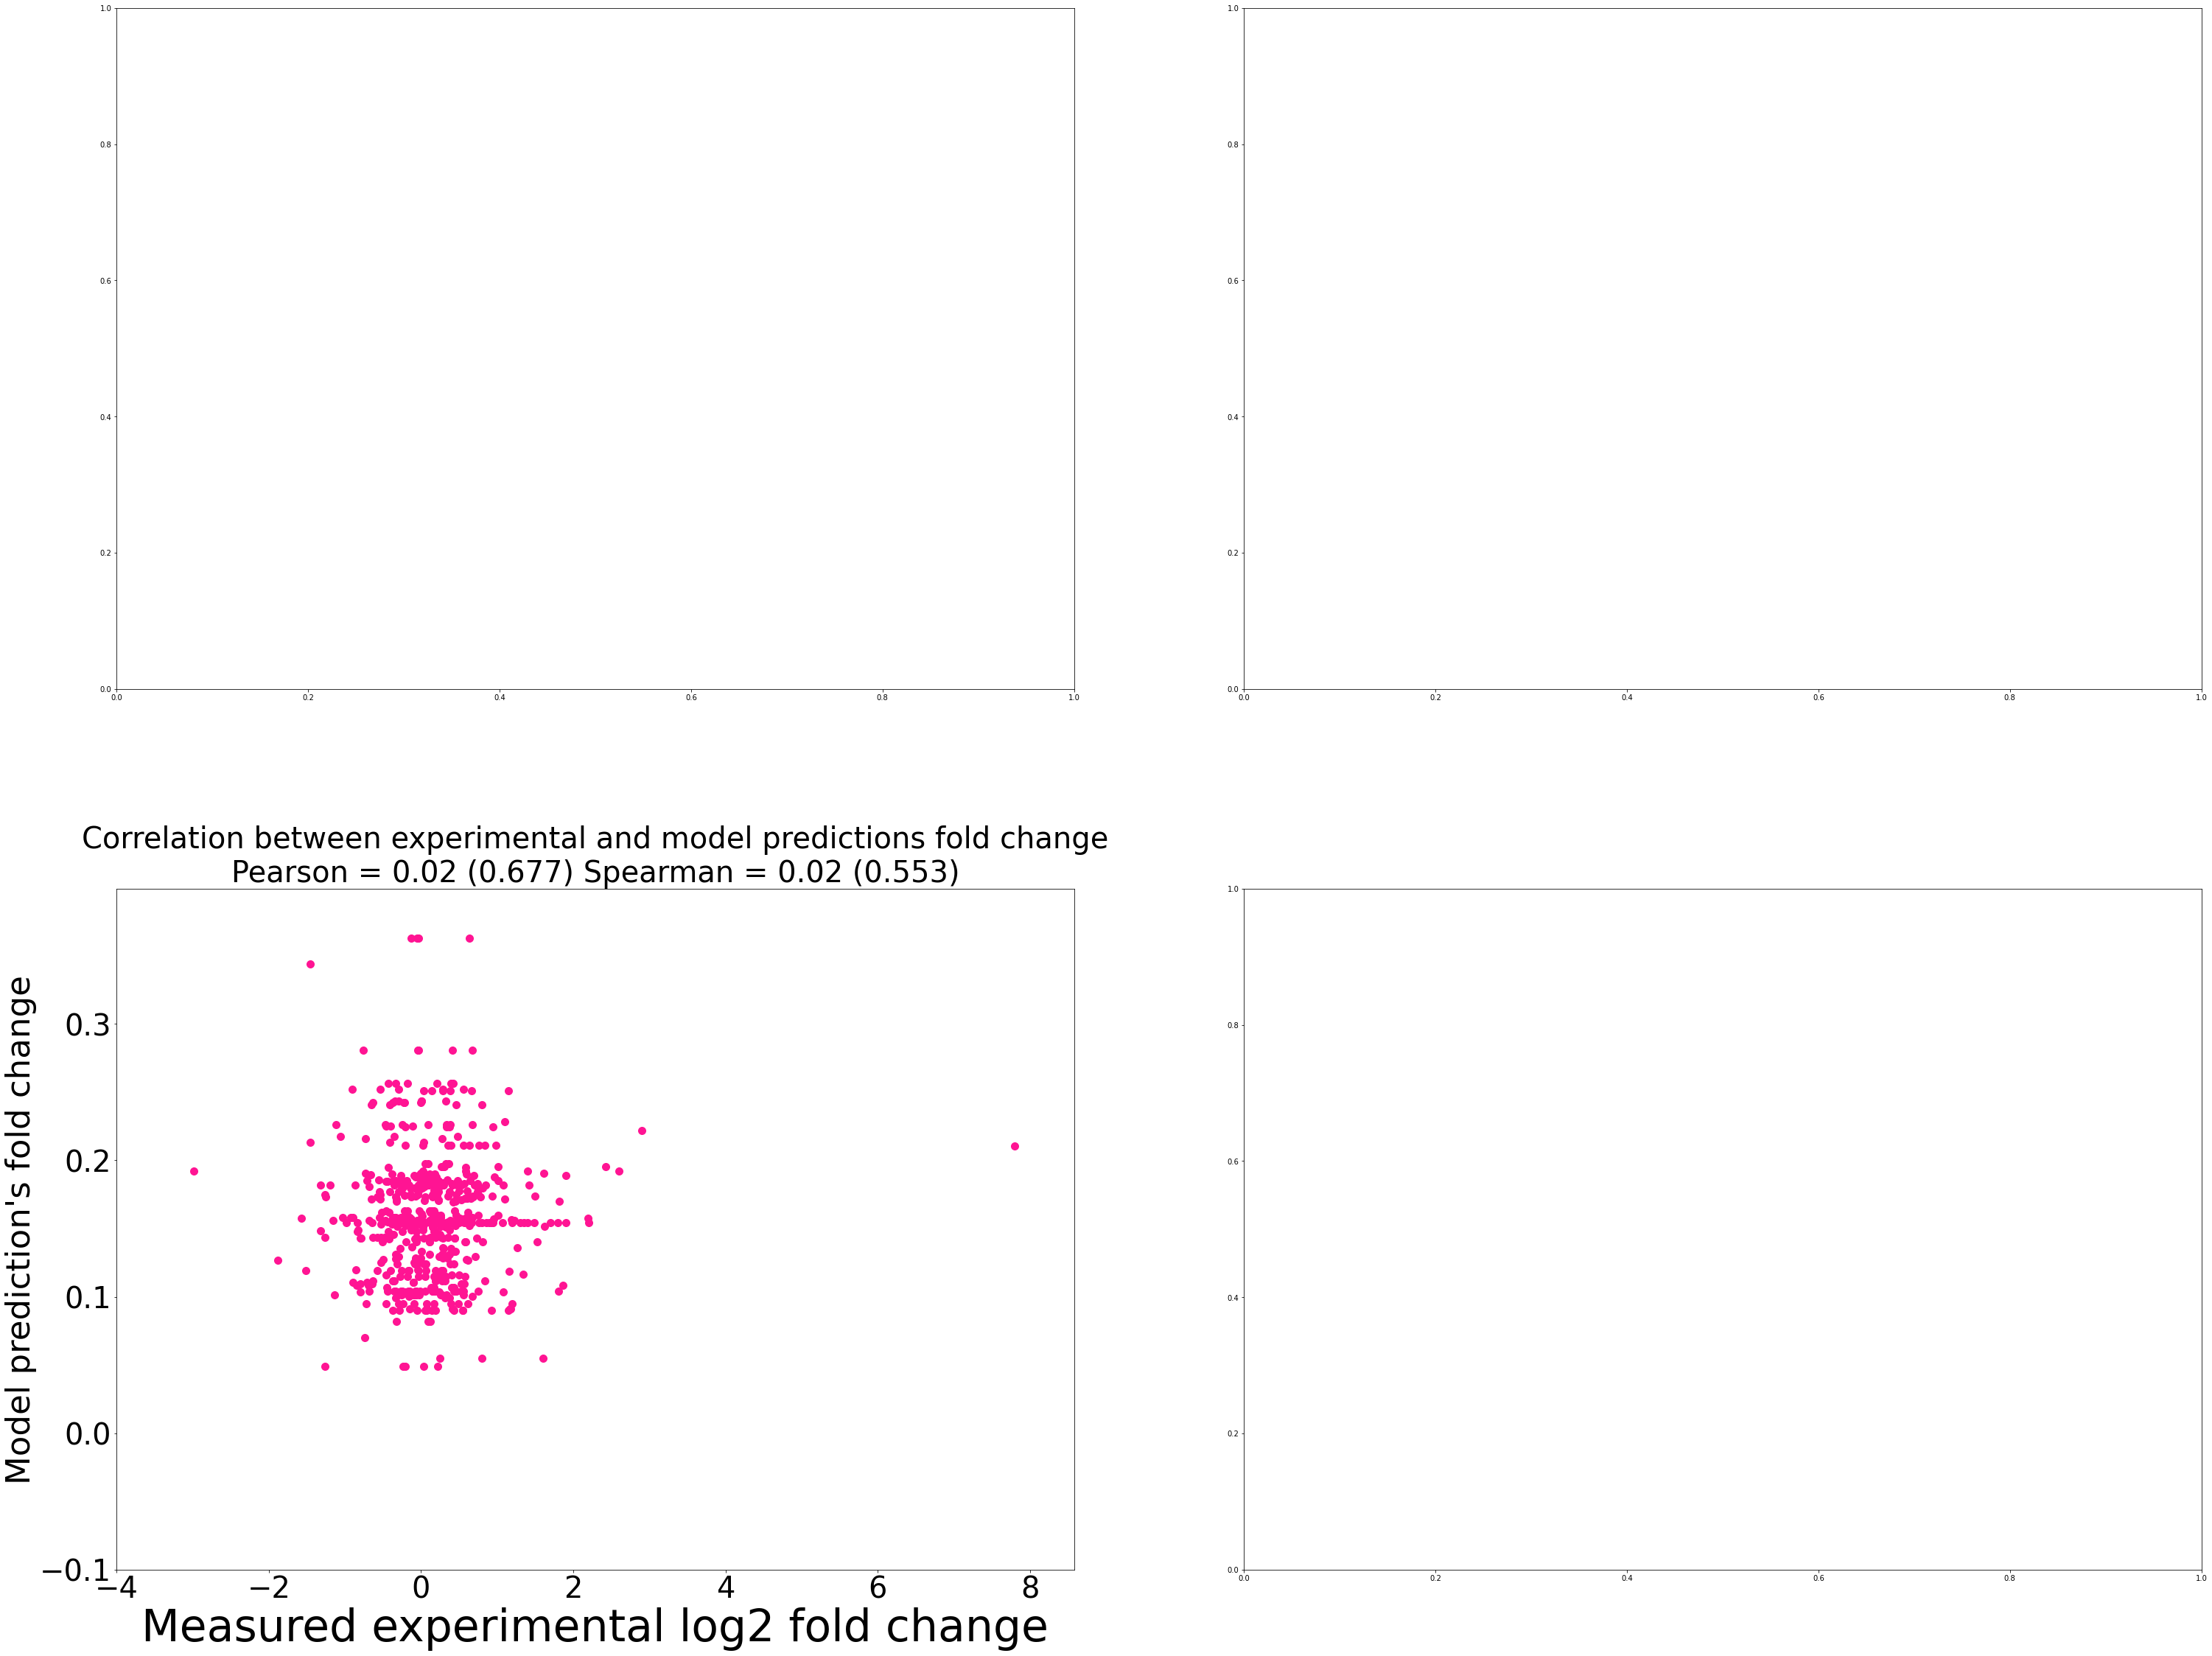

HER2 0.02423159129279693 0.5582665531120099 3


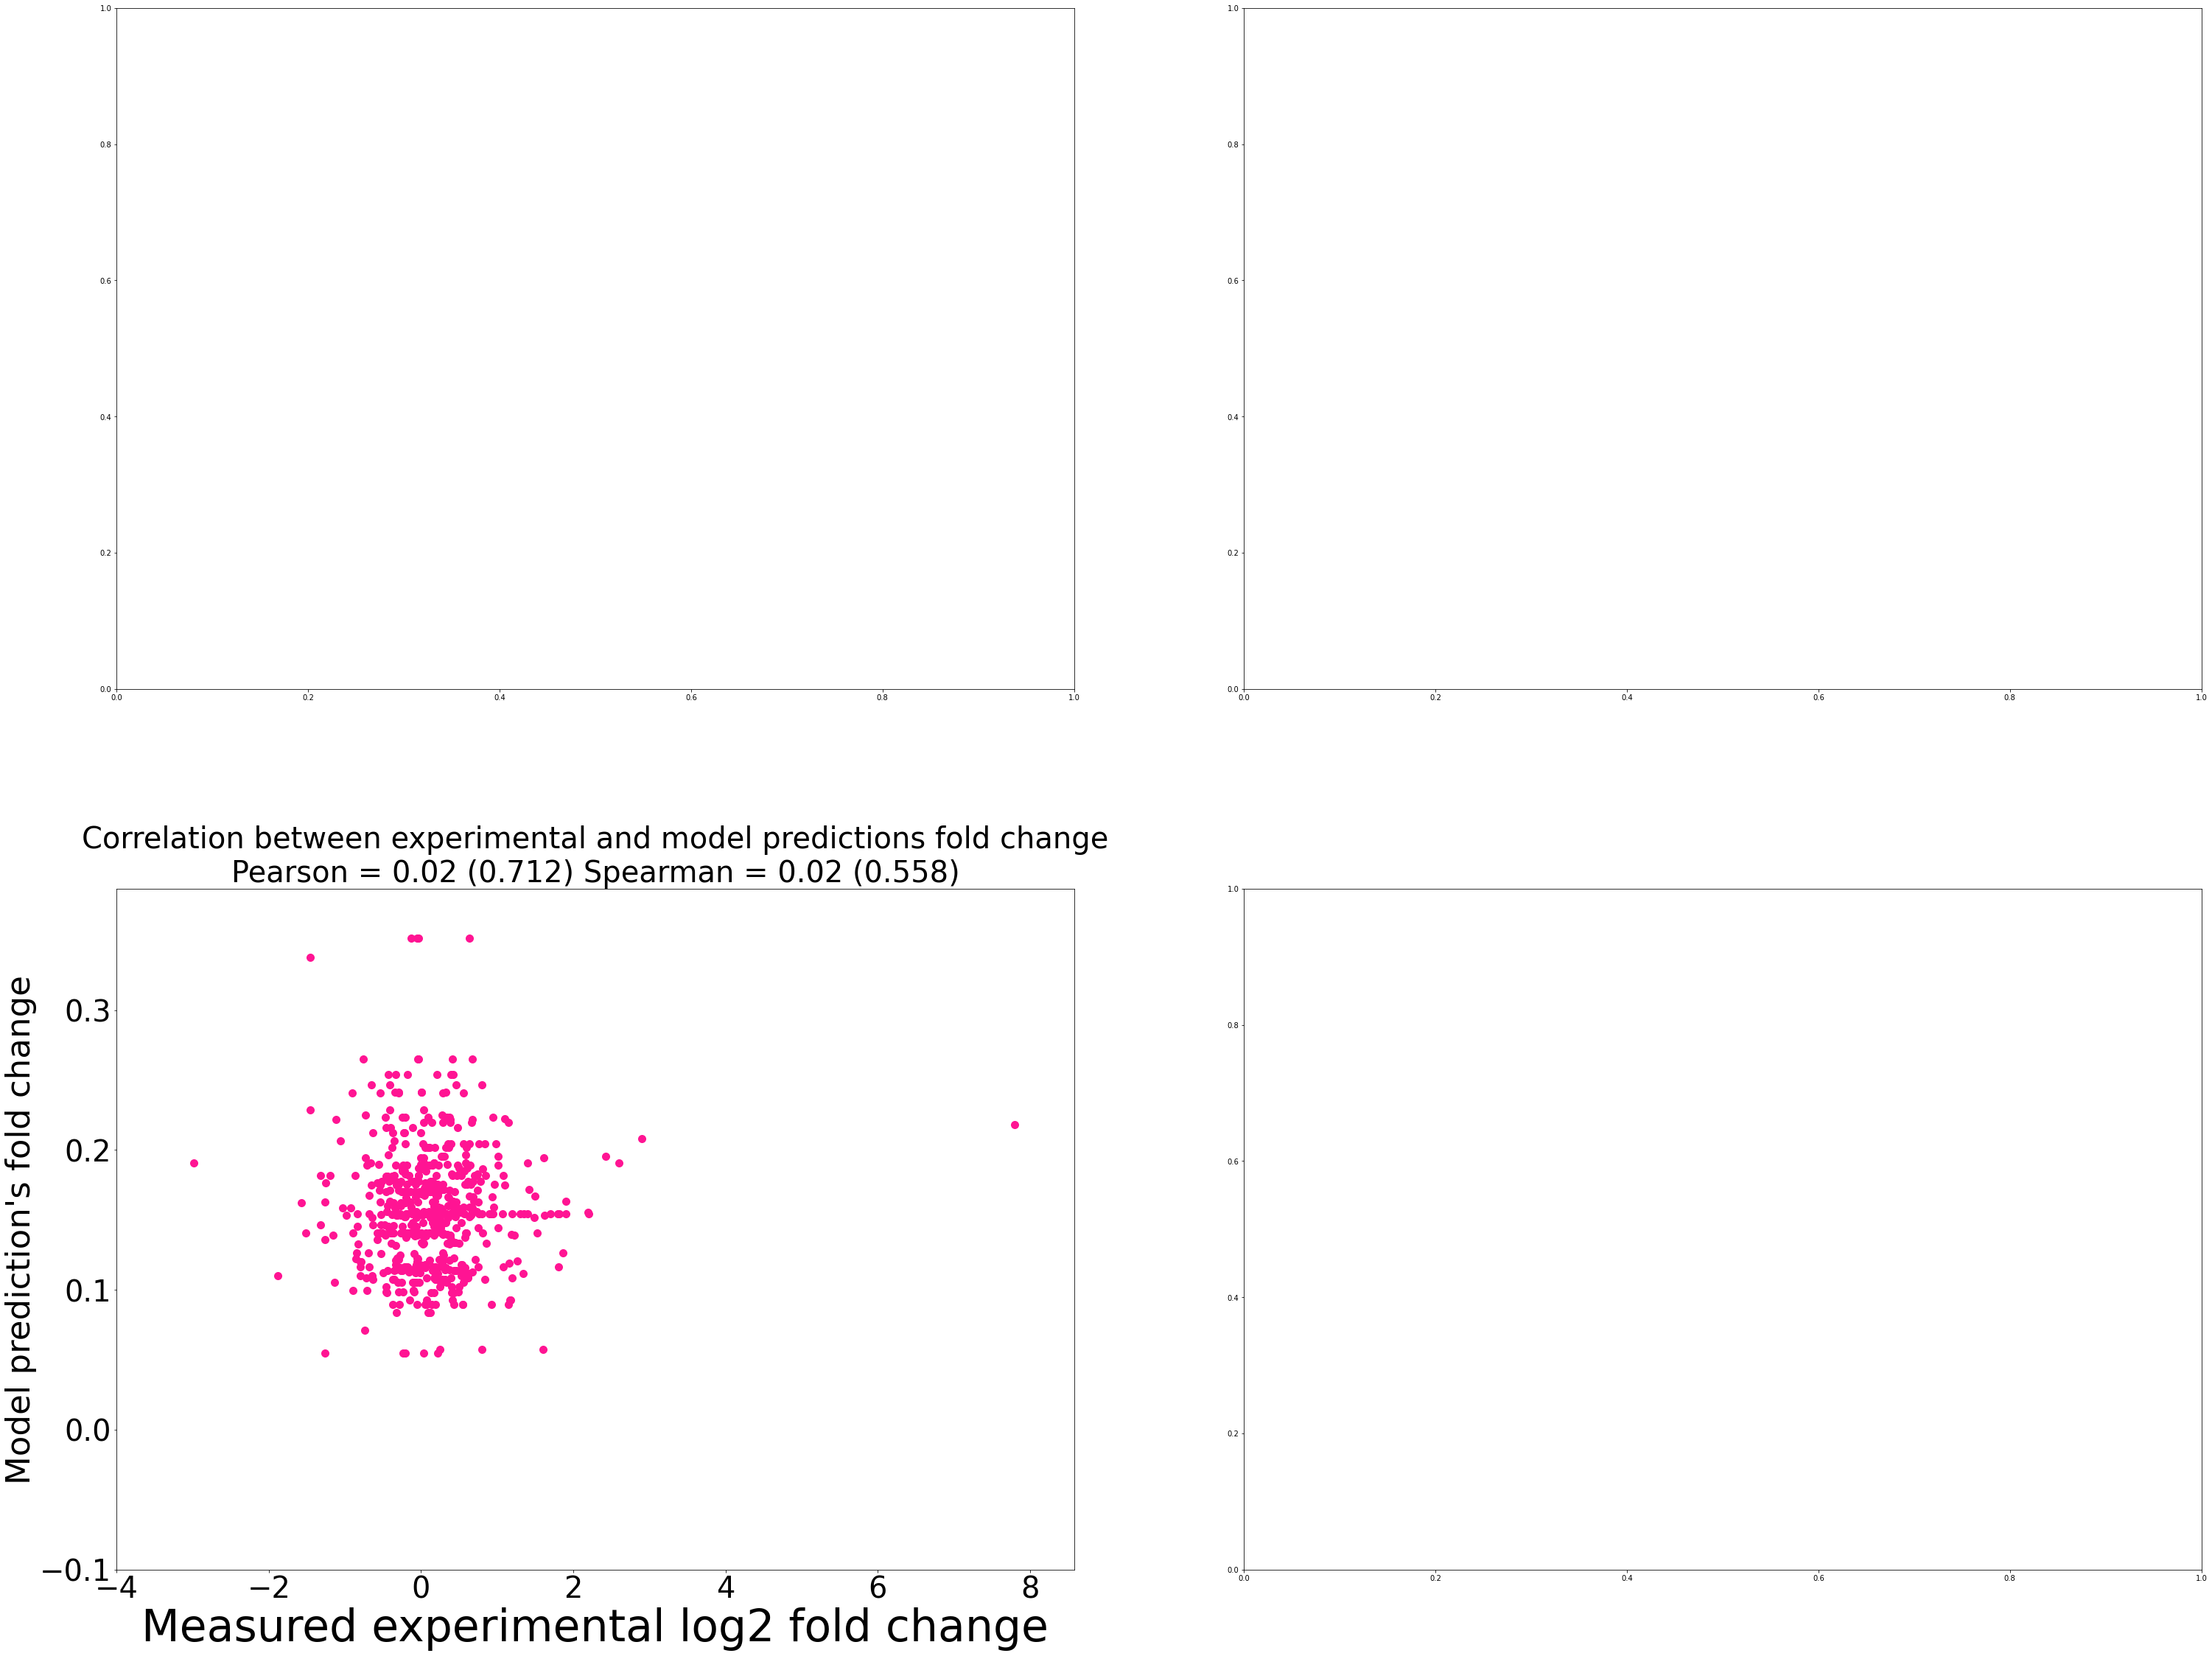

HER2 -0.011665961930723792 0.7780894793106748 4


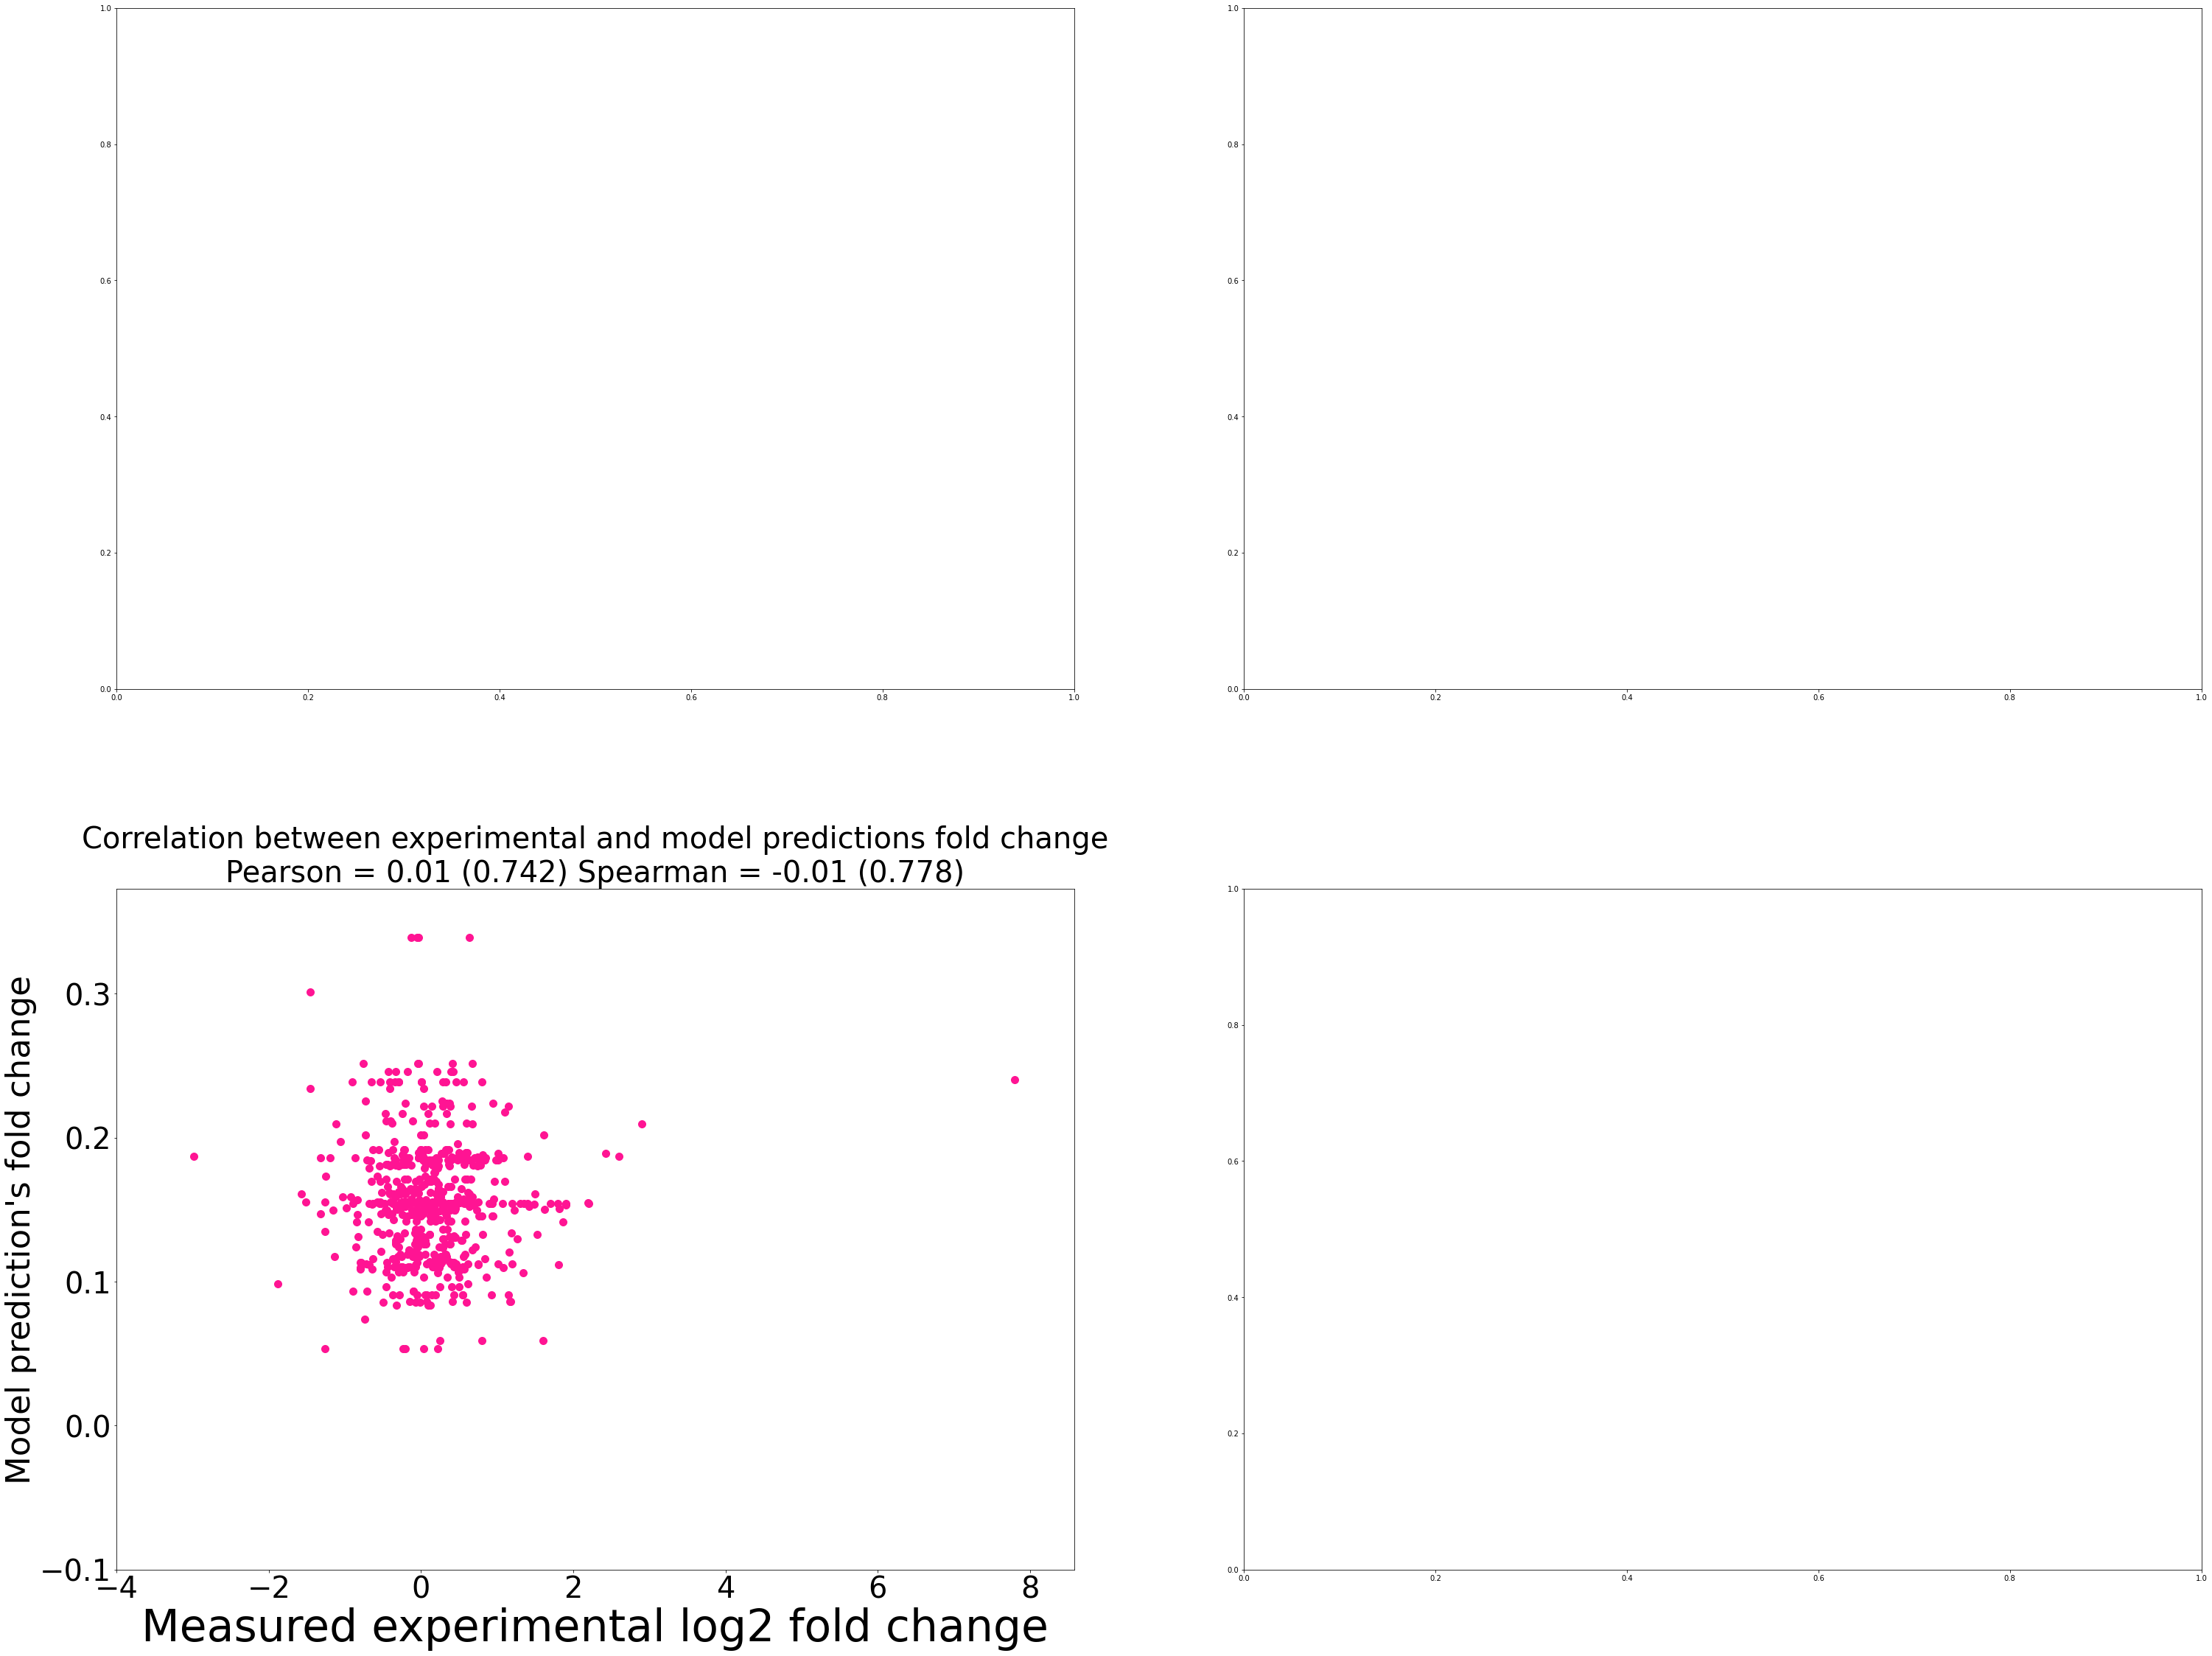

HER2 -0.0071239828534675415 0.8633688764321384 5


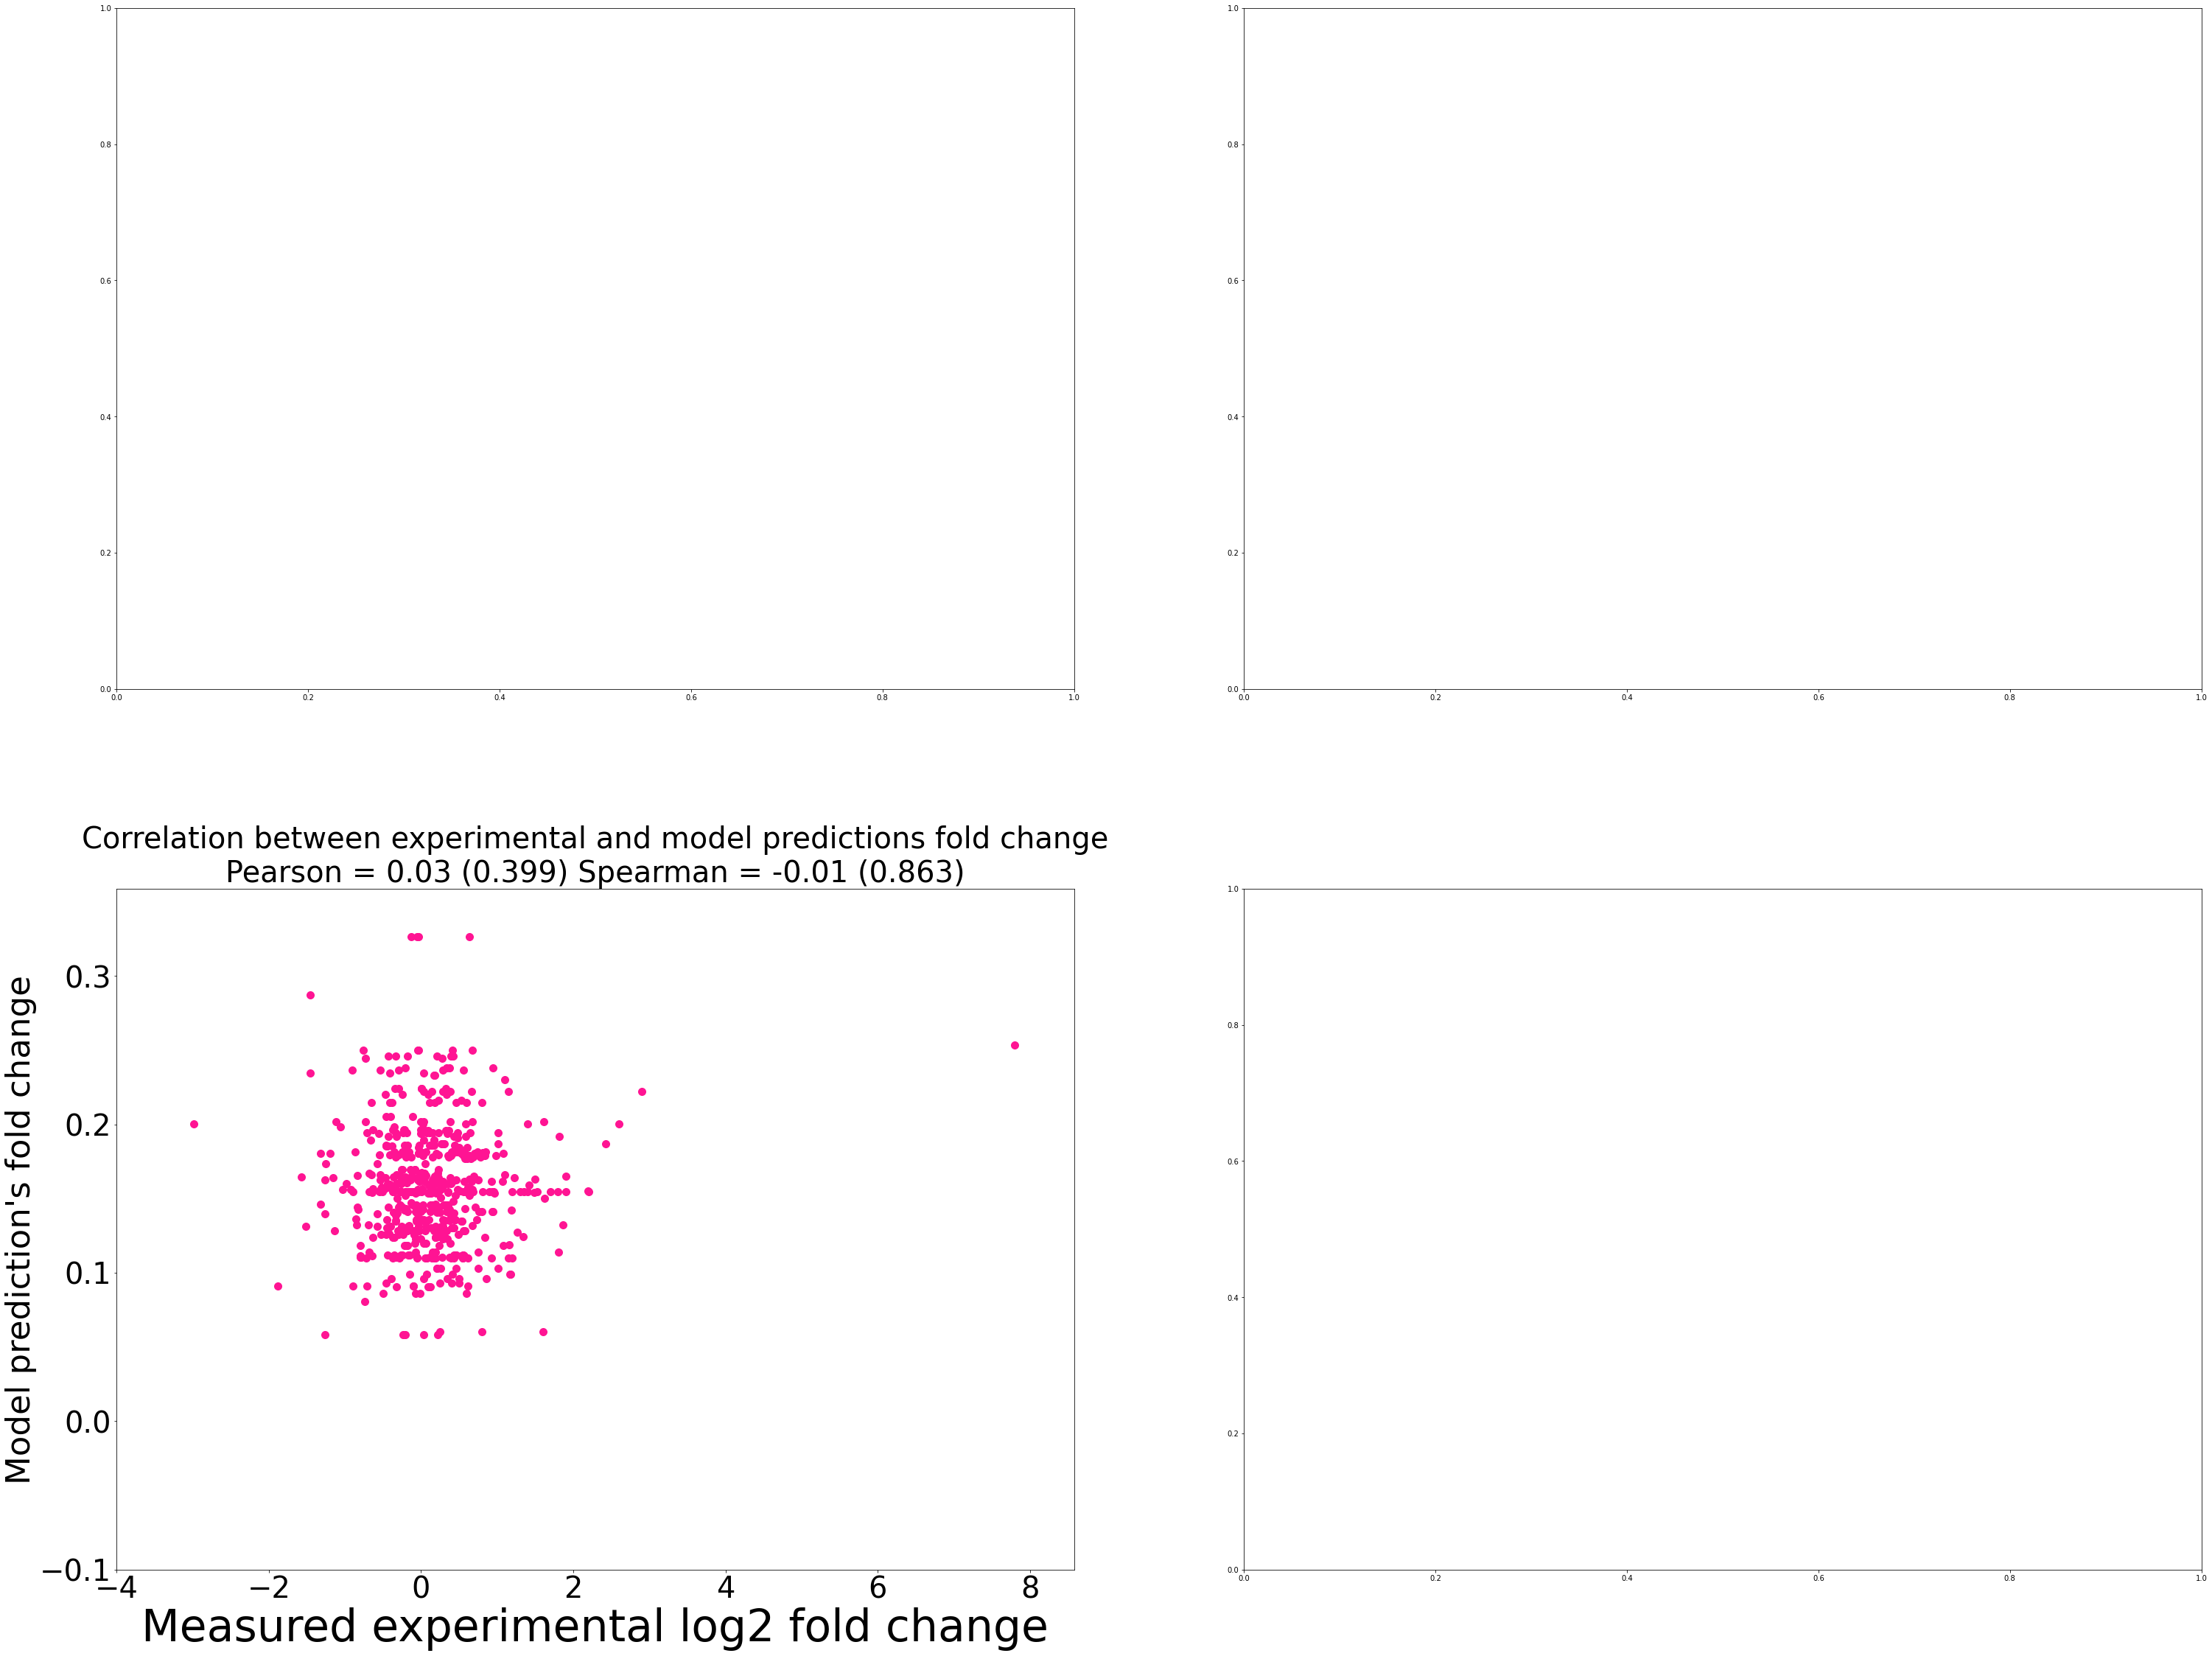

HER2 0.022043782578046678 0.5943459561608133 6


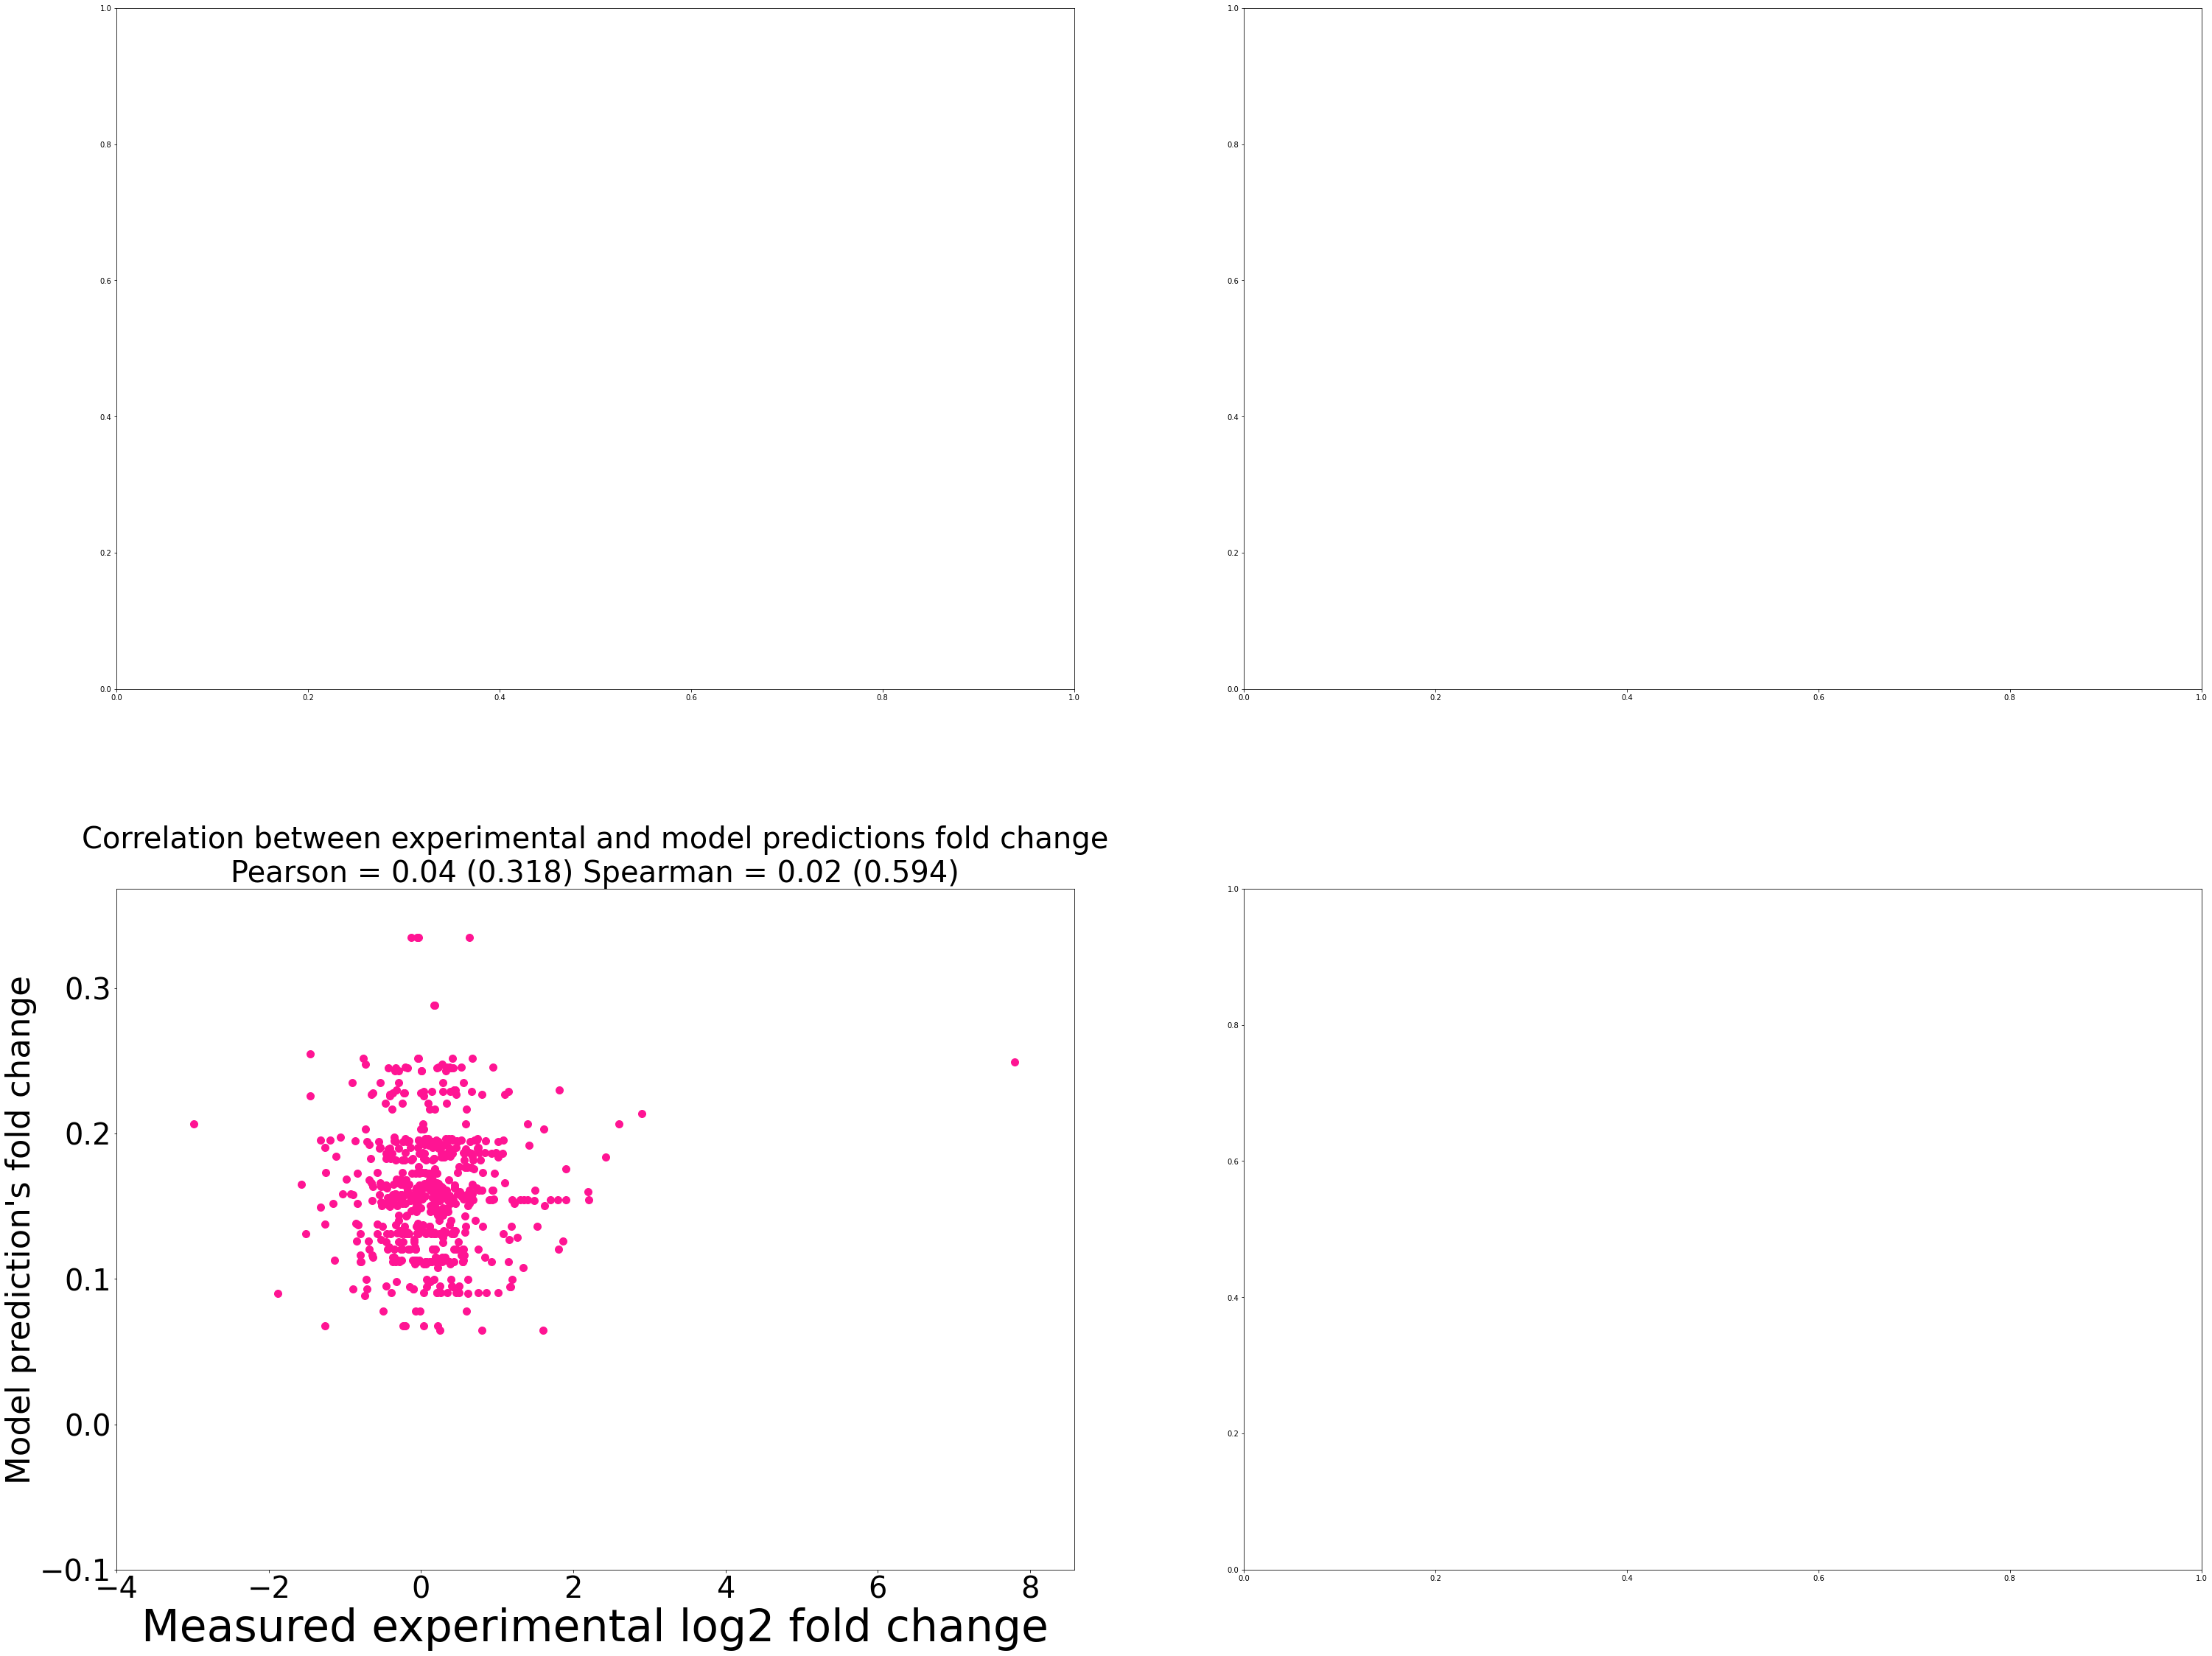

HER2 0.027209888035463644 0.5109257106755841 7


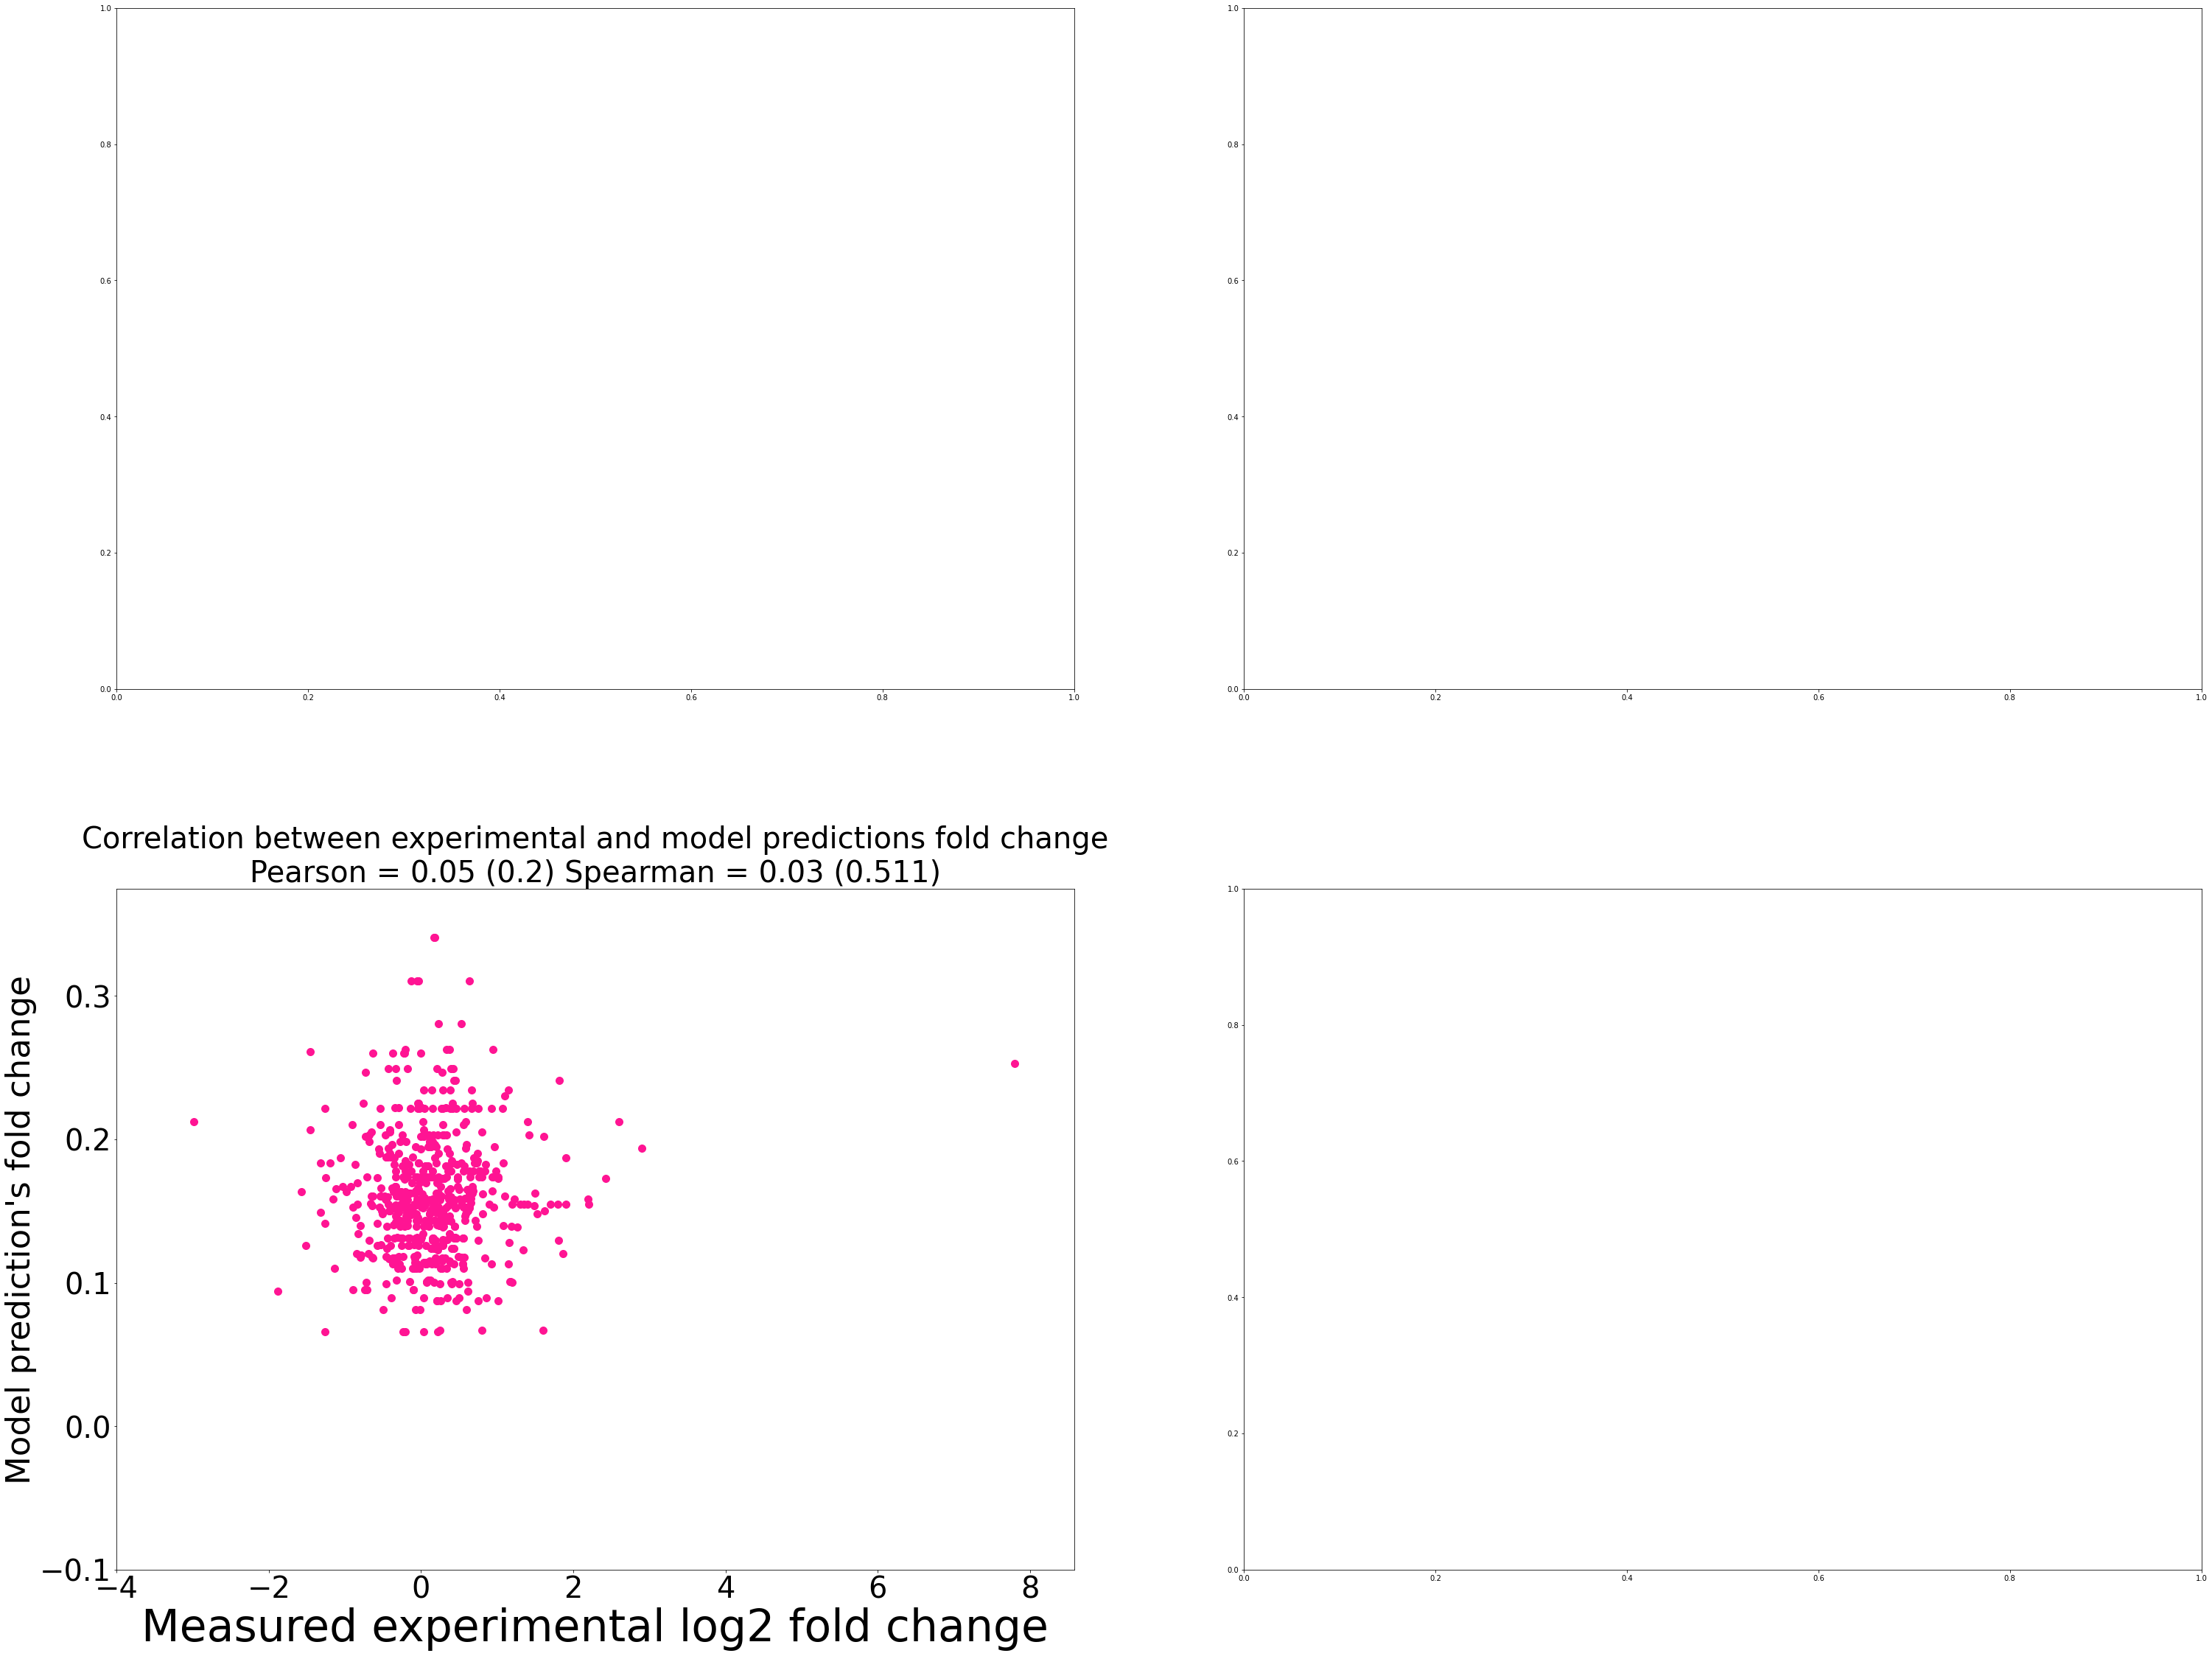

HER2 0.04971483507263486 0.2295021808045683 8


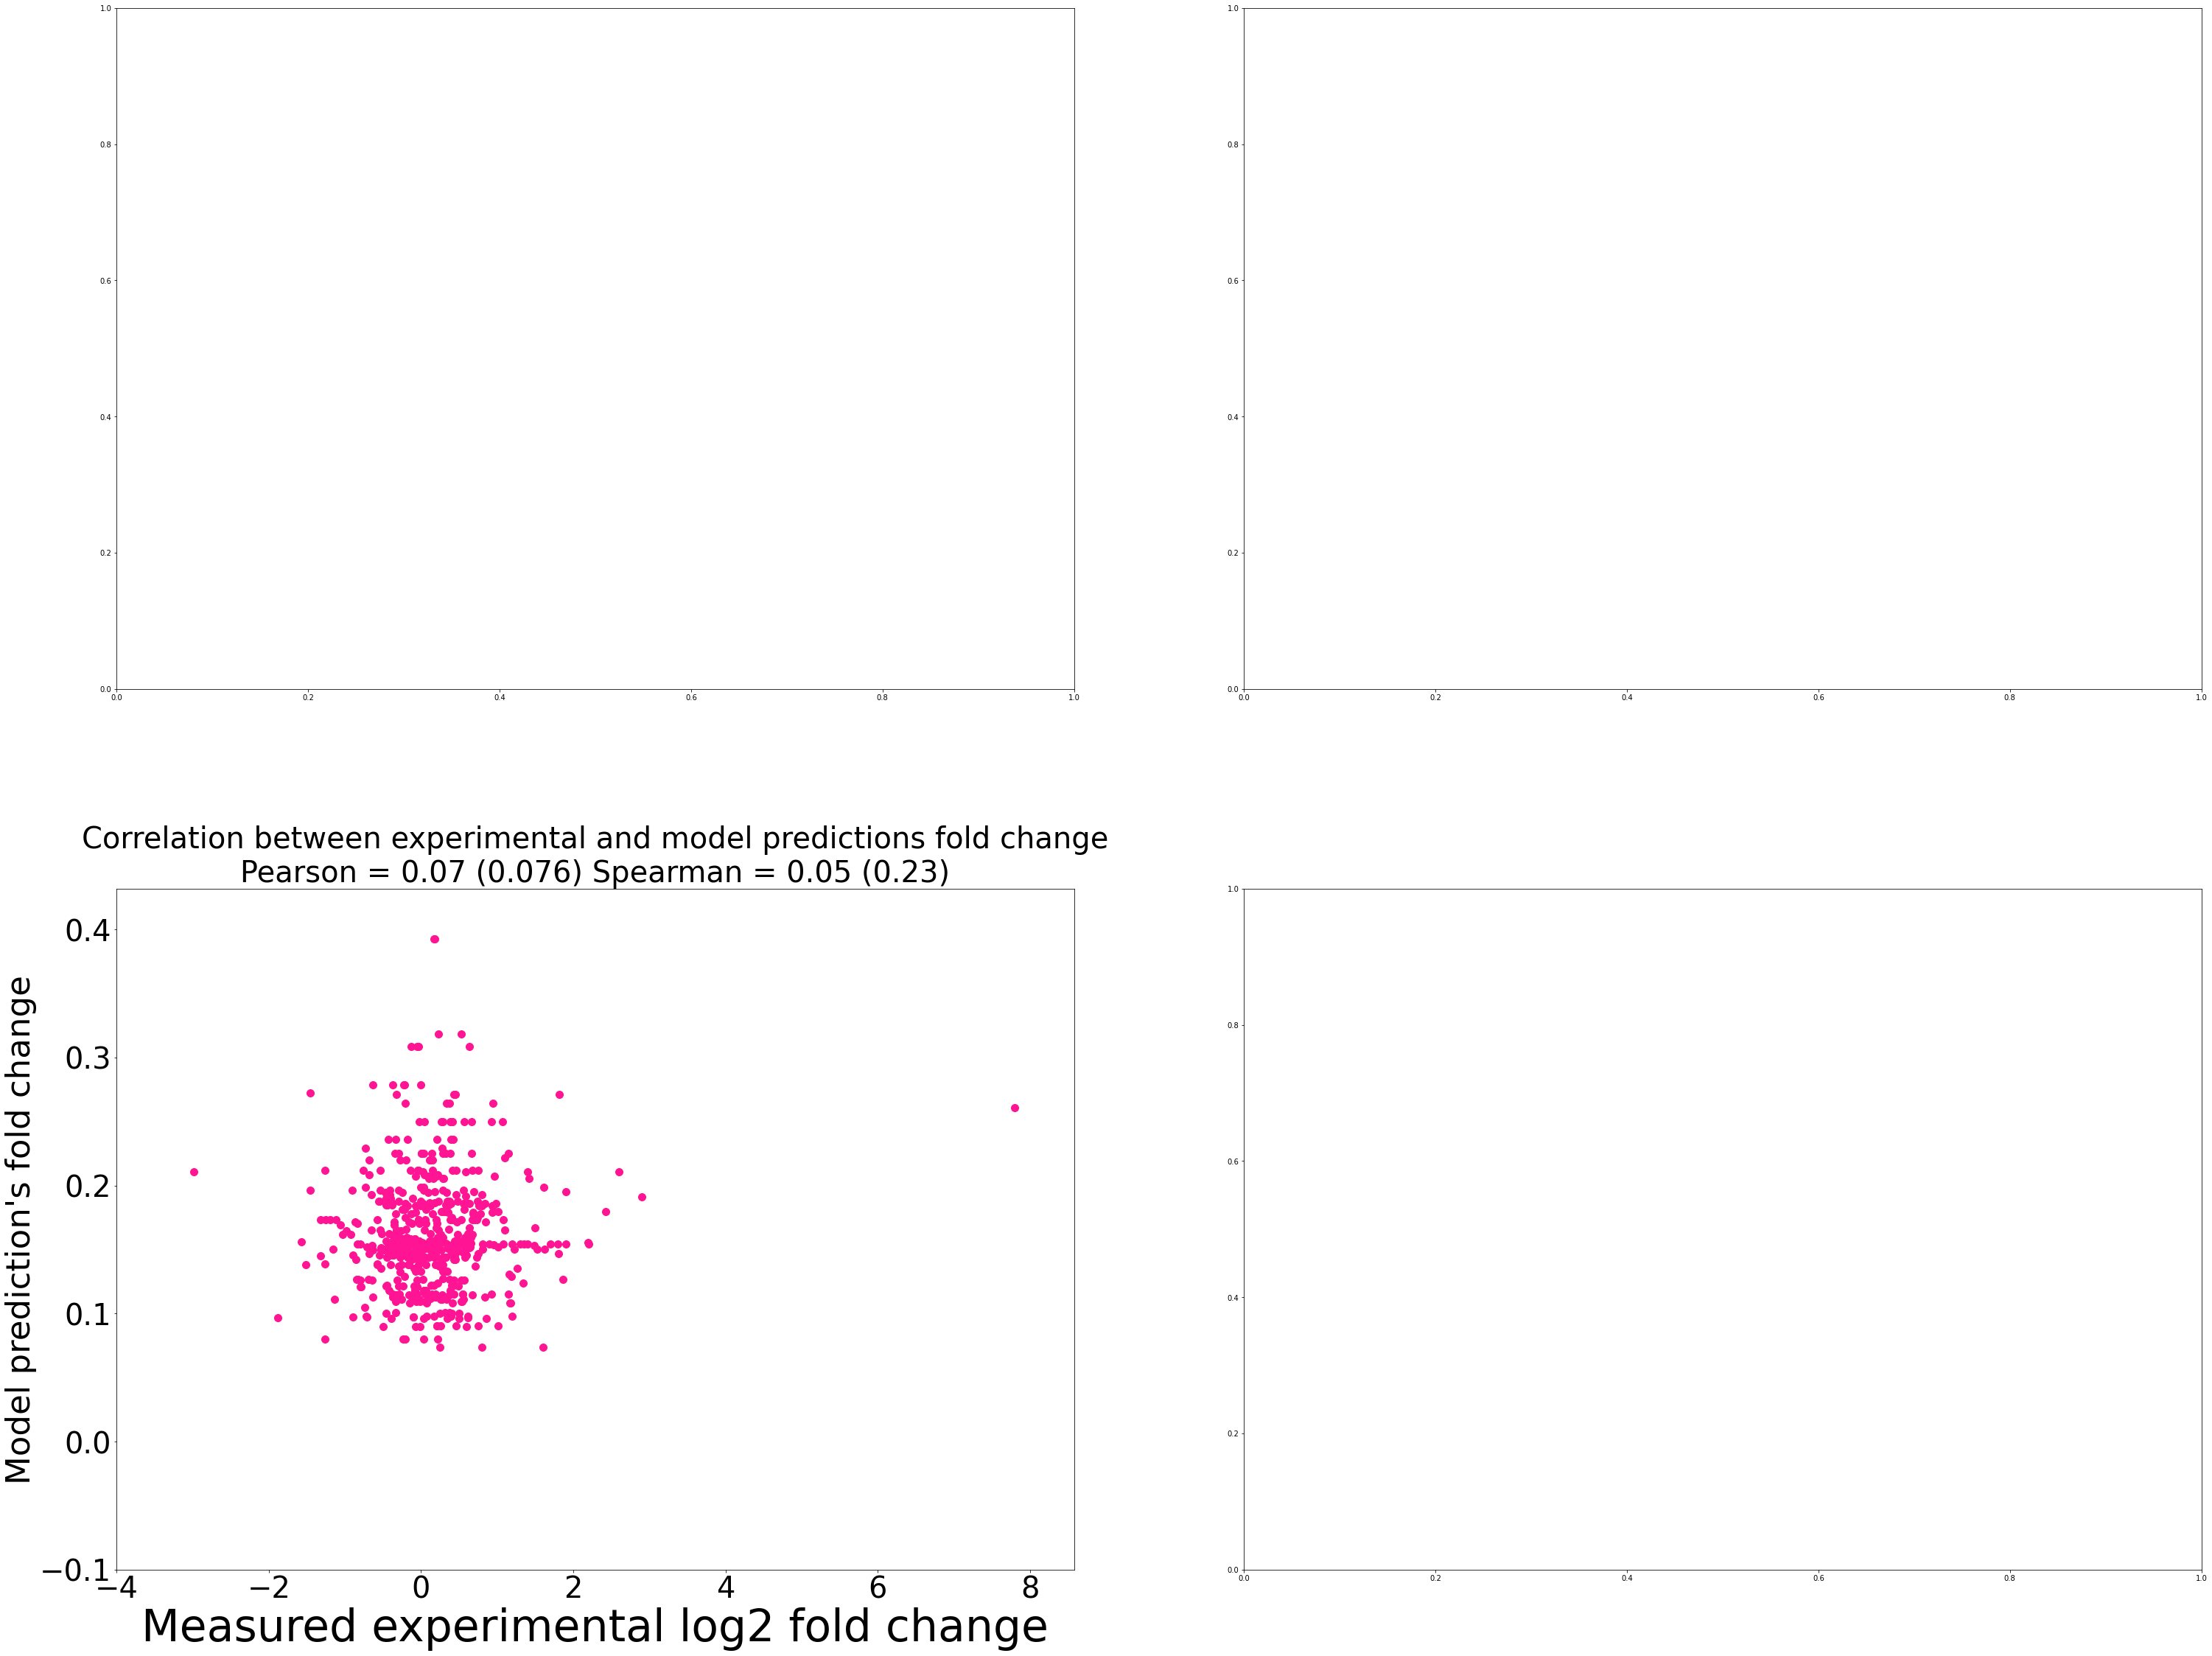

HER2 0.04276292707608351 0.3013964858997988 9


KeyboardInterrupt: 

In [61]:
# Perform perturbation analysis in HER2
df_HER2_p300_epigenome_editing = pd.read_csv("../Data/HER2.p300_epigenome_editing_dataset.tsv", sep="\t")

def her2_ise(position, cell_type_choice, gene_features, gRNA_strand, trained_model, assay_index_value, inserted_lnp1_minuslog10p_value, peak_width):

    # Load epigenetic features for all assays
    X = gene_features

    # obtain the middle portion of this
    X = X[:, (window_size//2)-operative_half_window_size:(window_size//2)+operative_half_window_size+1, :]

    # Perform inference by introducing p-value changes with a peak width
    yPred = []

    positions = [position + operative_half_window_size]
    for pos in positions:
        X_modified = np.copy(X)

        ise_start_position = max(0, pos - (peak_width // 2))
        ise_end_position = min(pos + (peak_width // 2 + 1), 2*operative_half_window_size)

        for p in range(ise_start_position, ise_end_position):
            if( (p>=0) and (p < max(positions)) ):
                if(X_modified[:, p, 2] > 10): # Remember this is ln( -log10(p-value) + 1)
                    # If H3K27me3 peak exists, then p300 doesn't work
                    print("H3K27me3 exists!")
                    pass
                else:
                    # Modify the H3K27ac peak with the shape being derived from MNase (-1) 
                    if(gRNA_strand == "plus"):
                        X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                         print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p+MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
                    elif(gRNA_strand == "minus"):
                        X_modified[:, p, 3] = X_modified[:, p, 3] + (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1] * inserted_lnp1_minuslog10p_value)
#                         print("Delta = ", gene, peak_width_choice, gRNA_strand, pos, p, (X_modified[:, min(p-MNase_offset, 2*operative_half_window_size), -1]), file=sys.stderr)
                    else:
                        pass # Change 2

        # Prepare input
        X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index_value]], axis=1)

        yPred_value = trained_model.predict(quadratic_transform.transform(X_modified))
        yy = yPred_value[0]
        yPred.append(yy)

    # Prepare input for predicting native expression
    X_modified_2 = np.copy(X)
    X_modified_2 = np.concatenate([X[:, :, 3], X[:, :, assay_index_value]], axis=1) 
    
    # Instead of scaling, divide by yPred
    yPred_value = trained_model.predict(quadratic_transform.transform(X_modified_2))[0] + 0.00000001 # to avoid divby0

#             print("Predicted TPM for ", gene, " = ", yPred_TPM)
#             print((np.power(10, yPred) -1), (np.power(10, yPred_value) -1))

    yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)
    yPred_TPM = (np.power(10, yPred_value) -1)
    
    assert(len(yPred) == 1)
    
    return yPred[0]/yPred_TPM


cell_type_choice = 13 # corresponds to HEK293T
assay_index = assay_index_choice

inserted_pvalue_choice = 1.5 # corresponds to 0.0003
peak_width_choice = 6

for MNase_offset in range(-15,15):

    # Perform in-silico epigenesis
    assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
    xticklabels = range(-operative_half_window_size, operative_half_window_size + 1)

    GENES_LIST = ["HER2", "HER2"] # ["CXCR4", "TGFBR1"]

    fig, axes = plt.subplots(nrows=len(GENES_LIST), ncols=2, figsize=(40, 30), sharey=False)
    fig.tight_layout(pad=1, w_pad=20, h_pad=25)

    for idx, gene in enumerate(sorted(GENES_LIST)):
        TPM[gene] = {}

        idx_x, idx_y = convert_to_2D(idx, nrows=len(GENES_LIST), ncols=1)
        ax_1 = axes[idx_x, 0]
        ax_2 = axes[idx_x, 1]
        
    # we want to compute 
    TSS = {}
    STRANDS = {}
    CHROMS = {}
    GENES = {}
    gRNA_STRANDS = {}
    gRNA_strands_colors = []
        
    measured_fold_change_list = []
    predicted_fold_change_list = []
    
    for index in range(len(df_HER2_p300_epigenome_editing)):
        tss = df_HER2_p300_epigenome_editing.iloc[index, 13]
        gene_strand = df_HER2_p300_epigenome_editing.iloc[index, 3]
        chrom = df_HER2_p300_epigenome_editing.iloc[index, 2]
        gene = df_HER2_p300_epigenome_editing.iloc[index, 0]

        if(gene != "HER2"):
            continue
        
        TSS[gene] = int(tss)

        if(gene_strand == "plus"):
            STRANDS[gene] = "+"
        elif(gene_strand == "minus"):
            STRANDS[gene] = "-"
        else:
            print("something wrong with strand!")

        CHROMS[gene] = chrom
        GENES[gene] = 1                                                    

        
        
        inserted_lnp1_minuslog10p_value = inserted_pvalue_choice
        peak_width = peak_width_choice

        gRNA_strand = df_HER2_p300_epigenome_editing.iloc[index, 8]
        position = pd.to_numeric(df_HER2_p300_epigenome_editing.iloc[index, 15]) // RESOLUTION
                
        gene_features = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".npy")

        predicted_fold_change = her2_ise(position, cell_type_choice, gene_features, gRNA_strand, model, assay_index - 1, inserted_lnp1_minuslog10p_value, peak_width)
        predicted_fold_change_list.append(predicted_fold_change)
        
        measured_fold_change = df_HER2_p300_epigenome_editing.iloc[index, 7]
        measured_fold_change_list.append(measured_fold_change)
        
    measured_fold_change_list = np.asarray(measured_fold_change_list)    
    predicted_fold_change_list = np.asarray(predicted_fold_change_list)    
        
    # Create a scatter plot of the means with the predictions of those positions
    pc, pp = pearsonr(measured_fold_change_list, predicted_fold_change_list)
    sc, sp = spearmanr(measured_fold_change_list, predicted_fold_change_list)

    print(gene, sc, sp, MNase_offset, file=sys.stderr)

    gRNA_strands_colors.append("blue")

    ax_1.scatter(measured_fold_change_list, predicted_fold_change_list, color="#FF1493", s=100) # ="#FF1493")
    ax_1.set_xlim(-4, 1.1 * max(measured_fold_change_list))
    ax_1.set_ylim(-0.1, 1.1 * max(predicted_fold_change_list))
    ax_1.tick_params(axis='both', which='major', labelsize=40)
    ax_1.tick_params(axis='both', which='minor', labelsize=40)
    ax_1.set_xlabel("Measured experimental log2 fold change", size=60)
    ax_1.set_ylabel("Model prediction's fold change", size=45)
#     if(pp > 0.05):
#         p_asterisk = "NS"
#     if(sp > 0.05):
#         s_asterisk = "NS"
    ax_1.set_title("Correlation between experimental and model predictions fold change\nPearson = "+
                   str(round(pc, 2))+
                   " ("+str(round(pp, 3))+
                   ") Spearman = "+
                   str(round(sc, 2))+
                   " ("+str(round(sp, 3))+
                   ")", size=40)

    # Determine whether we are doing H3K27ac ISE in the background of another assay's features
    # or we have marginal features and are doing that track's ISE
    epigenetic_features = gene_features[:, -1] # MNase
    epigenetic_features_2 = gene_features[:, 3] # H3K27ac
    color_for_assay = assay_color[3]
    label_for_assay = assays[3]

    # Scale the model predictions     
    scaling_ratio = np.median(measured_fold_change_list)/np.median(predicted_fold_change_list)
    scaled_model_predictions = 0.5 * (scaling_ratio * (predicted_fold_change_list))

    # Scale the epigenetic features
    epigenetic_features_scaling_ratio = max(measured_fold_change_list)/max(epigenetic_features)
    scaled_epigenetic_features = (epigenetic_features_scaling_ratio * (epigenetic_features))

    epigenetic_features_scaling_ratio_2 = max(measured_fold_change_list)/max(epigenetic_features_2)
    scaled_epigenetic_features_2 = (epigenetic_features_scaling_ratio_2 * (epigenetic_features_2))

#     ax_2.plot(xticklabels, scaled_model_predictions, 'o-', color="#4daf4a", linewidth=5, markersize=2, label="(Scaled) Model Predictions " + label_for_assay)
#     ax_2.plot(xticklabels, scaled_epigenetic_features, 'o-', color="#8470FF", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features MNase") # + label_for_assay)
#     ax_2.plot(xticklabels, scaled_epigenetic_features_2, 'o-', color="darkblue", linewidth=5, markersize=1, label="(Scaled) Epigenetic Features H3K27ac") # + label_for_assay)

#     ax_2.bar(positions_TSS, (measured_fold_change_list), color="#f781bf", bottom=0, width=2, label="Experimental mean from qPCR")

#     color_dict = {}
#     color_dict["+"] = {"plus":"blue", "minus":"red"}
#     color_dict["-"] = {"plus":"red", "minus":"blue"}
#     direction = {"blue":"rightward", "red":"leftward"}
#     color_index = 0
#     for name, group in gRNA_strand_groups:
#         ax_2.plot(group['Position_wrt_TSS'], 0.0 + (group['Measured fold change']), 'o', color=color_dict[STRANDS[gene]][name], label="qPCR facing "+direction[color_dict[STRANDS[gene]][name]], markersize=15)
#         color_index += 1

#     ax_2.set_xlim(-operative_half_window_size-10, operative_half_window_size+10)
#     ax_2.set_ylim(-1, 1.0 + max(measured_fold_change_list)*1.5)
#     x_vals = ax_2.get_xticks()
#     ax_2.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
#     ax_2.yaxis.set_major_locator(MaxNLocator(integer=True))
#     ax_2.tick_params(axis='both', which='major', labelsize=35)
#     ax_2.tick_params(axis='both', which='minor', labelsize=35)
#     ax_2.set_xlabel("Peak Position (in bp) w.r.t TSS", size=50)
#     ax_2.set_ylabel("Gene expression fold change", size=50)
#     ax_2.set_title(gene+" with H3K27ac + "+assays[assay_index-1]+"\nincreasing " + str(peak_width * RESOLUTION) + "bp peaks by -log10(p_value)="+str(p_value_mapping(inserted_lnp1_minuslog10p_value)), size=40) #, y=1.1)

#     ax_2.legend(loc='upper center', prop={'size': 30}, ncol=2)

#     # Now also keep storing the actual TPM vs predicted TPM for each gene, for each cell type
#     actual_TPM = np.load("../Data/" + gene + ".T" + '%02d' % cell_type_choice + ".TPM.npy")
# #             print(gene, cell_type_choice, (np.power(10, actual_TPM[0][0]) -1), yPred_TPM)
#     TPM[gene][cell_type_choice] = ((np.power(10, actual_TPM[0][0]) -1), yPred_TPM)

    plt.show()
    plt.close()



In [ ]:
# Analyze predicted TPMs across cell types for a given gene
plt.rcParams["figure.figsize"] = (10, 10)
for gene in TPM.keys():
    gene_TPM = [(v[0], v[1]) for v in TPM[gene].values()]
#     print(gene, gene_TPM)

    gene_TPM = np.asarray(gene_TPM)
    pc, pp = pearsonr(gene_TPM[:, 0], gene_TPM[:, 1])
    sc, sp = spearmanr(gene_TPM[:, 0], gene_TPM[:, 1])

    plt.plot(gene_TPM[:, 0], gene_TPM[:, 1], 'o', markersize=10)
    plt.xlabel("True TPM", fontsize=20)
    plt.ylabel("Predicted TPM", fontsize=20)
    plt.xlim(-1, 50)
    plt.ylim(-1, 5)
    plt.title(gene+ ": Pearson = "+str(round(pc, 2))+" Spearman = "+str(round(sc, 2)), fontsize=25)
    plt.show()
    plt.close()

In [ ]:
list( zip( [x[1] for x in TPM["CXCR4"].values()], [x[1] for x in TPM["TGFBR1"].values()] ) )

In [ ]:
# Analysis of MNase-seq and H3K27ac in K562
import pyBigWig
K562_H3K27ac = pyBigWig.open("../Data/MNase_H3K27ac/K562.H3K27ac.ENCFF469JMR.bigWig")
K562_MNase = pyBigWig.open("../Data/MNase_H3K27ac/K562.MNase.hg38.sorted.chromosomes.non_overlapping.ENCFF000VNN.bigWig")
chrom = "chr9"
K562_H3K27ac_values = np.nan_to_num( K562_H3K27ac.values(chrom, 0, K562_H3K27ac.chroms(chrom), numpy=True) )
K562_MNase_values = np.nan_to_num( K562_MNase.values(chrom, 0, K562_MNase.chroms(chrom), numpy=True) )

print(K562_H3K27ac_values.shape, K562_MNase_values.shape)

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(K562_MNase_values, K562_H3K27ac_values, 'o', markersize=0.1)
plt.xlabel("MNase-seq __", fontsize=20)
plt.ylabel("H3K27ac -log10(p-values)", fontsize=20)
plt.xlim(-1, 20)
plt.ylim(-1, 200)
plt.title(gene+ ": Pearson = "+str(round(pc, 2))+" Spearman = "+str(round(sc, 2)), fontsize=25)
plt.show()
plt.close()

In [ ]:
for mnase_level in [0, 1, 2, 3, 4, 5, 10, 20]:
    for H3K27ac_threshold in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]:
        print(mnase_level, H3K27ac_threshold, np.where(K562_H3K27ac_values[np.where(K562_MNase_values >= mnase_level)] >= H3K27ac_threshold)[0].shape )